In [321]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

#emcee
import emcee
import corner as corner
import time

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import curve_fit

class Aetas():
    '''
    A class to calculate a star's age and extinction using PARSEC isochrones and extinction law
    from Cardelli et al. 1989 by fitting Gaia (BP, RP) and 2MASS (J,H,K) photometry
    '''
    def __init__(self,teff,abund,obsphot,distance,isochrones,rv=3.1):
        
        '''
        teff: [array] Teff and error of star np.array([teff,teff_err])
        abund: [2x1 array] first column is [M/H],[Alpha/M]
        obs_phot: [5x2 array] first column is GBP,GRP,J,H,K and the second column is the errors in the first 
        distance: [float] distance to star in pc
        isochrones: [astropy Table] PARSEC isochrone table
        rv: [float] Rv value (=Av/E(B_V)) 
        '''
        
        # Teff
        self.teff = teff[0] # temperature
        self.teff_err = teff[1] # temperature error
        
        # Salaris [Fe/H] Asplund 2021 et al.
        self.salfeh = abund[0,0]+np.log10(0.659*(10**(abund[1,0]))+0.341) # Salaris Corrected [Fe/H]
        self.salfeh_err = np.sqrt(abund[0,1]**2+((1-0.341/(0.659*(10**(abund[1,0]))+0.341))*abund[1,1])**2)
        self.phot = obsphot[:,0] # photometry
        self.phot_err = obsphot[:,1] # photometry errors
        
        # Distance modulus
        self.distance = distance
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # Absolute Magnitudes Not Derreddened
        self.absphot = self.phot-self.distmod
        
        # PARSEC isochrones
        self.rv = rv
        self.labels = ['G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']
        self.phot_cov = np.cov(np.array([isochrones['G_BPmag'],isochrones['G_RPmag'],
                                         isochrones['Jmag'],isochrones['Hmag'],isochrones['Ksmag']]))
        
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        self.uniq_ages = np.unique(self.iso['logAge'])
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        # Effective Wavelengths of different passbands in units of microns
        self.leff = {'G_BPmag':0.5387,'Gmag':0.6419,'G_RPmag':0.7667,'Jmag':1.2345,'Hmag':1.6393,'Ksmag':2.1757}
        self.redvec = {'gpkrpk':np.array([self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag']),
                               self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag'])]),
                       'gpkjk':np.array([self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag']),
                              self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])]),
                       'gpkhk':np.array([self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag']),
                              self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])]),
                       'rpkjk':np.array([self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag']),
                              self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])]),
                       'rpkhk':np.array([self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag']),
                              self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])]),
                       'jkhk':np.array([self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag']),
                             self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])])} 
        
    #################
    ### Utilities ###
    #################
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value
        
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        '''
        
        data = np.asarray(data)
    
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value
    
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        
        Output:
        ------
            close1: closest value under the given value
            close2: closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    def mad(self,data):
        '''
        Calculate the median absolute deviation of the data
        '''
        return np.nanmedian(np.abs(data-np.nanmedian(data)))
    
    ##################
    ### Extinction ###
    ##################
    
    def ccm_a(self,x):
        '''
        a(x) function from ccm et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            a: a function value  
        '''
        if 0.3 <= x < 1.1:
            a = 0.574*(x**1.61)
            return a
    
        elif 1.1 <= x < 3.3:
            y = x - 1.82
            a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                 0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
            return a
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
                return a
        
            else:
                fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
                return a       
    
    def ccm_b(self,x):
        '''
        b(x) function from ccm et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            b: b function value 
        '''
        if 0.3 <= x < 1.1:
            b = -0.527*(x**1.61)
            return b
    
        elif 1.1 <= x <= 3.3:
            y = x - 1.82
            b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                 0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
            return b
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
                return b
        
            else:
                fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
                return b
    
    def ccm_alav(self,wave):
        '''
        Calculate A\lambda/Av
    
        Inputs:
        ------
            wave: effective wavelength in units of micron
        
        Output:
        ------
            alav: A\lambda/Av
        '''
        x=1/wave
        alav = self.ccm_a(x)+self.ccm_b(x)/self.rv
        return alav
    
    def fitz_alebv(self,wave):
        '''
        Fitzpatrick 1999 extinction law
        '''
        recip_anchors = np.array([0.000,0.377,0.820,1.667,1.828,2.141,2.433,3.704,3.846])#[:-2]
        alebv_anchors = np.array([0.000,0.265,0.829,2.688,3.055,3.806,4.315,6.265,6.591])#[:-2]
        
        x=1/wave
        spl = interp1d(recip_anchors,alebv_anchors)
        alebv = spl(x)
        return alebv
    
    def color_color_ak(self):
        '''
        Calculate the Ak extinction using color-color space with K as the fiducial band
        
        Output:
        ------
        ak: K band extinction 
            
        '''
        
        ### calculate the observed colors
        obs_bp = self.phot[0]-self.phot[4]
        obs_rp = self.phot[1]-self.phot[4]
        obs_jk = self.phot[2]-self.phot[4]
        obs_hk = self.phot[3]-self.phot[4]
        
        ### pick isochrone points with temperatures within 100 K of the star's Teff
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+500.))&
                           (self.iso['logTe']>np.log10(self.teff-500.)))
        iso_ = self.iso[teffcut]
        
        ### find the stellar locus
        # Gaia locus and reddening line
        bpkrpk_meds,bpkrpk_edges,_= binned_statistic(iso_['G_RPmag']-iso_['Ksmag'],iso_['G_BPmag']-iso_['Ksmag'],
                                                     'median',bins=25)
        bpkrpk_fin = np.where(np.isfinite(bpkrpk_meds)==True)
        bpkrpk_meds = bpkrpk_meds[bpkrpk_fin]
        bpkrpk_cens = (bpkrpk_edges[:-1]+np.diff(bpkrpk_edges)/2)[bpkrpk_fin]

        rpkmin = np.nanmin(iso_['G_RPmag']-iso_['Ksmag'])
        rpkmax = np.nanmax(iso_['G_RPmag']-iso_['Ksmag'])
        rpkdiff = rpkmax-rpkmin
        rpks = np.linspace(rpkmin,rpkmax)

        bpkrpk_spl = IUS(bpkrpk_cens,bpkrpk_meds)
        
        bpkrpk_redvec_mod = np.array([(self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag'])-1.),
                                      (self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag'])-1.)])
        
        def bpk_rpk_line(rpk,obs_rpk,obs_bpk,redvec):

            bpkrpk_slope = bpkrpk_redvec_mod[1]/bpkrpk_redvec_mod[0]
            bpkrpk_inter = obs_bpk-bpkrpk_slope*obs_rpk

            y = bpkrpk_slope*rpk+bpkrpk_inter 

            return y
        
        # 2MASS locus and reddening line
        jkhk_meds,jkhk_edges,_= binned_statistic(iso_['Hmag']-iso_['Ksmag'],iso_['Jmag']-iso_['Ksmag'],
                                                 'median',bins=25)
        jkhk_fin = np.where(np.isfinite(jkhk_meds)==True)
        jkhk_meds = jkhk_meds[jkhk_fin]
        jkhk_cens = (jkhk_edges[:-1]+np.diff(jkhk_edges)/2)[jkhk_fin]

        hkmin = np.nanmin(iso_['Hmag']-iso_['Ksmag'])
        hkmax = np.nanmax(iso_['Hmag']-iso_['Ksmag'])
        hkdiff = hkmax-hkmin
        hks = np.linspace(hkmin,hkmax)

        jkhk_spl = IUS(jkhk_cens,jkhk_meds)
        
        
        jkhk_redvec_mod = np.array([(self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])-1.),
                                    (self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])-1.)])
        
        def jk_hk_line(hk,obs_hk,obs_jk,redvec):

            jkhk_slope = jkhk_redvec_mod[1]/jkhk_redvec_mod[0]
            jkhk_inter = obs_jk-jkhk_slope*obs_hk

            y = jkhk_slope*hk+jkhk_inter 

            return y
        
        ### find intrinsic colors
        # Gaia
        bpkrpk_rootfunc = (bpkrpk_spl(rpks)-bpk_rpk_line(rpks,obs_rpk,obs_bpk,bpkrpk_redvec_mod))
        bpkrpk_rootfunc_spl = IUS(rpks,bpkrpk_rootfunc)
        rpk_cross = jkhk_rootfunc_spl.roots()[0]
        bpk_cross = jkhk_spl(rpk_cross)
        
        # 2MASS
        jkhk_rootfunc = jkhk_spl(hks)-jk_hk_line(hks,obs_hk,obs_jk,jkhk_redvec_mod)
        jkhk_rootfunc_spl = IUS(hks,jkhk_rootfunc)
        hk_cross = jkhk_rootfunc_spl.roots()[0]
        jk_cross = jkhk_spl(hk_cross)
        
        ### find Aks
        # Gaia
        bpkrpk_diff = np.array([rpk_cross[0]-obs_rpk,bpk_cross[0]-obs_bpk])
        ak_bpkrpk = np.dot(bpkrpk_redvec_mod,bpkrpk_diff)/np.linalg.norm(bpkrpk_redvec_mod)**2
        
        # 2MASS
        jkhk_diff = np.array([hk_cross[0]-obs_hk,jk_cross[0]-obs_jk])
        ak_jkhk = np.dot(jkhk_redvec_mod,jkhk_diff)/np.linalg.norm(jkhk_redvec_mod)**2
        
        ak = np.median([ak_bpkrpk,ak_jkhk])
        
        return ak
    
    def extinction(self,teff,teff_err):
        '''
        Calculate the K band extinction and its uncertainty
        '''

        ### Reddening to K band extinctions based on Cardelli et al.
        ebpk_k = ((self.ccm_alav(self.leff['G_BPmag'])-self.ccm_alav(self.leff['Ksmag']))/
                  self.ccm_alav(self.leff['Ksmag']))
        erpk_k = ((self.ccm_alav(self.leff['G_RPmag'])-self.ccm_alav(self.leff['Ksmag']))/
                  self.ccm_alav(self.leff['Ksmag']))
        ejk_k = ((self.ccm_alav(self.leff['Jmag'])-self.ccm_alav(self.leff['Ksmag']))/
                 self.ccm_alav(self.leff['Ksmag']))
        ehk_k = ((self.ccm_alav(self.leff['Hmag'])-self.ccm_alav(self.leff['Ksmag']))/
                 self.ccm_alav(self.leff['Ksmag']))

        e_k = np.array([ebpk_k,erpk_k,ejk_k,ehk_k])

        ### Spline 
        # pick isochrone points with temperatures within 100 K of the star's Teff
        teffcut = np.where((self.iso['logTe']<np.log10(teff+100.))&
                           (self.iso['logTe']>np.log10(teff-100.)))
        iso_ = self.iso[teffcut]

        # sort teffs
        sidx = np.argsort(iso_['logTe'])
        slogTe = iso_['logTe'][sidx]
        _, uidx = np.unique(slogTe,return_index=True)
        slogTe = slogTe[uidx]

        calc_aks = 999999.0*np.ones(4)
        calc_aks_err = 999999.0*np.ones(4)

        coeff0s = 999999.0*np.ones(4)
        intcolors = 999999.0*np.ones(4)
        intcolors_err = 999999.0*np.ones(4)
        for i in range(4):
            try:
                coeff = np.polyfit(10**slogTe,(iso_[self.labels[i]]-iso_['Ksmag'])[sidx][uidx],1)
                color_line = np.poly1d(coeff)
                intcolors[i] = color_line(teff)
                calc_aks[i] = np.divide((self.phot[i]-self.phot[-1])-color_line(teff),e_k[i])
                coeff0s[i] = coeff[0]
#             intcolors_err[i] = np.abs(np.multiply(coeff0s,teff_err))

            except:
                intcolors[i] = 999999.0
                intcolors_err[i] = 999999.0
                calc_aks[i] = 999999.0 
                calc_aks_err[i] = 999999.0
        
#         try:
        calc_aks_err = np.sqrt(np.divide(np.square(self.phot_err[:-1])+
                                             np.square(np.multiply(coeff0s,teff_err)),np.square(e_k)))
#         except:
#             calc_aks_err = 999999.0
            
            
        ### Weighted Mean
        wgts = np.square(np.reciprocal(calc_aks_err))
        wgts_sum = np.sum(wgts)

        ak = np.sum(np.multiply(calc_aks,wgts))/wgts_sum
        ak_err = np.sqrt(np.reciprocal(wgts_sum))
        
        self.ak = ak
        self.ak_err = ak_err
        
        return ak, ak_err, intcolors#, intcolors_err
    
    def get_ak_teff_chi(self):
        '''
        Calculate the teff and ak using the extinction function and chi-squared statistic
        '''
        
        obs_colors = self.phot[:4]-self.phot[-1]
        obs_colors_err = np.sqrt(np.square(self.phot_err)[:4]+self.phot_err[-1]**2)
        
        abpak_1 = self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag'])-1.0
        arpak_1 = self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag'])-1.0
        ajak_1 = self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])-1.0
        ahak_1 = self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])-1.0
        
        test_teffs = np.linspace(self.teff-500,self.teff+500,5)
        aks = 999999.0*np.ones(len(test_teffs))
        aks_err = 999999.0*np.ones(len(test_teffs))
        chis = 999999.0*np.ones(len(test_teffs))
        rmses = 999999.0*np.ones(len(test_teffs))
        
        for i in range(len(test_teffs)):
            aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
            chis[i] = sum((intcolors-obs_colors)**2/obs_colors_err**2)
            rmses[i] = np.sqrt(sum((intcolors-obs_colors)**2)/len(intcolors))
            
        idx = chis.argmin()
        teff = test_teffs[idx]
        ak = aks[idx]
        ak_err = aks_err[idx]
        rmse = rmses[idx]
        chi = chis[idx]
        
        return ak, ak_err, teff, chi, rmse
    
    #############################################
    ### Gonz\'{a}lez Hern\'{a}dez & Bonifacio ###
    #############################################
    
    def ghb_jk_teff(self,jk):
        '''
        Calculate the photometric Teff of a star using Gonz\'{a}lez Hern\'{a}dez & Bonifacio 2009
        
        Input:
        -----
            jk: J - K color
        '''
        b = np.array([0.6517,0.6312,0.0168,-0.0381,0.0256,0.0013])
        
        theta_eff = b[0]+b[1]*jk+b[2]*(jk**2)+b[3]*(jk*self.salfeh)+b[4]*self.salfeh+b[5]*(self.salfeh**2)
        teff = 5040/theta_eff
        self.ghb_teff = teff
        return teff
    
    ########################################################
    ### Separated Magnitudes, Extinctions, Ages & Masses ###
    ########################################################
    
    def teff_2_appmags(self,teff,age,verbose=False):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: Teff of star 
            age: age of star
            ak: extinction in the 2MASS K band
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        abpak = self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag'])
        arpak = self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag'])
        ajak = self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])
        ahak = self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])
        
        extincts = np.array([abpak,arpak,ajak,ahak,1.0])*self.ak
        
        lgage = np.log10(age*10**9)
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
                
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            
            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
                mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]

            return calc_mags
    
    def get_age(self,guess_ages=np.linspace(0.,17.)[::10],verbose=False):
        '''
        Find best fitting age and Ak values for a star by searching chisq space given initial guesses for
        age and extinction.
        
        Inputs:
        ------
            guess_ages: [array] initial guesses for ages in Gyr

            
        Output:
        ------
            
        '''
            
        # initialize lists
        
        curve_ages = []
        curve_chi = []
        curve_rms = []

        # loop over age and ak space 
        for j in range(len(guess_ages)): 
            try:
                # calculate best fit parameters and covariance matrix
                popt,pcov = curve_fit(self.teff_2_appmags,self.teff,self.phot,p0=guess_ages[j],
                                      bounds=(0.,17.),method='trf',sigma=self.phot_err,
                                      absolute_sigma=True,maxfev=5000)

                # populate lists
                curve_ages.append(popt[0])
                curve_mags = np.asarray(self.teff_2_appmags(self.teff,popt[0]))
                curve_chi.append(sum((curve_mags-self.phot)**2/self.phot_err**2))
                curve_rms.append(np.sqrt(sum((curve_mags-self.phot)**2)/len(curve_mags)))

            except:
                # populate lists
                curve_ages.append(999999.0)
                curve_chi.append(999999.0)
                curve_rms.append(999999.0)
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        age = np.asarray(curve_ages)[idx]
        chi = np.asarray(curve_chi)[idx]
        rms = np.asarray(curve_rms)[idx]
        self.age = age
        self.chi = chi
        self.rms = rms

        return age, chi, rms
    
    ###########################################
    ### curve_fit Magnitudes, Ages & Masses ###
    ###########################################
    
    def teff_2_absmags_curvefit(self,teff,ak,age):
        '''
        Calculate the intrinsic absolute magnitude of a star
        
        Inputs:
        ------
            teff: temperature of a star
            ak: K band extinction of a star
            age: age of a star in Gyr
        
        output:
        ------
            calc_mags: calculated absolute magnitudes
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        lgage = np.log10(age*10**9)
        
        abpak = (self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag']))
        arpak = (self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag']))
        ajak = (self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag']))
        ahak = (self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag']))
        
        extincts = np.array([abpak,arpak,ajak,ahak,1.0])*ak
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
                calc_mags[i] = mag_spl(lgteff)+extincts[i]
                
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
#             if verbose:
#                 print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            
            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
                mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+extincts[i]

            return calc_mags
    
    def get_ak_age_curvefit(self,guess_exts=np.linspace(0.,0.75,num=5),guess_ages=np.linspace(0.,17.,num=5)):
        # make on order 10 for guesses
        '''
        Find best fitting age and Ak values for a star by searching chisq space given initial guesses for
        age and extinction.
        
        Inputs:
        ------
            guess_ages: [array] initial guesses for ages in Gyr
            guess_Exts: [array] initial guesses for the K band extinction
            
        Output:
        ------
            ak: K band extinction of star
            age: age of star
            chi: final chi squared value
            rms: root mean squared value
            
        '''
            
        # initialize lists
        
        curve_aks = 999999.0*np.ones((len(guess_exts),len(guess_ages)))
        curve_ages = 999999.0*np.ones((len(guess_exts),len(guess_ages)))
        curve_chis = 999999.0*np.ones((len(guess_exts),len(guess_ages)))
        curve_rms = 999999.0*np.ones((len(guess_exts),len(guess_ages)))

        # loop over age and ak space 
        for i in range(len(guess_exts)):
            for j in range(len(guess_ages)): 
                try:
                    # calculate best fit parameters and covariance matrix
                    popt,_ = curve_fit(self.teff_2_absmags_curvefit,self.teff,self.absphot,
                                       p0=[guess_exts[i],guess_ages[j]],bounds=((0.,0.),(0.75,17.)),
                                       method='trf',sigma=self.phot_err,absolute_sigma=True,maxfev=5000)

                    # populate lists
                    curve_aks[i][j] = popt[0]
                    curve_ages[i][j] = popt[1]
                    curve_mags = np.asarray(self.teff_2_absmags_curvefit(self.teff,popt[0],popt[1]))
                    curve_chis[i][j]=sum((curve_mags-self.absphot)**2/self.phot_err**2)
                    curve_rms[i][j] = np.sqrt(sum(np.square(curve_mags-self.absphot))/len(curve_mags))

                except:
                    #populate lists
                    curve_aks[i][j] = 999999.0
                    curve_ages[i][j] = 999999.0
                    curve_chis[i][j] = 999999.0
                    curve_rms[i][j] = 999999.0
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.argmin(curve_chis)
        ak = curve_aks.flatten()[idx]
        age = curve_ages.flatten()[idx]
        chi = curve_chis.flatten()[idx]
        rms = curve_rms.flatten()[idx]
        
        self.ak = ak
        self.age = age
        self.chi = chi
        self.rms = rms
        
        return ak,age,chi,rms
    
    ##############
    ### Masses ###
    ##############
    
    def get_mass(self,age):#,age_err):
        '''
        Calculate the mass of a star by interpolating isochrones with already age 
        
        Input:
        -----
            age: age of a star in Gyr
            age_err: error in age of a star in Gyr

        Output:
        ------
            mass: mass of star in solar masses
            mass_err: error in the calculated mass of the star
        '''

        if self.age == 999999.0:
            return 999999.0 #np.array([999999.0,999999.0])
        
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+100.))&
                           (self.iso['logTe']>np.log10(self.teff-100.)))
        iso_ = self.iso[teffcut]
        
        if np.size(iso_) < 2:
            return 999999.0
        
        ### calculate the mass using interpolation
        coeffs = np.polyfit(iso_['logAge'],iso_['Mass'],4)
        interpol = np.poly1d(coeffs)
        mass = interpol(np.log10(age*10**9))
        self.mass = mass
        
        ## get error in mass calculation
#         deriv = np.poly1d(np.multiply(coeffs[:-1],np.arange(len(coeffs))[::-1][:-1]))
#         mass_err = np.abs(deriv(np.log10(age*10**9)))*age_err
#         self.mass_err = mass_err
        
        return mass#, mass_err
        
    def mass_2_age(self,mass):
        '''
        Calculate the age of a star given a mass using PARSEC isochrones

        Input:
        -----
            mass: mass of star in solar masses

        Output:
        ------
            age: age of star in Gyr
        '''

#         try:
        mass_lo,mass_hi = neighbors(self.iso['Mass'],mass)

        iso_lo = self.iso[np.where(self.iso['Mass']==mass_lo)]
        iso_hi = self.iso[np.where(self.iso['Mass']==mass_hi)]

        # younger
        sidx_lo = np.argsort(iso_lo['MH'])
        sMH_lo = iso_lo['MH'][sidx_lo]
        _, uidx_lo = np.unique(sMH_lo,return_index=True)
        sMH_lo = sMH_lo[uidx_lo]

        spl_lo = interp1d(sMH_lo,10**iso_lo['logAge'][sidx_lo][uidx_lo]/10**9)

        # older
        sidx_hi = np.argsort(iso_hi['MH'])
        sMH_hi = iso_hi['MH'][sidx_hi]
        _, uidx_hi = np.unique(sMH_hi,return_index=True)
        sMH_hi = sMH_hi[uidx_hi]

        spl_hi = interp1d(sMH_hi,10**iso_hi['logAge'][sidx_hi][uidx_hi]/10**9)

        # final spline
        final_spl = interp1d([mass_lo,mass_hi],[spl_lo(self.salfeh),spl_hi(self.salfeh)])
        age = final_spl(mass)
        return age


In [307]:
#     ######################
#     ### MCMC Functions ###
#     ######################
    
#     def teff_2_absmags_mcmc(self,ak,age,teff):
#         '''
#         Calculate the intrinsic absolute magnitude of a star
        
#         Inputs:
#         ------
#             teff: temperature of a star
#             age: age of a star in Gyr
        
#         output:
#         ------
#             calc_mags: calculated intrinsic
#         '''
        
#         #Some calcualtions to set things up
#         lgteff = np.log10(teff)
#         lgage = np.log10(age*10**9)
        
#         abpak = (self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag']))
#         arpak = (self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag']))
#         ajak = (self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag']))
#         ahak = (self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag']))
        
#         extincts = np.array([abpak,arpak,ajak,ahak,1.0])*ak
        
#         # Figure out if age is actually in the ages given in the isochrone table
#         if lgage in self.uniq_ages:
            
#             ### pick out a single isochrone 
#             aidx, = np.where(self.uniq_ages==lgage)
#             iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
#             if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
#             ### sort so temp is always increasing
#             sidx = np.argsort(iso_['logTe'])
#             slogTe = iso_['logTe'][sidx]
#             _, uidx = np.unique(slogTe,return_index=True)
#             slogTe = slogTe[uidx]
            
#             ### use a spline to get the apparent mags
#             calc_mags = 999999.0*np.ones(5)
#             for i in range(5):
#                 mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
#                 calc_mags[i] = mag_spl(lgteff)+extincts[i]
                
#             return calc_mags
            
#         else:
#             lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
#             if verbose:
#                 print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
#             ### Pick out single isochrones
        
#             # younger
#             aidx_lo, = np.where(self.uniq_ages==lgage_lo)
#             iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
#             # older
#             aidx_hi, = np.where(self.uniq_ages==lgage_hi)
#             iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
#             ### Temperature Check
#             if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
#             if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
#             ### sort so temp is always increasing
            
#             # younger
#             sidx_lo = np.argsort(iso_lo['logTe'])
#             slogTe_lo = iso_lo['logTe'][sidx_lo]
#             _, uidx_lo = np.unique(slogTe_lo,return_index=True)
#             slogTe_lo = slogTe_lo[uidx_lo]
            
#             # older
#             sidx_hi = np.argsort(iso_hi['logTe'])
#             slogTe_hi = iso_hi['logTe'][sidx_hi]
#             _, uidx_hi = np.unique(slogTe_hi,return_index=True)
#             slogTe_hi = slogTe_hi[uidx_hi]
            
#             ### use a spline to get the apparent mags
#             age_lo = 10**lgage_lo/10**9
#             age_hi = 10**lgage_hi/10**9
#             calc_mags = 999999.0*np.ones(5)
#             for i in range(5):
#                 mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
#                 mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
#                 age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
#                                                                  [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
#                 calc_mags[i] = age_spl_interp(age)+extincts[i]

#             return calc_mags
    
    
#     def lnL(self,theta,x,y):
#         '''
#         The ln(likelihood)
#         '''
#         ak, age = theta
        
#         modl = self.teff_2_absmags_mcmc(ak,age,self.teff)
#         sig2 = np.diag([np.square(self.phot_err)]) #self.phot_cov + 
#         lnl = -0.5*(np.dot(self.absphot-modl,np.dot(sig2,self.absphot-modl) - 
#                            np.log(np.linalg.det(sig2)/(2*np.pi)**5)))
#         # sum over 5 mags instead
        
#         return lnl
    
#     def lnPrior(self,theta):
#         '''
#         The ln(Prior) for the Ak and age for a star
        
#         Inputs:
#         ------
#             theta: the parameters of interest
#         '''
#         ak, age = theta
#         if 0.0 < ak < np.inf and 0.0 < age < 17.0:
#             return 0.0
#         return -np.inf
    
#     def lnProb(self,theta,x,y):
#         '''
#         Calculate the Ln(probability)
#         '''
#         lnP = self.lnPrior(theta)
#         if not np.isfinite(lnP):
#             return -np.inf
#         return lnP + self.lnL(theta,x,y)
    
#     def get_ak_age_mcmc(self,nwalkers,steps=5000,burn_in=100,plots=False,filename=None):
#         '''
#         Run an MCMC to get the age and extinctions for a star
        
#         Inputs:
#         ------
#             nwalkers: number of walkers
#             steps: number of steps
#             burn_in: number of steps to discard for burn in
#             plots: if true a plot of walker position vs step number and a final corner plot will be generated
#             filename: a filename string without extension that must be provided if plots=True to save the plots
            
#         Outputs:
#         -------
#             ak: K band extinction of a star
#             ak_err: error in K band extinction of a star
#             age: age of a star in Gyr
#             age_err: error in age of a star in Gyr
#         '''
#         # initialize walkers 
#         ndim = 2
#         pos = [self.ak + 1e-3*np.random.randn(nwalkers, ndim), self.age + 1e-2*np.random.randn(nwalkers, ndim)]
        
#         # set up sampler and run for n steps
#         sampler = emcee.EnsembleSampler(nwalkers, ndim, self.lnProb, args=(self.teff,self.absphot))
#         sampler.run_mcmc(pos, steps, progress=False)
        
#         # extract values for ak and age after cutting out anything before burn_steps is reached
#         samples = sampler.get_chain()
#         flat_samples = sampler.get_chain(discard=burn_in, flat=True)
        
#         # make plots if a walker position plot and corner plot if plots = True and return the final ak and age
#         if plots == True:
#             labels = [r'A$_K$', r'Age']
            
#             # make and save a plot of the walker positions
#             #plt.figure()
#             for j in range(pos.shape[1]):
#                 ax = axes[j]
#                 ax.plot(samples[:, :, j], "k", alpha=0.3)
#                 ax.set_xlim(0, len(samples))
#                 ax.set_ylabel(labels[j])
#                 ax.yaxis.set_label_coords(-0.1, 0.5)
#             axes[-1].set_xlabel("step number");
#             plt.savefig('walker_pos_{}.pdf'.format(filename))
            
#             # make and save a corner plot
            
#             fig = corner.corner(flat_samples, labels=labels, truths=[self.ak,self.age])
#             fig.text(0.2,0.89,r'{}'.format(labels[i]),fontsize=12)
#             plt.savefig('corner_{}.pdf'.format(filename))
#             plt.show()
            
#             ak = np.median(flat_samples[:,0])
#             ak_err = self.mad(flat_samples[:,0])
#             age = np.median(flat_samples[:,1])
#             age_err = self.mad(flat_samples[:,1])
            
#             self.ak_mcmc = ak
#             self.ak_mcmc_err = ak_err
#             self.age_mcmc = age
#             self.age_mcmc_err = age_err
            
#             return ak, ak_err, age, age_err
        
#         ak = np.median(flat_samples[:,0])
#         ak_err = self.mad(flat_samples[:,0])
#         age = np.median(flat_samples[:,1])
#         age_err = self.mad(flat_samples[:,1])

#         self.ak_mcmc = ak
#         self.ak_mcmc_err = ak_err
#         self.age_mcmc = age
#         self.age_mcmc_err = age_err
        
#         return ak, ak_err, age, age_errA

In [287]:
redvec = {'gpkrpk':np.array([ccm_alav(leff['BP'],3.1)/ccm_alav(leff['K'],3.1),
                   ccm_alav(leff['RP'],3.1)/ccm_alav(leff['K'],3.1)]),
           'gpkjk':np.array([ccm_alav(leff['BP'],3.1)/ccm_alav(leff['K'],3.1),
                  ccm_alav(leff['J'],3.1)/ccm_alav(leff['K'],3.1)]),
           'gpkhk':np.array([ccm_alav(leff['BP'],3.1)/ccm_alav(leff['K'],3.1),
                  ccm_alav(leff['H'],3.1)/ccm_alav(leff['K'],3.1)]),
           'rpkjk':np.array([ccm_alav(leff['RP'],3.1)/ccm_alav(leff['K'],3.1),
                  ccm_alav(leff['J'],3.1)/ccm_alav(leff['K'],3.1)]),
           'rpkhk':np.array([ccm_alav(leff['RP'],3.1)/ccm_alav(leff['K'],3.1),
                  ccm_alav(leff['H'],3.1)/ccm_alav(leff['K'],3.1)]),
           'jkhk':np.array([ccm_alav(leff['H'],3.1)/ccm_alav(leff['K'],3.1),
                 ccm_alav(leff['J'],3.1)/ccm_alav(leff['K'],3.1)])}

In [288]:
(redvec['gpkrpk'][1]-1.)/(redvec['gpkrpk'][0]-1.)

0.5851944462960239

# Extra Functions

In [289]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def ccm_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def ccm_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def ccm_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = ccm_a(x)+ccm_b(x)/rv
    return alav

ejk_ak = (ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1)
ebv_ak = (ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))/ccm_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data: data to search through 
        value: value of interest

    Output:
    ------
        close1: closest value under the given value
        close2: closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

abp_ebv = ccm_alav(leff['BP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
arp_ebv = ccm_alav(leff['RP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
aj_ebv = ccm_alav(leff['J'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ah_ebv = ccm_alav(leff['H'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ak_ebv = ccm_alav(leff['K'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))

In [290]:
def upturn10Gyr(age):
    '''
    Boundary for 10 Gyr upturn in Aetas and APOKASC plot 
    
    Input:
    -----
        age: age in Gyr
        
    Output:
    ------
        ups: value on boundary 
    '''
    ups = np.ones(np.size(age))
    for i in range(np.size(age)):
        if age[i] <= 11:
            up = 11

        else:
            up = age[i]
            
        ups[i] = up

    return ups

def oldapokasc(age):
    '''
    Boundary for old stars in APOKASC given young age by Aetas
    
    Input:
    -----
        age: age in Gyr
    
    Output:
    ------
        olds: value on boundary
    '''
    olds = np.ones(np.size(age))
    for i in range(np.size(age)):
        olds[i] = age[i] - 4
        
    return olds

In [291]:
from scipy.optimize import curve_fit

# PARSEC

In [292]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive_lite.fits.gz')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','Mass','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

# APOKASC

<ipython-input-293-0a79aeaf0aa8>:28: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)


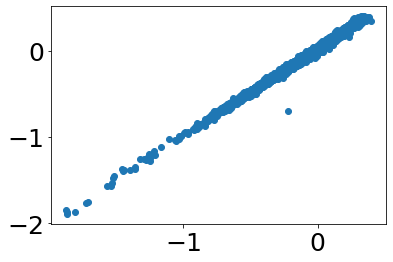

In [293]:
from astropy.io import ascii

kasc672 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.2.fits.gz')
kasc3 = ascii.read('MLtesterr3bDR16A3PalphaM_july5.out')
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec.fits.gz')

# xmatch APOKASC Catalogs
_, k672idx, k3idx = np.intersect1d(kasc672['2MASS_ID'],kasc3['2MASSID'],return_indices=True)
k672 = kasc672[k672idx]
k3 = kasc3[k3idx]

# xmatch APOKASC with DR17
_, k3idx, dr17idx = np.intersect1d(k3['2MASSID'],dr17['APOGEE_ID'],return_indices=True)

k672dr17 = k672[k3idx]
k3dr17 = k3[k3idx]
kdr17 = dr17[dr17idx]

# Select RGB stars
ageevs = np.where((k3dr17['IntAge']>-10.)&(k672dr17['APOKASC3_CONS_EVSTATES']==1.0)&
                  (kdr17['GAIAEDR3_PARALLAX']/kdr17['GAIAEDR3_PARALLAX_ERROR']>3.0))

k672dr17 = k672dr17[ageevs]
k3dr17 = k3dr17[ageevs]
kdr17 = kdr17[ageevs]

apoafe = kdr17['ALPHA_M']+kdr17['M_H']-kdr17['FE_H']
apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)

plt.scatter(kdr17['FE_H'],k3dr17['Fe/H'])

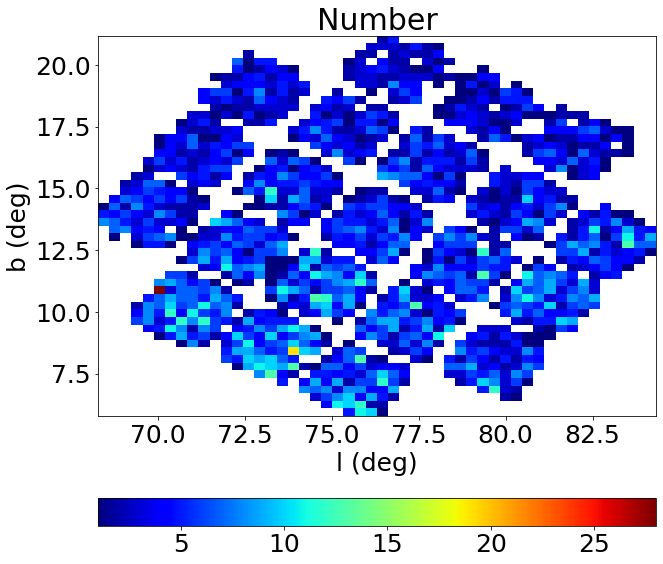

In [294]:
from scipy.stats import binned_statistic_2d

plt.figure(figsize=[10,10])
ret = binned_statistic_2d(kdr17['GLON'],kdr17['GLAT'],kdr17['GLON'],'count',bins=50)

ret.statistic[ret.statistic == 0.0] = np.nan

im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet')

plt.colorbar(orientation='horizontal')

plt.title(r'Number')
plt.xlabel(r'l (deg)')
plt.ylabel(r'b (deg)')

plt.savefig('../plots/kasc_map.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [295]:
kdr17['ASPCAPFLAG']

array([0, 0, 0, ..., 0, 0, 0])

# Gaia Magnitude Errors

In [296]:
from scipy.stats import binned_statistic
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

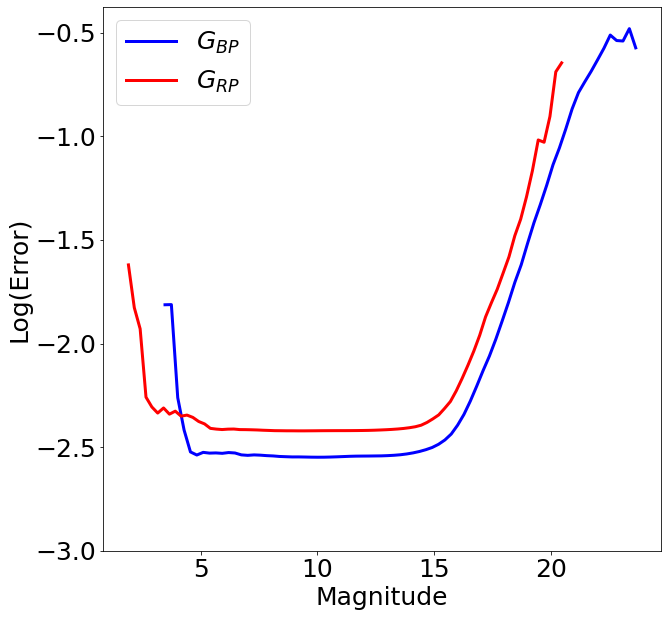

In [297]:
binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)');

bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

bperr = 10**bperrfunc(kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'])
rperr = 10**rperrfunc(kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'])

# Extinction Testing

In [324]:
kasc_ak = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_ak_err = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_teff = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_chi = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_rmse = 999999.0*np.ones(len(np.squeeze(ageevs)))

for i in tqdm_notebook(range(len(np.squeeze(ageevs)))):
    
    # Initialize Aetas 
    te = np.array([kdr17['TEFF'][i],kdr17['TEFF_ERR'][i]])
    ab = np.array([[kdr17['FE_H'][i],apoafe[i]],
                   [kdr17['FE_H_ERR'][i],apoafe_err[i]]]).T
    op = np.array([[kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                    kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                    kdr17['J'][i],kdr17['H'][i],
                    kdr17['K'][i]],
                   [bperr[i],rperr[i],kdr17['J_ERR'][i],
                    kdr17['H_ERR'][i],kdr17['K_ERR'][i]]]).T
    di = (1/kdr17['GAIAEDR3_PARALLAX'][i])*1000

    CalcAge = Aetas(te,ab,op,di,massive,rv=3.1)
    
    # ak age separate
    kasc_ak[i], kasc_ak_err[i], kasc_teff[i], kasc_chi[i], kasc_rmse[i] = CalcAge.get_ak_teff_chi()

<ipython-input-324-cd34c3a1b126>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(np.squeeze(ageevs)))):


<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-3

<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-3

<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-3

<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-3

<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-3

<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-3

<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-321-964b67aadb67>:419: RankWarning: Polyfit may be poorly conditioned
  aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
<ipython-input-3

In [325]:
kasc_ak

array([ 0.00076502,  0.01464724,  0.01169794, ..., -0.02153243,
        0.17812398, -0.00493324])

(array([3.000e+00, 8.200e+01, 1.841e+03, 3.251e+03, 7.950e+02, 5.900e+01,
        1.400e+01, 5.000e+00, 2.000e+00, 4.000e+00]),
 array([-0.08835638, -0.06170834, -0.03506031, -0.00841227,  0.01823576,
         0.0448838 ,  0.07153183,  0.09817987,  0.12482791,  0.15147594,
         0.17812398]),
 <a list of 10 Patch objects>)

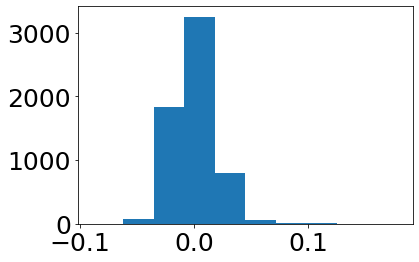

In [326]:
plt.hist(kasc_ak)

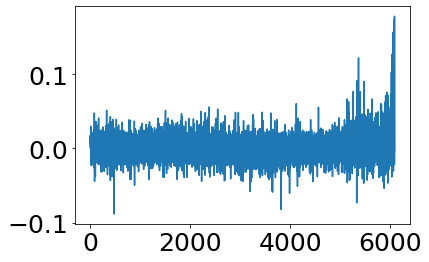

In [327]:
plt.plot(kasc_ak)

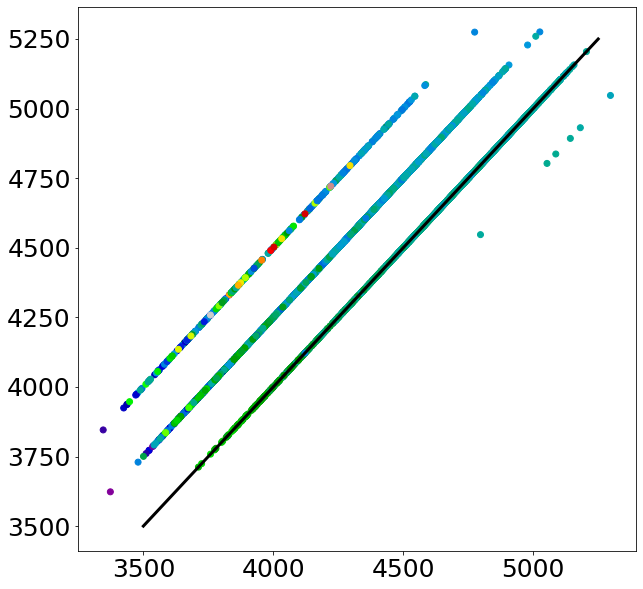

In [337]:
plt.figure(figsize=[10,10])
plt.scatter(kasc_teff,kdr17['TEFF'],c=kasc_ak,cmap='nipy_spectral')

plt.plot([3500,5250],[3500,5250],c='k',lw=3.0)

In [298]:
from tqdm import tqdm_notebook

In [299]:
apoafe = kdr17['ALPHA_M']+kdr17['M_H']-kdr17['FE_H']
apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)

# 0.659, 0.341 from Asplund et al 2021.
salfeh = kdr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(kdr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe_err))+0.341))*apoafe)**2)

<ipython-input-299-764cca630a24>:2: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)


In [219]:
singfeh = massive[np.where((massive['MH']==closest(massive['MH'],-0.3))&
                           (massive['logTe']<np.log10(kdr17['TEFF'][33]+500))&
                           (massive['logTe']>np.log10(kdr17['TEFF'][33]-500)))]

In [220]:
print(np.where((salfeh<=-0.3+0.01)&(salfeh>=-0.3-0.01)&(kdr17['TEFF']==kdr17['TEFF'][33])))
star = kdr17[33]

(array([33]),)


In [221]:
10**singfeh['logTe']

<Column name='logTe' dtype='float64' length=12303>
 4415.704473533126
 4608.928809808955
 4543.599049293402
 4486.420743836898
  4438.12980308139
  4817.25903559163
 4736.963081746328
 4673.045396315099
 4621.681360922446
 4572.987349813346
 4547.785786436917
 4530.018754322402
               ...
  5044.28945952414
 5014.180920308942
4996.8924263059425
 4984.252094042598
 4971.643737252428
 4961.351535855698
 4951.080641176657
 4939.693471692561
 4928.332491971514
  4915.86559156862
  4902.30130136168
 4888.774438941448

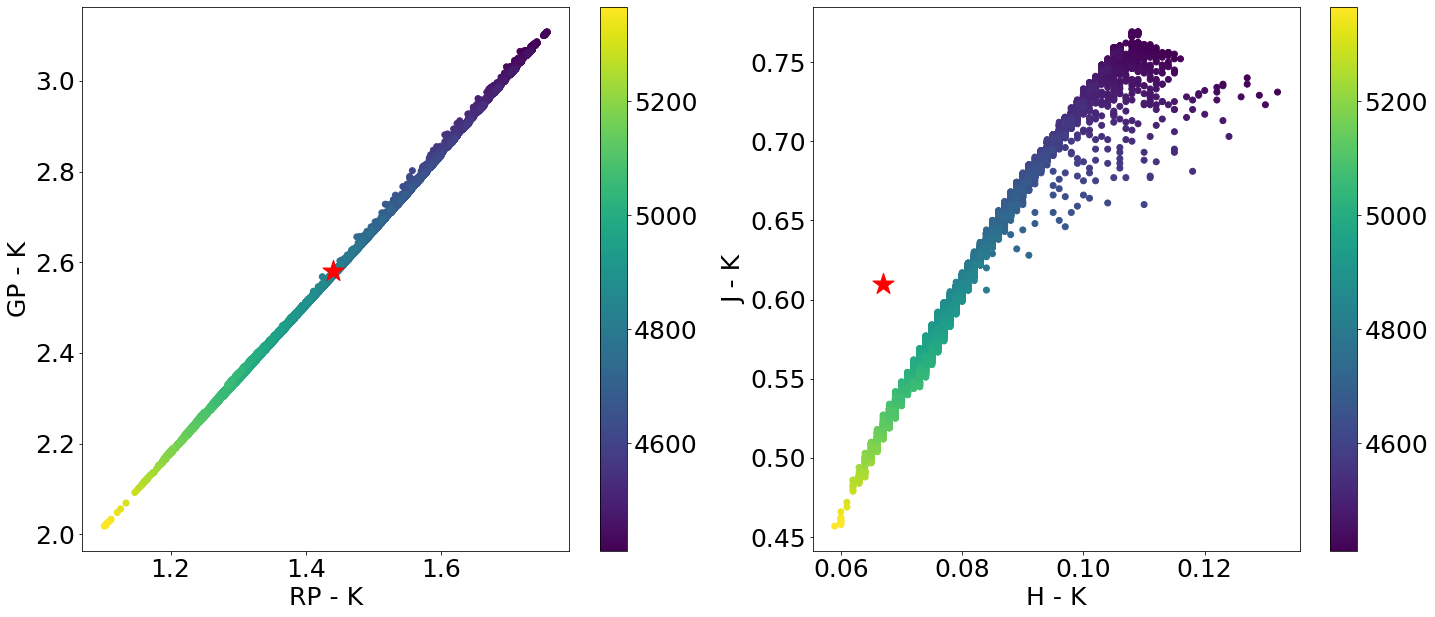

In [222]:
plt.figure(figsize=[24,10])
plt.subplot(121)
plt.scatter(singfeh['G_RPmag']-singfeh['Ksmag'],singfeh['G_BPmag']-singfeh['Ksmag'],c=10**singfeh['logTe'])
plt.colorbar()
plt.scatter(star['GAIAEDR3_PHOT_RP_MEAN_MAG']-star['K'],
            star['GAIAEDR3_PHOT_BP_MEAN_MAG']-star['K'],c='r',marker='*',s=500)

plt.xlabel(r'RP - K')
plt.ylabel(r'GP - K')

plt.subplot(122)
plt.scatter(singfeh['Hmag']-singfeh['Ksmag'],singfeh['Jmag']-singfeh['Ksmag'],c=10**singfeh['logTe'])
plt.colorbar()
plt.scatter(star['H']-star['K'],star['J']-star['K'],c='r',marker='*',s=500)

plt.xlabel(r'H - K')
plt.ylabel(r'J - K')

plt.show()

# plt.figure(figsize=[24,10])
# plt.subplot(121)
# plt.scatter(singfeh['Jmag']-singfeh['Ksmag'],singfeh['G_BPmag']-singfeh['Ksmag'],c=10**singfeh['logTe'])
# plt.colorbar()

# plt.xlabel(r'J - K')
# plt.ylabel(r'GP - K')

# plt.subplot(122)
# plt.scatter(singfeh['Hmag']-singfeh['Ksmag'],singfeh['G_RPmag']-singfeh['Ksmag'],c=10**singfeh['logTe'])
# plt.colorbar()

# plt.xlabel(r'H - K')
# plt.ylabel(r'J - K')

# plt.show()

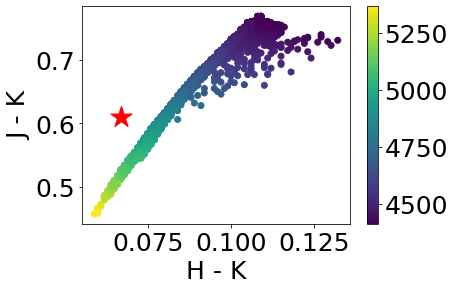

In [223]:
plt.scatter(singfeh['Hmag']-singfeh['Ksmag'],singfeh['Jmag']-singfeh['Ksmag'],c=10**singfeh['logTe'])
plt.colorbar()
plt.scatter(star['H']-star['K'],star['J']-star['K'],c='r',marker='*',s=500)

plt.xlabel(r'H - K')
plt.ylabel(r'J - K')

plt.show()

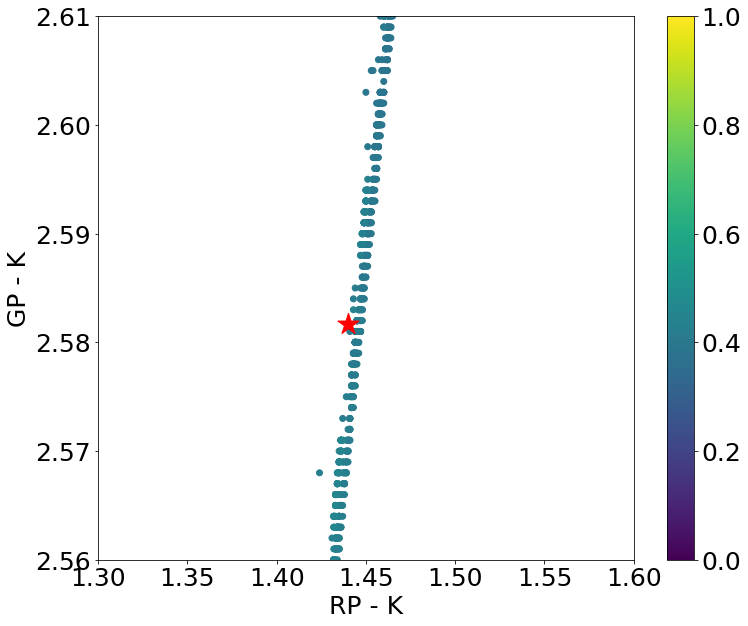

In [224]:
plt.figure(figsize=[12,10])
plt.scatter(singfeh['G_RPmag']-singfeh['Ksmag'],singfeh['G_BPmag']-singfeh['Ksmag'],c=10**singfeh['logTe'])
plt.scatter(star['GAIAEDR3_PHOT_RP_MEAN_MAG']-star['K'],
            star['GAIAEDR3_PHOT_BP_MEAN_MAG']-star['K'],c='r',marker='*',s=500)
plt.colorbar()

plt.xlim(1.3,1.6)
plt.ylim(2.56,2.61)

plt.xlabel(r'RP - K')
plt.ylabel(r'GP - K')
plt.show()

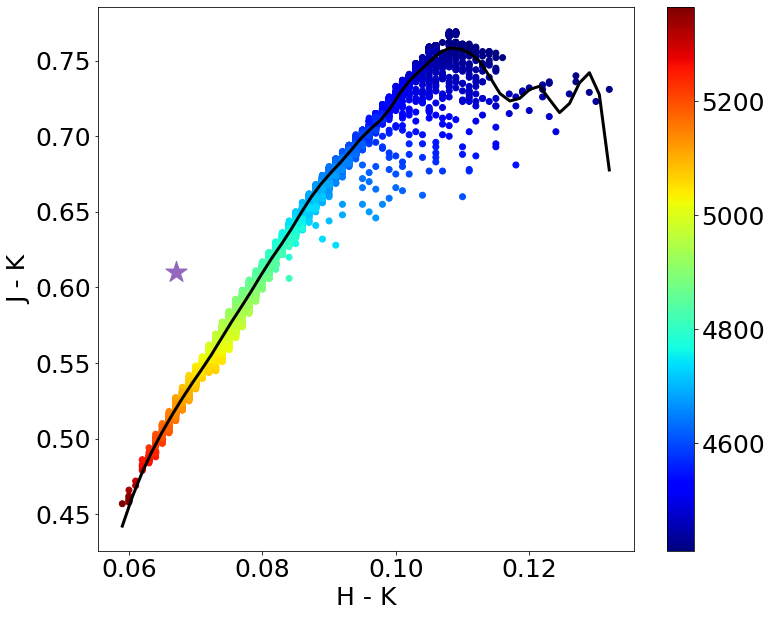

In [228]:
binnum = 25
jkhk_meds,jkhk_edges,_= binned_statistic(singfeh['Hmag']-singfeh['Ksmag'],singfeh['Jmag']-singfeh['Ksmag'],
                                    'median',bins=binnum)
jkhk_fin = np.where(np.isfinite(jkhk_meds)==True)
jkhk_meds = jkhk_meds[jkhk_fin]
jkhk_cens = (jkhk_edges[:-1]+np.diff(jkhk_edges)/2)[jkhk_fin]

hkmin = np.nanmin(singfeh['Hmag']-singfeh['Ksmag'])
hkmax = np.nanmax(singfeh['Hmag']-singfeh['Ksmag'])
hkdiff = hkmax-hkmin

jkhk_spl = IUS(jkhk_cens,jkhk_meds)

# test_ak = 0.01

plt.figure(figsize=[12,10])
plt.scatter(singfeh['Hmag']-singfeh['Ksmag'],singfeh['Jmag']-singfeh['Ksmag'],
            c=10**singfeh['logTe'],cmap='jet')
plt.colorbar()
plt.plot(np.linspace(hkmin,hkmax),jkhk_spl(np.linspace(hkmin,hkmax)),lw=3.0,c='k')
plt.scatter(star['H']-star['K'],star['J']-star['K'],c='tab:purple',marker='*',s=500)

plt.xlabel(r'H - K')
plt.ylabel(r'J - K')

plt.show()

In [229]:
def jk_hk_line(hk,obs_hk,obs_jk):
    jkhk_redvec_mod = np.array([(ccm_alav(leff['H'],3.1)/ccm_alav(leff['K'],3.1) - 1.),
                        (ccm_alav(leff['J'],3.1)/ccm_alav(leff['K'],3.1) - 1.)])
    
    jkhk_slope = jkhk_redvec_mod[1]/jkhk_redvec_mod[0]
    jkhk_inter = obs_jk-jkhk_slope*obs_hk
    
    y = jkhk_slope*hk+jkhk_inter 
    
    return y

jkhk_rootfunc = jkhk_spl(np.linspace(hkmin,hkmax)) - jk_hk_line(np.linspace(hkmin,hkmax),star['H']-star['K'],star['J']-star['K'])
jkhk_rootfunc_spl = IUS(np.linspace(hkmin,hkmax),jkhk_rootfunc)
hk_cross = jkhk_rootfunc_spl.roots()
jk_cross = jkhk_spl(hk_cross)

print('H - K cross:',hk_cross)
print('J - K cross:',jk_cross)

H - K cross: [0.08806069 0.11483514]
J - K cross: [0.66434971 0.73347474]


In [250]:
test = interp2d(singfeh['Hmag']-singfeh['Ksmag'],singfeh['Jmag']-singfeh['Ksmag'],singfeh['logTe'])
print('Interpolated Teff',10**test(hk_cross[0],jk_cross[0]))
print(star['TEFF'])

Interpolated Teff [1280.4752748]
4910.6846


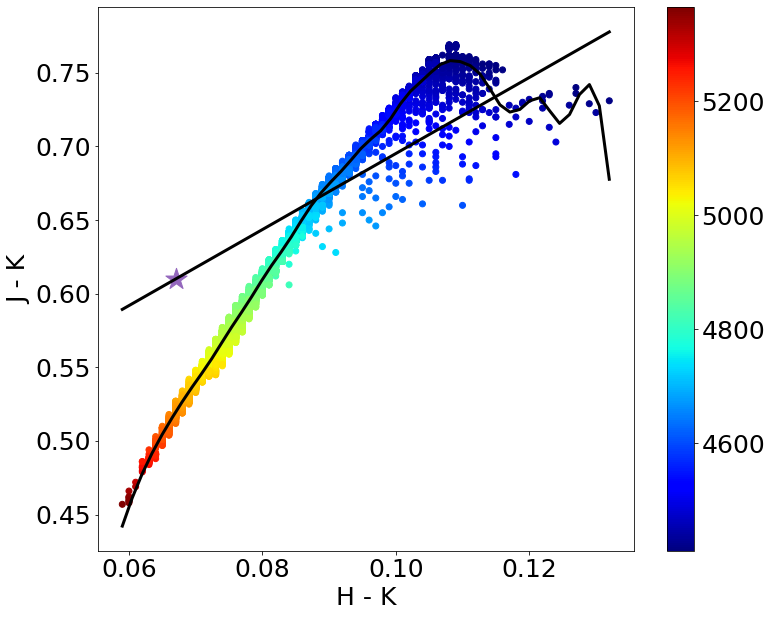

In [230]:
plt.figure(figsize=[12,10])
plt.scatter(singfeh['Hmag']-singfeh['Ksmag'],singfeh['Jmag']-singfeh['Ksmag'],
            c=10**singfeh['logTe'],cmap='jet')
plt.colorbar()
plt.plot(np.linspace(hkmin,hkmax),jkhk_spl(np.linspace(hkmin,hkmax)),lw=3.0,c='k')
plt.plot(np.linspace(hkmin,hkmax),jk_hk_line(np.linspace(hkmin,hkmax),star['H']-star['K'],star['J']-star['K']),lw=3.0,c='k')
plt.scatter(star['H']-star['K'],star['J']-star['K'],c='tab:purple',marker='*',s=500)

plt.xlabel(r'H - K')
plt.ylabel(r'J - K')

plt.show()

In [247]:
star['TEFF']

4910.6846

In [235]:
jkhk_redvec_mod = np.array([(ccm_alav(leff['H'],3.1)/ccm_alav(leff['K'],3.1) - 1.),
                            (ccm_alav(leff['J'],3.1)/ccm_alav(leff['K'],3.1) - 1.)])
jkhk_diff = np.array([hk_cross[0]-(star['H']-star['K']),jk_cross[0]-(star['J']-star['K'])])
ak_jkhk = np.dot(jkhk_redvec_mod,jkhk_diff)/np.linalg.norm(jkhk_redvec_mod)**2
print(ak_jkhk)

0.03647250511886118


In [234]:
jkhk_redvec_mod
jkhk_diff

array([-0.02106125, -0.05435006])

In [237]:
kdr17['AK_TARG'][33]

0.01961161

In [245]:
def fitz_alebv(wave):
    '''
    Fitzpatrick 1999 extinction law
    '''
    recip_anchors = np.array([0.000,0.377,0.820,1.667,1.828,2.141,2.433,3.704,3.846])#[:-2]
    alebv_anchors = np.array([0.000,0.265,0.829,2.688,3.055,3.806,4.315,6.265,6.591])#[:-2]

    x=1/wave
    spl = interp1d(recip_anchors,alebv_anchors)
    alebv = spl(x)
    return alebv

akamu = fitz_alebv(leff['K'])/fitz_alebv(1)
akamu*(kdr17['SFD_EBV'][33]*0.78/1.32)

0.01160503795745042

In [246]:
kdr17['SFD_EBV'][33]*ak_ebv

0.02426100360773736

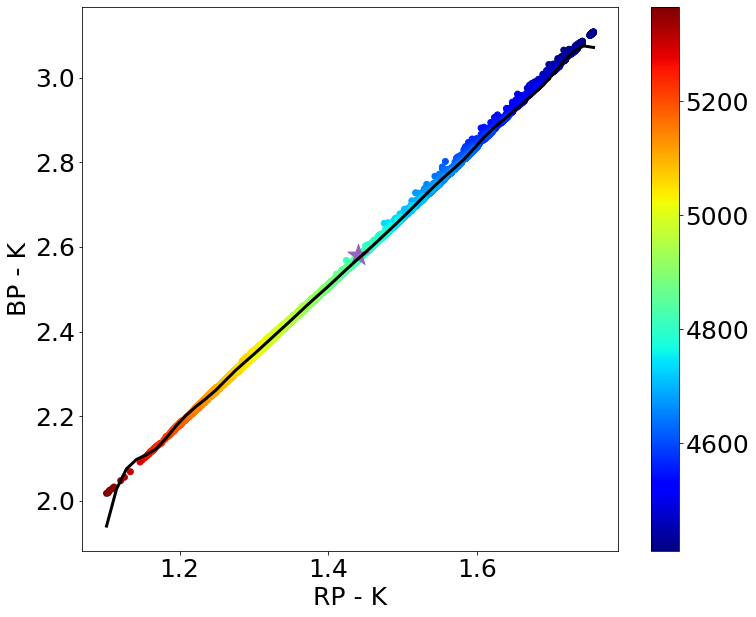

In [262]:
binnum = 25
bpkrpk_meds,bpkrpk_edges,_= binned_statistic(singfeh['G_RPmag']-singfeh['Ksmag'],singfeh['G_BPmag']-singfeh['Ksmag'],
                                    'median',bins=binnum)
bpkrpk_fin = np.where(np.isfinite(bpkrpk_meds)==True)
bpkrpk_meds = bpkrpk_meds[bpkrpk_fin]
bpkrpk_cens = (bpkrpk_edges[:-1]+np.diff(bpkrpk_edges)/2)[bpkrpk_fin]

rpkmin = np.nanmin(singfeh['G_RPmag']-singfeh['Ksmag'])
rpkmax = np.nanmax(singfeh['G_RPmag']-singfeh['Ksmag'])
rpkdiff = hkmax-hkmin

bpkrpk_spl = IUS(bpkrpk_cens,bpkrpk_meds)

# test_ak = 0.01

plt.figure(figsize=[12,10])
plt.scatter(singfeh['G_RPmag']-singfeh['Ksmag'],singfeh['G_BPmag']-singfeh['Ksmag'],
            c=10**singfeh['logTe'],cmap='jet')
plt.colorbar()
plt.plot(np.linspace(hkmin,hkmax),bpkrpk_spl(np.linspace(hkmin,hkmax)),lw=3.0,c='k')
plt.scatter(star['GAIAEDR3_PHOT_RP_MEAN_MAG']-star['K'],
            star['GAIAEDR3_PHOT_BP_MEAN_MAG']-star['K'],c='tab:purple',marker='*',s=500)

plt.xlabel(r'RP - K')
plt.ylabel(r'BP - K')

plt.show()

In [275]:
def bp_rpk_line(rpk,obs_rpk,obs_bp):
    bpkrpk_redvec_mod = np.array([(ccm_alav(leff['RP'],3.1)/ccm_alav(leff['K'],3.1) - 1.),
                        (ccm_alav(leff['BP'],3.1)/ccm_alav(leff['K'],3.1) - 1.)])
    
    bpkrpk_slope = bpkrpk_redvec_mod[1]/bpkrpk_redvec_mod[0]
    bpkrpk_inter = obs_bp-bpkrpk_slope*obs_rpk
    
    y = bpkrpk_slope*rpk+bpkrpk_inter 
    
    return y

bpkrpk_rootfunc = bpkrpk_spl(np.linspace(rpkmin,rpkmax)) - bp_rpk_line(np.linspace(rpkmin,rpkmax),star['GAIAEDR3_PHOT_RP_MEAN_MAG']-star['K'],star['GAIAEDR3_PHOT_BP_MEAN_MAG']-star['K'])
bpkrpk_rootfunc_spl = IUS(np.linspace(rpkmin,rpkmax),bpkrpk_rootfunc)
rpk_cross = bpkrpk_rootfunc_spl.roots()
bpk_cross = bpkrpk_spl(rpk_cross)

print('RP - K cross:',rpk_cross)
print('BP - K cross:',bp_cross)

RP - K cross: [1.1151757  1.33870865]
BP - K cross: [2.02697155 2.40895383]


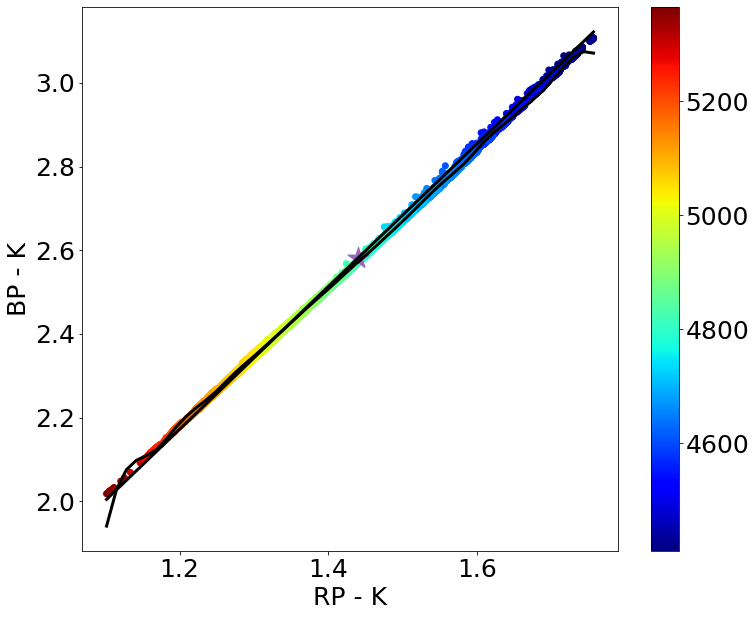

In [279]:
plt.figure(figsize=[12,10])
plt.scatter(singfeh['G_RPmag']-singfeh['Ksmag'],singfeh['G_BPmag']-singfeh['Ksmag'],
            c=10**singfeh['logTe'],cmap='jet')
plt.colorbar()
plt.plot(np.linspace(rpkmin,rpkmax),bpkrpk_spl(np.linspace(rpkmin,rpkmax)),lw=3.0,c='k')
plt.plot(np.linspace(rpkmin,rpkmax),bp_rpk_line(np.linspace(rpkmin,rpkmax),star['GAIAEDR3_PHOT_RP_MEAN_MAG']-star['K'],star['GAIAEDR3_PHOT_BP_MEAN_MAG']-star['K']),lw=3.0,c='k')
plt.scatter(star['GAIAEDR3_PHOT_RP_MEAN_MAG']-star['K'],star['GAIAEDR3_PHOT_BP_MEAN_MAG']-star['K'],c='tab:purple',marker='*',s=500)

plt.xlabel(r'RP - K')
plt.ylabel(r'BP - K')

plt.show()

In [278]:
bpkrpk_redvec_mod = np.array([(ccm_alav(leff['RP'],3.1)/ccm_alav(leff['K'],3.1) - 1.),
                            (ccm_alav(leff['BP'],3.1)/ccm_alav(leff['K'],3.1) - 1.)])
bpkrpk_diff = np.array([rpk_cross[1]-(star['GAIAEDR3_PHOT_RP_MEAN_MAG']-star['K']),bpk_cross[1]-(star['GAIAEDR3_PHOT_BP_MEAN_MAG']-star['K'])])
ak_bpkrpk = np.dot(bpkrpk_redvec_mod,bpkrpk_diff)/np.linalg.norm(bpkrpk_redvec_mod)**2
print(ak_bpkrpk)

-0.021993523896311568


In [ ]:
# something not right first both intersections bad second better for some reason

# Using Fitzpatrick 

In [252]:
def jk_hk_line2(hk,obs_hk,obs_jk):
    jkhk_redvec_mod = np.array([(fitz_alebv(leff['H'])/fitz_alebv(leff['K']) - 1.),
                        (fitz_alebv(leff['J'])/fitz_alebv(leff['K']) - 1.)])
    
    jkhk_slope = jkhk_redvec_mod[1]/jkhk_redvec_mod[0]
    jkhk_inter = obs_jk-jkhk_slope*obs_hk
    
    y = jkhk_slope*hk+jkhk_inter 
    
    return y

jkhk_rootfunc2 = jkhk_spl(np.linspace(hkmin,hkmax)) - jk_hk_line2(np.linspace(hkmin,hkmax),star['H']-star['K'],star['J']-star['K'])
jkhk_rootfunc_spl2 = IUS(np.linspace(hkmin,hkmax),jkhk_rootfunc2)
hk_cross2 = jkhk_rootfunc_spl2.roots()
jk_cross2 = jkhk_spl(hk_cross2)

print('H - K cross:',hk_cross)
print('J - K cross:',jk_cross)

H - K cross: [0.08806069 0.11483514]
J - K cross: [0.66434971 0.73347474]


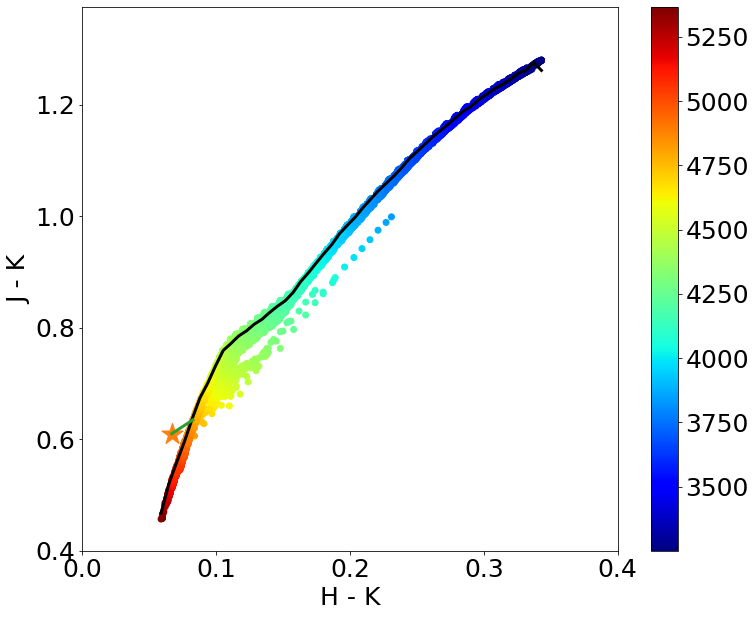

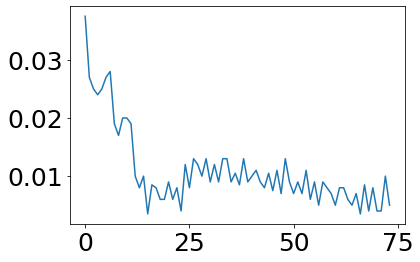

In [137]:
binnum = 75
jkhk,_,_= binned_statistic(singfeh['Hmag']-singfeh['Ksmag'],singfeh['Jmag']-singfeh['Ksmag'],'median',bins=binnum)

hkmin = np.nanmin(singfeh['Hmag']-singfeh['Ksmag'])
hkmax = np.nanmax(singfeh['Hmag']-singfeh['Ksmag'])
hkdiff = hkmax-hkmin

jkhk_spl = IUS(np.arange(hkmin,hkmax,hkdiff/binnum),jkhk)

test_ak = 0.01

plt.figure(figsize=[12,10])
plt.scatter(singfeh['Hmag']-singfeh['Ksmag'],singfeh['Jmag']-singfeh['Ksmag'],
            c=10**singfeh['logTe'],cmap='jet')
plt.colorbar()
# plt.plot(np.arange(hkmin,hkmax,hkdiff/binnum),jkhk,lw=3.0,c='k')
plt.plot(np.linspace(hkmin,hkmax),jkhk_spl(np.linspace(hkmin,hkmax)),lw=3.0,c='k')
plt.scatter(star['H']-star['K'],star['J']-star['K'],c='tab:orange',marker='*',s=500)
plt.plot([star['H']-star['K'],star['H']-star['K']+(1.5773727079807909)*test_ak],
         [star['J']-star['K'],star['J']-star['K']+(2.490197238236482)*test_ak],c='tab:green',lw=3.0)

plt.xlabel(r'H - K')
plt.ylabel(r'J - K')

plt.xlim(0,0.4)
plt.ylim(0.4,1.375)

plt.show()

plt.plot(np.diff(jkhk))

In [123]:
salfeh

array([-0.15593529,  0.21227828,  0.0607838 , ...,  0.03759681,
       -0.04480536, -0.01123895], dtype=float32)

In [135]:
def cc_ak_teff(specteff,feh,obsphot,isochrones):
    '''
    Calculate the Ak extinction and Teff using color-color space with K as the fiducial band

    Inputs:
    ------
        specteff: Spectroscopic teff
        feh: Salaris corrected [Fe/H]
        obsphot: observed photometry

    Output:
    ------

    '''
    
    iso_ = isochrones[np.where((isochrones['logTe']>=np.log10(specteff-200))&
                               (isochrones['logTe']<=np.log10(specteff+200))&
                               (isochrones['MH']==closest(isochrones['MH'],feh)))]
    
    rpkmin = np.nanmin(iso_['G_RPmag']-iso_['Ksmag'])
    rpkmax = np.nanmax(iso_['G_RPmag']-iso_['Ksmag'])
    rpkdiff = rpkmax-rpkmin
    new_rpk = np.linspace(rpkmin,rpkmax)
    
    hkmin = np.nanmin(iso_['Hmag']-iso_['Ksmag'])
    hkmax = np.nanmax(iso_['Hmag']-iso_['Ksmag'])
    hkdiff = hkmax-hkmin
    new_hk = np.linspace(hkmin,hkmax)
    
    obs_bpk = obsphot[0]-obsphot[-1]
    obs_rpk = obsphot[1]-obsphot[-1]
    obs_jk = obsphot[2]-obsphot[-1]
    obs_hk = obsphot[3]-obsphot[-1]
    
    wavs = {'G_BPmag':0.5387,'G_RPmag':0.7667,'Jmag':1.2345,'Hmag':1.6393,'Ksmag':2.1757}
    
    # interpolate color-color to get the locus
    binnum = 75
    bpkrpk_bin,_,_ = binned_statistic(iso_['G_RPmag']-iso_['Ksmag'],iso_['G_BPmag']-iso_['Ksmag'],
                                      'median',bins=binnum)
    jkhk_bin,_,_ = binned_statistic(iso_['Hmag']-iso_['Ksmag'],iso_['Jmag']-iso_['Ksmag'],
                                    'median',bins=binnum)
    
    bpkrpk_spl = IUS(np.arange(rpkmin,rpkmax,rpkdiff/binnum),bpkrpk_bin)
    jkhk_spl = IUS(np.arange(hkmin,hkmax,hkdiff/binnum),jkhk_bin)
    
    bpkrpk_locus = bpkrpk_spl(new_rpk)
    jkhk_locus = jkhk_spl(new_hk)
    
    # line along the reddening vector
    def line(x,m,b):
        y = m*x+b
        return y
    
    bpkrpk_redvec_mod = np.array([(ccm_alav(wavs['G_RPmag'],3.1)/ccm_alav(wavs['Ksmag'],3.1) - 1.),
                                  (ccm_alav(wavs['G_BPmag'],3.1)/ccm_alav(wavs['Ksmag'],3.1) - 1.)])
    jkhk_redvec_mod = np.array([(ccm_alav(wavs['Hmag'],3.1)/ccm_alav(wavs['Ksmag'],3.1) - 1.),
                                  (ccm_alav(wavs['Jmag'],3.1)/ccm_alav(wavs['Ksmag'],3.1) - 1.)])
    
    bpkrpk_slope = bpkrpk_redvec_mod[1]/bpkrpk_redvec_mod[0]
    jkhk_slope = jkhk_redvec_mod[1]/jkhk_redvec_mod[0]
    
    bpkrpk_inter = obs_bpk-bpkrpk_slope*obs_rpk
    jkhk_inter = obs_jk-bpkrpk_slope*obs_hk
    
    # find crossing point
    bpkrpk_rootfunc = bpkrpk_locus - line(new_rpk,m=bpkrpk_slope,b=bpkrpk_inter)
    bpkrpk_rootfunc_spl = IUS(new_rpk,bpkrpk_rootfunc)
    rpk_cross = bpkrpk_rootfunc_spl.roots()
    bpk_cross = bpkrpk_spl(rpk_cross)
    
    print(rpk_cross)
    
    jkhk_rootfunc = jkhk_locus - line(new_hk,m=jkhk_slope,b=jkhk_inter)
    jkhk_rootfunc_spl = IUS(new_hk,jkhk_rootfunc)
    hk_cross = jkhk_rootfunc_spl.roots()
    jk_cross = jkhk_spl(rpk_cross)
    
    # AK
    bpkrpk_diff = np.array([obs_rpk-rpk_cross,obs_bpk-bpk_cross])
    ak_bpkrpk = np.dot(bpkrpk_redvec_mod,bpkrpk_diff)/np.linalg.norm(bpkrpk_redvec_mod)**2
    
    jkhk_diff = np.array([obs_hk-hk_cross,obs_jk-jk_cross])
    ak_jkhk = np.dot(jkhk_redvec_mod,jkhk_diff)/np.linalg.norm(jkhk_redvec_mod)**2
    
    ak = np.median([ak_bpkrpk,ak_jkhk])
    
    return ak
    

In [136]:
cc_ak_teff(kdr17['TEFf'][33],salfeh[33],np.array([kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][33],
                               kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][33],
                               kdr17['J'][33],kdr17['H'][33],kdr17['K'][33]]),
           massive)

[]


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

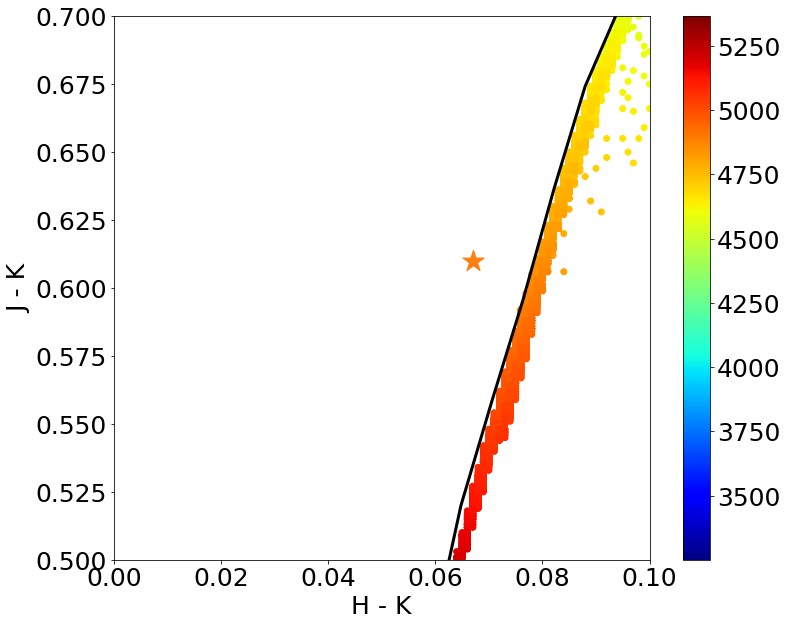

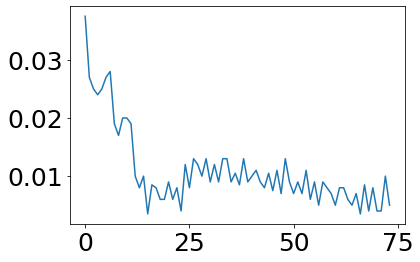

In [120]:
binnum = 75
jkhk,_,_= binned_statistic(singfeh['Hmag']-singfeh['Ksmag'],singfeh['Jmag']-singfeh['Ksmag'],'median',bins=binnum)

hkmin = np.nanmin(singfeh['Hmag']-singfeh['Ksmag'])
hkmax = np.nanmax(singfeh['Hmag']-singfeh['Ksmag'])
hkdiff = hkmax-hkmin

jkhk_spl = IUS(np.arange(hkmin,hkmax,hkdiff/binnum),jkhk)

test_ak = 0.01

plt.figure(figsize=[12,10])
plt.scatter(singfeh['Hmag']-singfeh['Ksmag'],singfeh['Jmag']-singfeh['Ksmag'],
            c=10**singfeh['logTe'],cmap='jet')
plt.colorbar()
# plt.plot(np.arange(hkmin,hkmax,hkdiff/binnum),jkhk,lw=3.0,c='k')
plt.plot(np.linspace(hkmin,hkmax),jkhk_spl(np.linspace(hkmin,hkmax)),lw=3.0,c='k')
plt.scatter(star['H']-star['K'],star['J']-star['K'],c='tab:orange',marker='*',s=500)

plt.xlabel(r'H - K')
plt.ylabel(r'J - K')

plt.ylim(0.5,0.7)
plt.xlim(0.,0.1)

plt.show()

plt.plot(np.diff(jkhk))

In [105]:
(ccm_alav(leff['J'],3.1)/ccm_alav(leff['K'],3.1),ccm_alav(leff['H'],3.1)/ccm_alav(leff['K'],3.1))

(2.490197238236482, 1.5773727079807909)

In [106]:
i = 33 
te = np.array([kdr17['TEFF'][i],kdr17['TEFF_ERR'][i]])
ab = np.array([[kdr17['FE_H'][i],apoafe[i]],
               [kdr17['FE_H_ERR'][i],apoafe_err[i]]]).T
op = np.array([[kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                kdr17['J'][i],kdr17['H'][i],
                kdr17['K'][i]],
               [bperr[i],rperr[i],kdr17['J_ERR'][i],
                kdr17['H_ERR'][i],kdr17['K_ERR'][i]]]).T
di = (1/kdr17['GAIAEDR3_PARALLAX'][i])*1000

CalcAge = Aetas(te,ab,op,di,massive,rv=3.1)
ak, photteff = CalcAge.color_color_ak_teff()

KeyboardInterrupt: 

In [107]:
redvec['jkhk']

array([1.57737271, 2.49019724])

In [117]:
def jkhk_ak_teff(obs2mass,redvec,isochrones):
    '''
    Calculate the Ak extinction and Teff using color-color space with K as the fiducial band

    Output:
    ------

    '''
    #0: J
    #1: H
    #2: K
    
    obs_jk = obs2mass[0]-obs2mass[2]
    obs_hk = obs2mass[1]-obs2mass[2]
    
    # line along reddening vector
    def line(x,m,b):
        y = m*x+b
        return y
    
    slope = (redvec[1]-1.)/(redvec[0]-1.)
    inter = obs_jk-slope*obs_hk

    xs = isochrones['Hmag']-isochrones['Ksmag']
    ys = isochrones['Jmag']-isochrones['Ksmag']
    
    # need same H - K values for finding the crossing point
    new_xs = np.linspace(min(xs),max(xs))
    
    # find locus
    jkhk_spl = interp1d(xs,ys)
    jkhk_locus = jkhk_spl(new_xs)
    
    # find crossing of line along the reddening vector and locus
    rootfunc = jkhk_locus - line(new_xs,m=slope,b=inter)
    rootfunc_spl = IUS(new_xs,rootfunc)
    
    # intrinsic colors
    hk_cross = rootfunc_spl.roots()
    jk_cross = jkhk_spl(hk_cross)
    
    print(hk_cross)
    
    # AK
    color_diff = np.array([obs_jk-jk_cross,obs_hk-hk_cross])
    redvec_mod = np.array([redvec[1]-1.,redvec[0]-1.])
    
    ak = np.dot(redvec_mod,color_diff)/np.linalg.norm(redvec_mod)**2
    
    return ak

In [121]:
jkhk_ak_teff(np.array([kdr17['J'][33],kdr17['H'][33],kdr17['K'][33]]),redvec['jkhk'],singfeh)

[0.09009378 0.22373186 0.23032084 0.30234427]


array([-0.0374394 , -0.29040566, -0.30069088, -0.40740428])

In [109]:
redvec

{'gpkrpk': array([8.8544004, 5.5963515]),
 'gpkjk': array([8.8544004 , 2.49019724]),
 'gpkhk': array([8.8544004 , 1.57737271]),
 'rpkjk': array([5.5963515 , 2.49019724]),
 'rpkhk': array([5.5963515 , 1.57737271]),
 'jkhk': array([1.57737271, 2.49019724])}

In [10]:
kasc_ak_sep = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_age_sep = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_chi_sep = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_rms_sep = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_mass_sep = 999999.0*np.ones(len(np.squeeze(ageevs)))

kasc_ak_sfd = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_age_sfd = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_chi_sfd = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_rms_sfd = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_mass_sfd = 999999.0*np.ones(len(np.squeeze(ageevs)))

kasc_ak = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_age = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_chi = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_rms = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_mass = 999999.0*np.ones(len(np.squeeze(ageevs)))

kasc_parsec_age = 999999.0*np.ones(len(np.squeeze(ageevs)))


def mass_2_age_PARSEC(mass,salfeh,isochrones):
    '''
    Inputs:
    ------
        mass: star mass in Msun
        salfeh: Salaris corrected [Fe/H]
        isochrones: table of PARSEC isochrones
    
    Output:
    ------
        age: age in Gyr
    '''
    
    feh_lo,feh_hi = neighbors(isochrones['MH'],salfeh)
    
    iso_lo = isochrones[np.where(isochrones['MH']==feh_lo)]
    iso_hi = isochrones[np.where(isochrones['MH']==feh_hi)]
    
    try:
        # lower [Fe/H]
        sidx_lo = np.argsort(iso_lo['Mass'])
        smass_lo = iso_lo['Mass'][sidx_lo]
        _,uidx_lo = np.unique(smass_lo,return_index=True)
        smass_lo = smass_lo[uidx_lo]
        sage_lo = 10**iso_lo['logAge'][sidx_lo][uidx_lo]/10**9

        spl_lo = interp1d(smass_lo,sage_lo)

        # higher [Fe/H]
        sidx_hi = np.argsort(iso_hi['Mass'])
        smass_hi = iso_hi['Mass'][sidx_hi]
        _,uidx_hi = np.unique(smass_hi,return_index=True)
        smass_hi = smass_hi[uidx_hi]
        sage_hi = 10**iso_hi['logAge'][sidx_hi][uidx_hi]/10**9

        spl_hi = interp1d(smass_hi,sage_hi)

        # final spline
        final_spl = interp1d([feh_lo,feh_hi],[spl_lo(mass),spl_hi(mass)])
        age = final_spl(salfeh)
        return age
    except:
        return 999999.0

for i in tqdm_notebook(range(len(np.squeeze(ageevs)))):
    
    # Initialize Aetas 
    te = np.array([kdr17['TEFF'][i],kdr17['TEFF_ERR'][i]])
    ab = np.array([[kdr17['FE_H'][i],apoafe[i]],
                   [kdr17['FE_H_ERR'][i],apoafe_err[i]]]).T
    op = np.array([[kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                    kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                    kdr17['J'][i],kdr17['H'][i],
                    kdr17['K'][i]],
                   [bperr[i],rperr[i],kdr17['J_ERR'][i],
                    kdr17['H_ERR'][i],kdr17['K_ERR'][i]]]).T
    di = (1/kdr17['GAIAEDR3_PARALLAX'][i])*1000

    CalcAge = Aetas(te,ab,op,di,massive,rv=3.1)
    
    # ak age separate
    kasc_ak_sep[i], _ = CalcAge.extinction()
    vals_sep = CalcAge.get_age()
    kasc_age_sep[i] = vals_sep[0]
    kasc_chi_sep[i] = vals_sep[1]
    kasc_rms_sep[i] = vals_sep[2]
    kasc_mass_sep[i] = CalcAge.get_mass(vals_sep[0])
    
    # forced SFD
    kasc_ak_sfd[i] = kdr17['SFD_EBV'][i]*ak_ebv
    CalcAge.ak = kdr17['SFD_EBV'][i]*ak_ebv
    vals_sfd = CalcAge.get_age()
    kasc_age_sfd[i] = vals_sfd[0]
    kasc_chi_sfd[i] = vals_sfd[1]
    kasc_rms_sfd[i] = vals_sfd[2]
    kasc_mass_sfd[i] = CalcAge.get_mass(vals_sfd[0])
    
    
    # ak age together
    vals = CalcAge.get_ak_age_curvefit()
    kasc_ak[i] = vals[0]
    kasc_age[i] = vals[1]
    kasc_chi[i] = vals[2]
    kasc_rms[i] = vals[3]
    kasc_mass[i] = CalcAge.get_mass(vals[1])
    
    kasc_parsec_age[i] = mass_2_age_PARSEC(k3dr17['Mass'][i],salfeh[i],massive)

<ipython-input-10-586550000e5c>:66: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(np.squeeze(ageevs)))):


In [42]:
### save ages to fits file
from astropy.table import Table, Column

cname = Column(kdr17['APOGEE_ID'], name='NAME')
cage = Column(kasc_age,name='AGE')
cpage = Column(kasc_parsec_age,name='PARSEC_AGE')
cak = Column(kasc_ak,name='AK')
cmass = Column(kasc_mass,name='MASS')
cchi = Column(kasc_chi,name='CHI')
crms = Column(kasc_rms,name='RMSE')

cage_sfd = Column(kasc_age_sep,name='AGE_SFD')
cak_sfd = Column(kasc_ak_sep,name='AK_SFD')
cmass_sfd = Column(kasc_mass_sep,name='MASS_SFD')
cchi_sfd = Column(kasc_chi_sep,name='CHI_SFD')
crms_sfd = Column(kasc_rms_sep,name='RMSE_SFD')

cage_sep = Column(kasc_age_sep,name='AGE_SEP')
cak_sep = Column(kasc_ak_sep,name='AK_SEP')
cmass_sep = Column(kasc_mass_sep,name='MASS_SEP')
cchi_sep = Column(kasc_chi_sep,name='CHI_SEP')
crms_sep = Column(kasc_rms_sep,name='RMSE_SEP')


agetable = Table([cname,cak,cage,cmass,cchi,crms,cak_sep,cage_sep,cmass_sep,cchi_sep,crms_sep,
                  cak_sfd,cage_sfd,cmass_sfd,cchi_sfd,crms_sfd,cpage])
agetable.write('aetas_apokasc_dr17_results.fits', format='fits', overwrite=True)

In [43]:
agetab = fits.getdata('aetas_apokasc_dr17_results.fits')

In [66]:
# Upturns
upturn = np.where(agetab['AGE']-upturn10Gyr(agetab['PARSEC_AGE'])>0)
upturn_sep = np.where(agetab['AGE_SEP']-upturn10Gyr(agetab['PARSEC_AGE'])>0)
upturn_sfd = np.where(agetab['AGE_SFD']-upturn10Gyr(agetab['PARSEC_AGE'])>0)
upturn_comsfd = np.where((agetab['AGE']-upturn10Gyr(agetab['PARSEC_AGE'])>0)&
                         (agetab['AGE_SFD']-upturn10Gyr(agetab['PARSEC_AGE'])>0))

# Old APOKASC
oldkasc = np.where(agetab['AGE']-oldapokasc(agetab['PARSEC_AGE'])<0)
oldkasc_sep = np.where(agetab['AGE_SEP']-oldapokasc(agetab['PARSEC_AGE'])<0)
oldkasc_sfd = np.where(agetab['AGE_SFD']-oldapokasc(agetab['PARSEC_AGE'])<0)

oldkasc_comsfd = np.where((agetab['AGE']-oldapokasc(agetab['PARSEC_AGE'])<0)&
                          (agetab['AGE_SFD']-oldapokasc(agetab['PARSEC_AGE'])<0))

# Good
good = np.where((agetab['AGE']-upturn10Gyr(agetab['PARSEC_AGE'])<0)&
                (agetab['AGE']-oldapokasc(agetab['PARSEC_AGE'])>0)) 

good_sep = np.where((agetab['AGE_SEP']-upturn10Gyr(agetab['PARSEC_AGE'])<0)&
                    (agetab['AGE_SEP']-oldapokasc(agetab['PARSEC_AGE'])>0))

good_sfd = np.where((agetab['AGE_SFD']-upturn10Gyr(agetab['PARSEC_AGE'])<0)&
                    (agetab['AGE_SFD']-oldapokasc(agetab['PARSEC_AGE'])>0))

good_comsfd = np.where((agetab['AGE']-upturn10Gyr(agetab['PARSEC_AGE'])<0)&
                       (agetab['AGE_SFD']-upturn10Gyr(agetab['PARSEC_AGE'])<0)&
                       (agetab['AGE']-oldapokasc(agetab['PARSEC_AGE'])>0)&
                       (agetab['AGE_SFD']-oldapokasc(agetab['PARSEC_AGE'])>0))

In [67]:
len(np.squeeze(good_comsfd))

5070

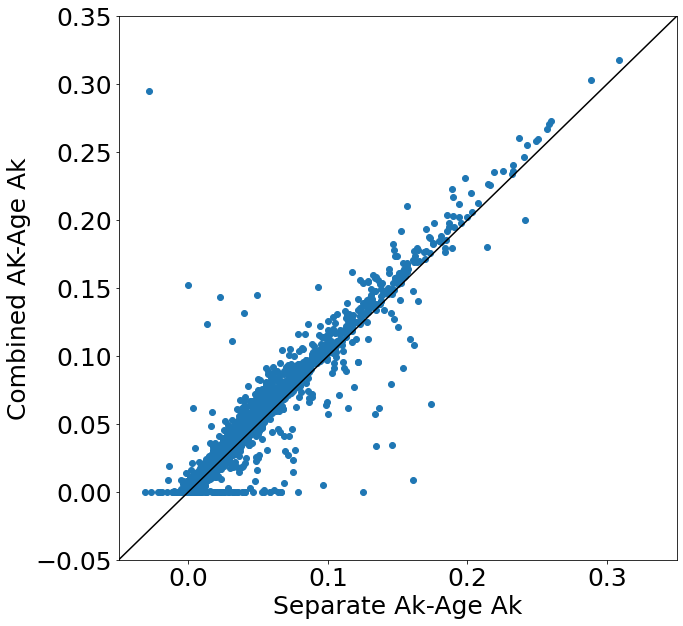

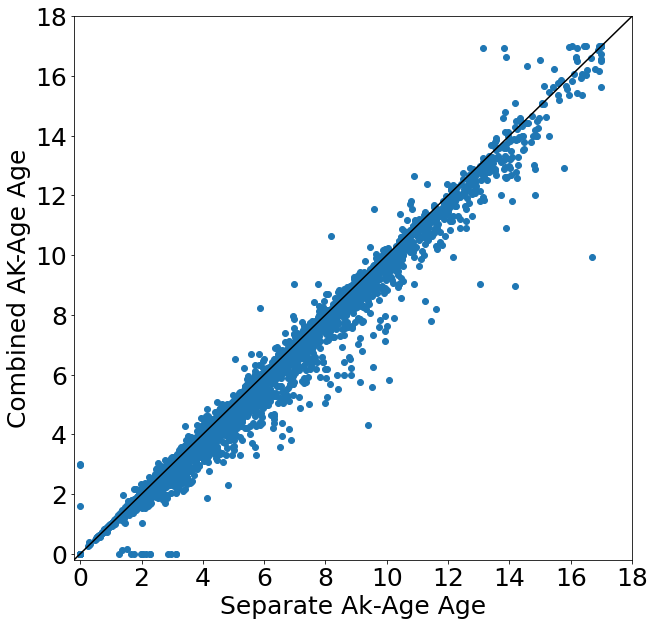

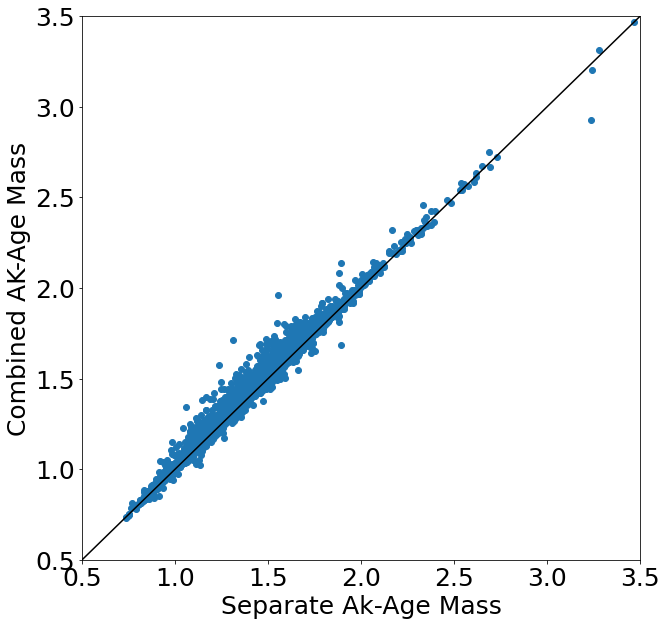

In [46]:
### Extinctions
plt.figure(figsize=[10,10])
plt.scatter(agetab['AK_SEP'],agetab['AK'])
plt.plot([-0.1,0.4],[-0.1,0.4],c='k')
plt.ylim(-0.05,0.35)
plt.xlim(-0.05,0.35)

plt.xlabel(r'Separate Ak-Age Ak')
plt.ylabel(r'Combined AK-Age Ak')

plt.savefig('compare_ak_sep.pdf',dpi=300,bbox_inches='tight')
plt.show()

### Ages
plt.figure(figsize=[10,10])
plt.scatter(agetab['AGE_SEP'],agetab['AGE'])
plt.plot([-0.2,18],[-0.2,18],c='k')
plt.ylim(-0.2,18)
plt.xlim(-0.2,18)

plt.xticks(range(19)[::2])
plt.yticks(range(19)[::2])

plt.xlabel(r'Separate Ak-Age Age')
plt.ylabel(r'Combined AK-Age Age')

plt.savefig('compare_age_sep.pdf',dpi=300,bbox_inches='tight')
plt.show()

### Ages
plt.figure(figsize=[10,10])
plt.scatter(agetab['MASS_SEP'],agetab['MASS'])
plt.plot([-0.2,18],[-0.2,18],c='k')
plt.ylim(0.5,3.5)
plt.xlim(0.5,3.5)

plt.xlabel(r'Separate Ak-Age Mass')
plt.ylabel(r'Combined AK-Age Mass')

plt.savefig('compare_mass_sep.pdf',dpi=300,bbox_inches='tight')
plt.show()

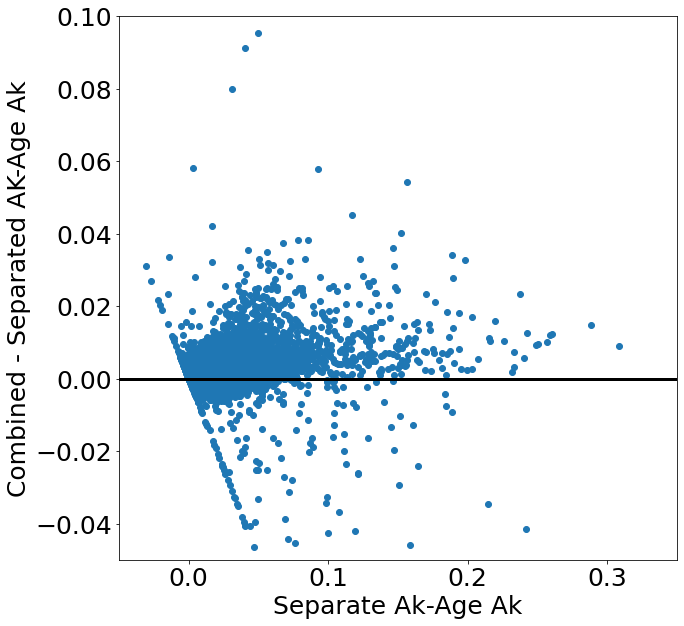

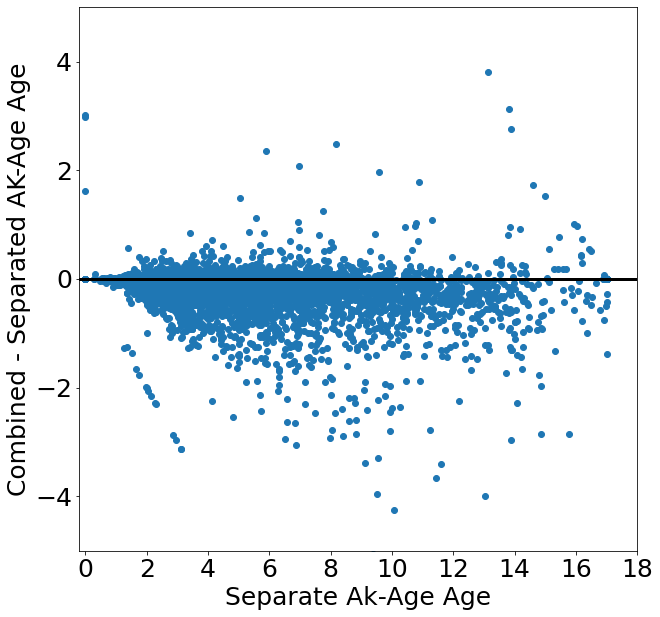

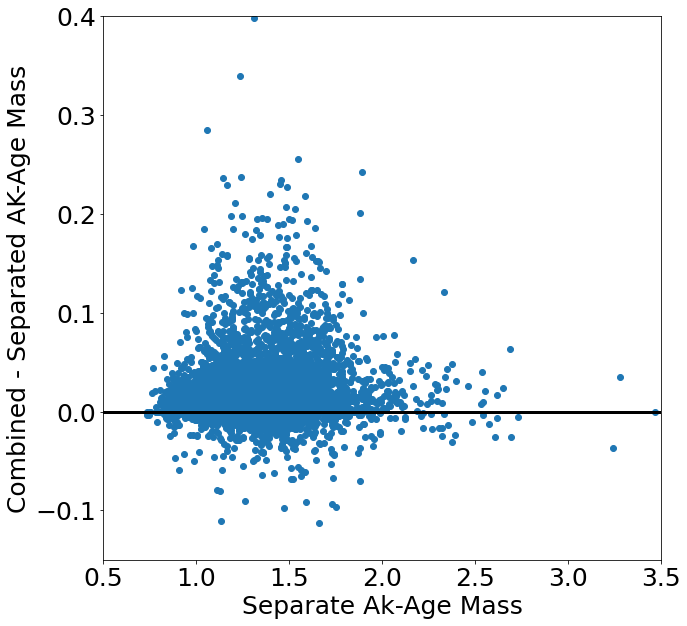

In [47]:
### Extinctions
plt.figure(figsize=[10,10])
plt.scatter(agetab['AK_SEP'],agetab['AK']-agetab['AK_SEP'])
plt.axhline(0.,c='k',lw=3.)
plt.ylim(-0.05,0.1)
plt.xlim(-0.05,0.35)

plt.xlabel(r'Separate Ak-Age Ak')
plt.ylabel(r'Combined - Separated AK-Age Ak')

plt.savefig('resid_ak_sep.pdf',dpi=300,bbox_inches='tight')
plt.show()

### Ages
plt.figure(figsize=[10,10])
plt.scatter(agetab['AGE_SEP'],agetab['AGE']-agetab['AGE_SEP'])
plt.axhline(0.,c='k',lw=3.)
plt.ylim(-5,5)
plt.xlim(-0.2,18)

plt.xticks(range(19)[::2])

plt.xlabel(r'Separate Ak-Age Age')
plt.ylabel(r'Combined - Separated AK-Age Age')

plt.savefig('resid_age_sep.pdf',dpi=300,bbox_inches='tight')
plt.show()

### Masses
plt.figure(figsize=[10,10])
plt.scatter(agetab['MASS_SEP'],agetab['MASS']-agetab['MASS_SEP'])
plt.axhline(0.,c='k',lw=3.)
plt.ylim(-0.15,0.4)
plt.xlim(0.5,3.5)

plt.xlabel(r'Separate Ak-Age Mass')
plt.ylabel(r'Combined - Separated AK-Age Mass')

plt.savefig('resid_mass_sep.pdf',dpi=300,bbox_inches='tight')
plt.show()

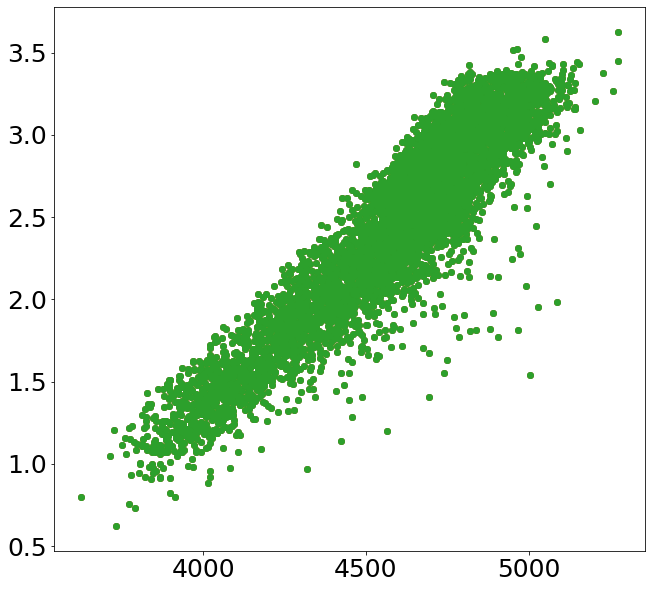

In [48]:
plt.figure(figsize=[36,10])
plt.subplot(131)
plt.scatter(kdr17['TEFF'],kdr17['LOGG'])
plt.scatter(kdr17['TEFF'],kdr17['LOGG'])
plt.scatter(kdr17['TEFF'],kdr17['LOGG'])

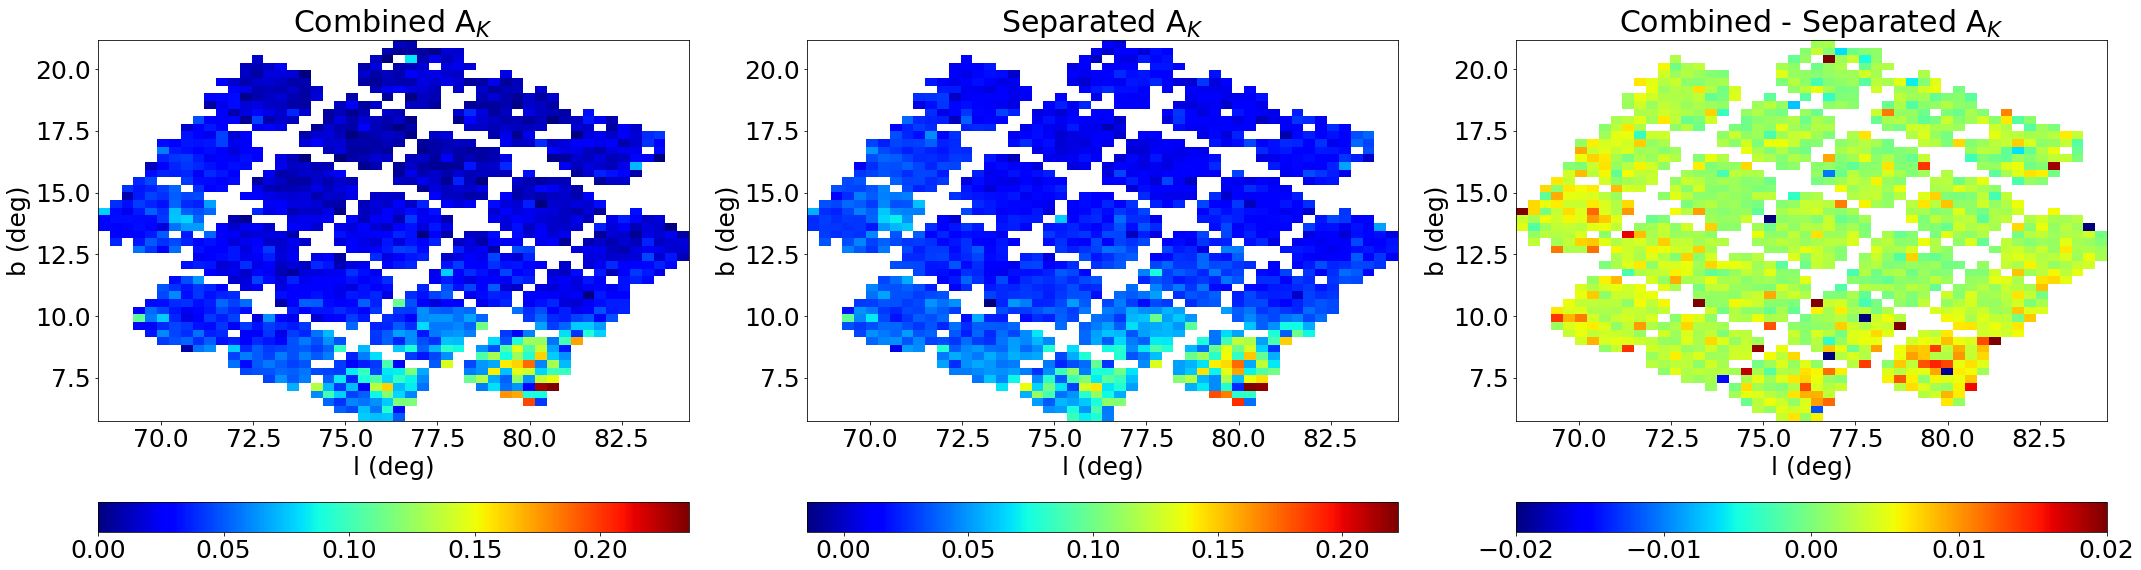

In [49]:
from scipy.stats import binned_statistic_2d
plt.figure(figsize=[36,10])

fincut = np.where((np.isfinite(agetab['AK'])==True)&(np.isfinite(agetab['AK_SEP'])==True)&
                  (agetab['AK']<10.)&(agetab['AK_SEP']<10.))

plt.subplot(131)
ret = binned_statistic_2d(kdr17['GLON'][fincut],kdr17['GLAT'][fincut],agetab['AK'][fincut],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet')

plt.colorbar(orientation='horizontal')

plt.title(r'Combined A$_K$')
plt.xlabel(r'l (deg)')
plt.ylabel(r'b (deg)')

plt.subplot(132)
ret = binned_statistic_2d(kdr17['GLON'][fincut],kdr17['GLAT'][fincut],agetab['AK_SEP'][fincut],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet')

plt.colorbar(orientation='horizontal')

plt.title(r'Separated A$_K$')
plt.xlabel(r'l (deg)')
plt.ylabel(r'b (deg)')

plt.subplot(133)
ret = binned_statistic_2d(kdr17['GLON'][fincut],kdr17['GLAT'][fincut],(agetab['AK']-agetab['AK_SEP'])[fincut],
                          'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=-0.02,vmax=0.02)

plt.colorbar(orientation='horizontal')

plt.title(r'Combined - Separated A$_K$')
plt.xlabel(r'l (deg)')
plt.ylabel(r'b (deg)')

plt.savefig('compare_ext_map_sep.pdf',dpi=300,bbox_inches='tight')
plt.show()

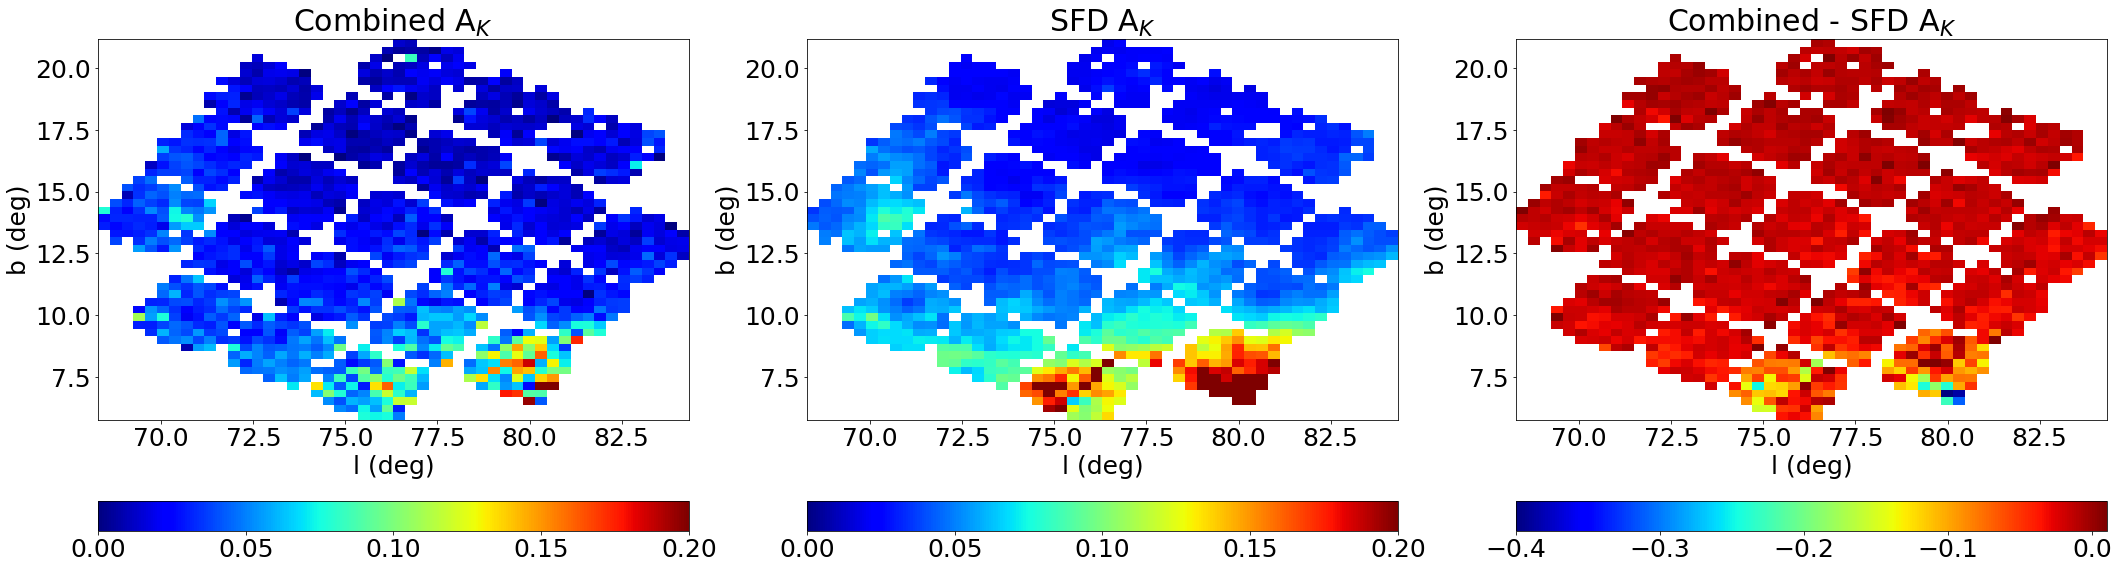

In [50]:
from scipy.stats import binned_statistic_2d
# vmax = 0.55

plt.figure(figsize=[36,10])

fincut = np.where((np.isfinite(agetab['AK'])==True)&(np.isfinite(agetab['AK_SEP'])==True)&
                  (agetab['AK']<10.)&(agetab['AK_SEP']<10.))

plt.subplot(131)
ret = binned_statistic_2d(kdr17['GLON'][fincut],kdr17['GLAT'][fincut],agetab['AK'][fincut],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=0.0,vmax=0.2)

plt.colorbar(orientation='horizontal')

plt.title(r'Combined A$_K$')
plt.xlabel(r'l (deg)')
plt.ylabel(r'b (deg)')

plt.subplot(132)
ret = binned_statistic_2d(kdr17['GLON'][fincut],kdr17['GLAT'][fincut],
                          kdr17['SFD_EBV'][fincut]*ak_ebv,'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=0.0,vmax=0.2)

plt.colorbar(orientation='horizontal')

plt.title(r'SFD A$_K$')
plt.xlabel(r'l (deg)')
plt.ylabel(r'b (deg)')

plt.subplot(133)
ret = binned_statistic_2d(kdr17['GLON'][fincut],kdr17['GLAT'][fincut],
                          (agetab['AK']-kdr17['SFD_EBV']*ak_ebv)[fincut],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=-0.4,vmax=0.01)

plt.colorbar(orientation='horizontal')

plt.title(r'Combined - SFD A$_K$')
plt.xlabel(r'l (deg)')
plt.ylabel(r'b (deg)')

plt.savefig('ext_map_sfd.pdf',dpi=300,bbox_inches='tight')
plt.show()

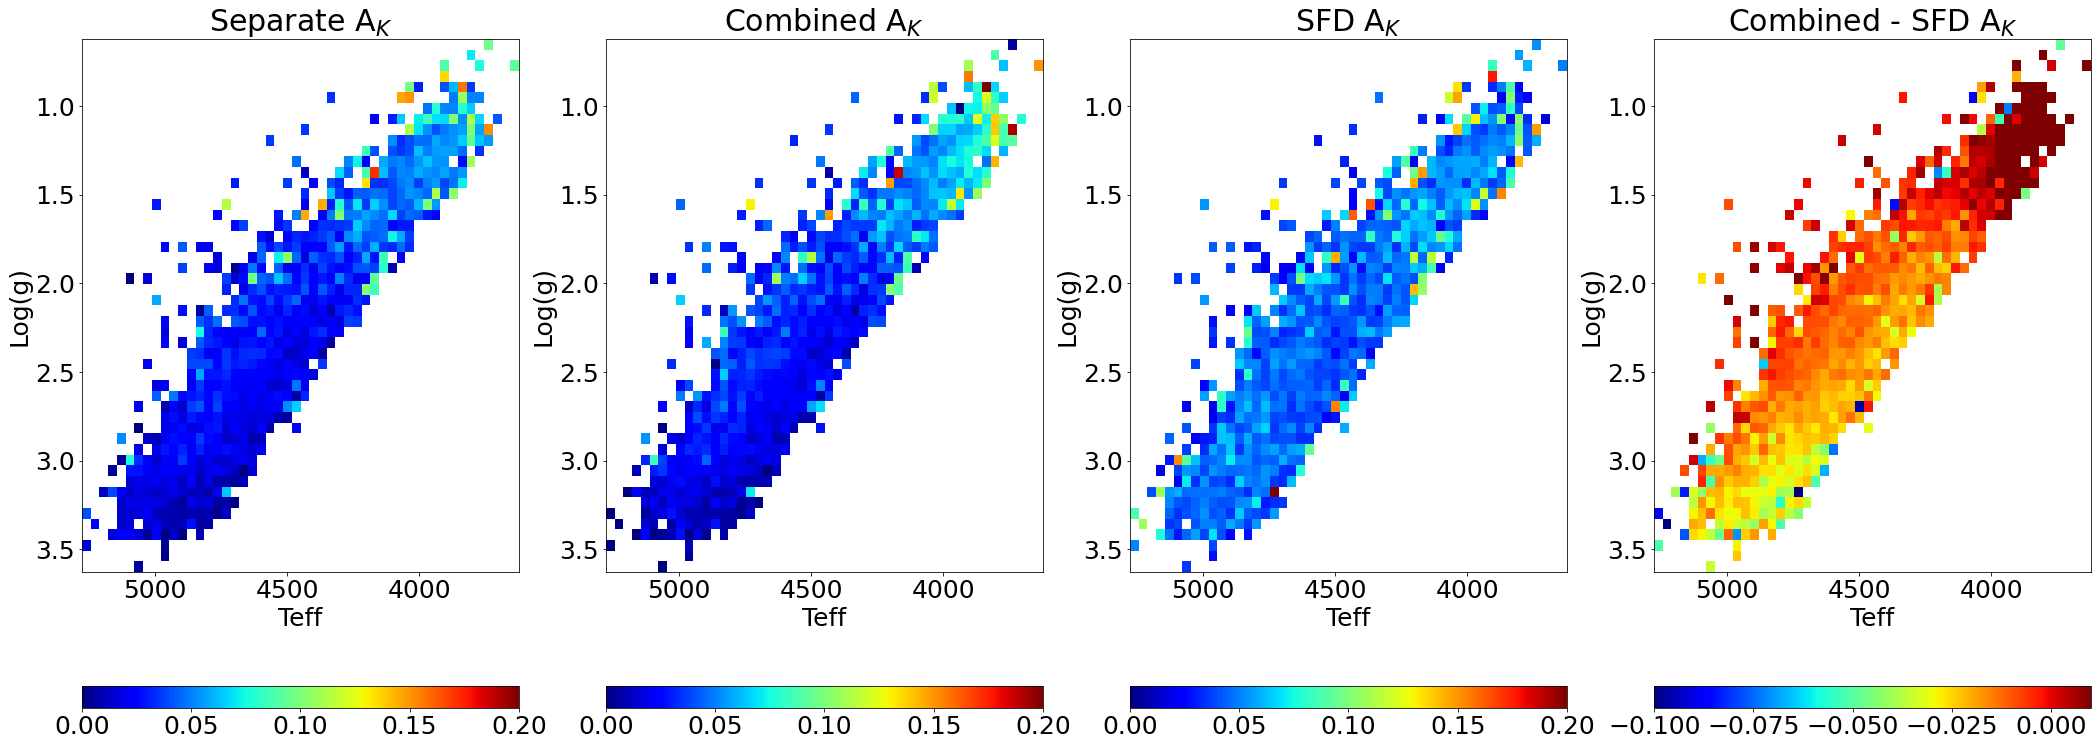

In [51]:
plt.figure(figsize=[36,14])

fincut = np.where((np.isfinite(agetab['AK'])==True)&(np.isfinite(agetab['AK_SEP'])==True)&
                  (agetab['AK']<10.)&(agetab['AK_SEP']<10.))

plt.subplot(141)
ret = binned_statistic_2d(kdr17['TEFF'][fincut],kdr17['LOGG'][fincut],agetab['AK_SEP'][fincut],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=0.0,vmax=0.2)

plt.colorbar(orientation='horizontal')

plt.title(r'Separate A$_K$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.subplot(142)
ret = binned_statistic_2d(kdr17['TEFF'][fincut],kdr17['LOGG'][fincut],agetab['AK'][fincut],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=0.0,vmax=0.2)

plt.colorbar(orientation='horizontal')

plt.title(r'Combined A$_K$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.subplot(143)
ret = binned_statistic_2d(kdr17['TEFF'][fincut],kdr17['LOGG'][fincut],
                          kdr17['SFD_EBV'][fincut]*ak_ebv,'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=0.0,vmax=0.2)

plt.colorbar(orientation='horizontal')

plt.title(r'SFD A$_K$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.subplot(144)
ret = binned_statistic_2d(kdr17['TEFF'][fincut],kdr17['LOGG'][fincut],
                          (agetab['AK']-kdr17['SFD_EBV']*ak_ebv)[fincut],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=-0.1,vmax=0.01)

plt.colorbar(orientation='horizontal')

plt.title(r'Combined - SFD A$_K$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.savefig('hr_sfd.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [52]:
upturn_comsfd

(array([   0,    5,   10,   18,   40,   45,   46,   47,   48,   54,   61,
          74,   81,   86,  102,  109,  123,  129,  133,  145,  151,  165,
         182,  212,  218,  222,  247,  259,  264,  273,  288,  302,  318,
         322,  348,  370,  383,  399,  408,  410,  441,  442,  464,  466,
         472,  478,  482,  498,  508,  515,  521,  542,  566,  591,  593,
         632,  634,  638,  658,  714,  725,  741,  750,  775,  781,  804,
         808,  817,  830,  903,  940, 1002, 1014, 1017, 1029, 1084, 1097,
        1110, 1122, 1123, 1127, 1129, 1139, 1167, 1198, 1200, 1209, 1241,
        1271, 1274, 1280, 1287, 1342, 1354, 1391, 1414, 1434, 1457, 1469,
        1503, 1536, 1538, 1543, 1553, 1560, 1596, 1604, 1606, 1615, 1622,
        1628, 1633, 1638, 1655, 1687, 1706, 1722, 1743, 1774, 1814, 1815,
        1832, 1888, 1900, 1934, 1967, 1999, 2000, 2006, 2008, 2036, 2081,
        2090, 2101, 2114, 2137, 2140, 2142, 2145, 2152, 2199, 2211, 2213,
        2218, 2229, 2235, 2244, 2266, 

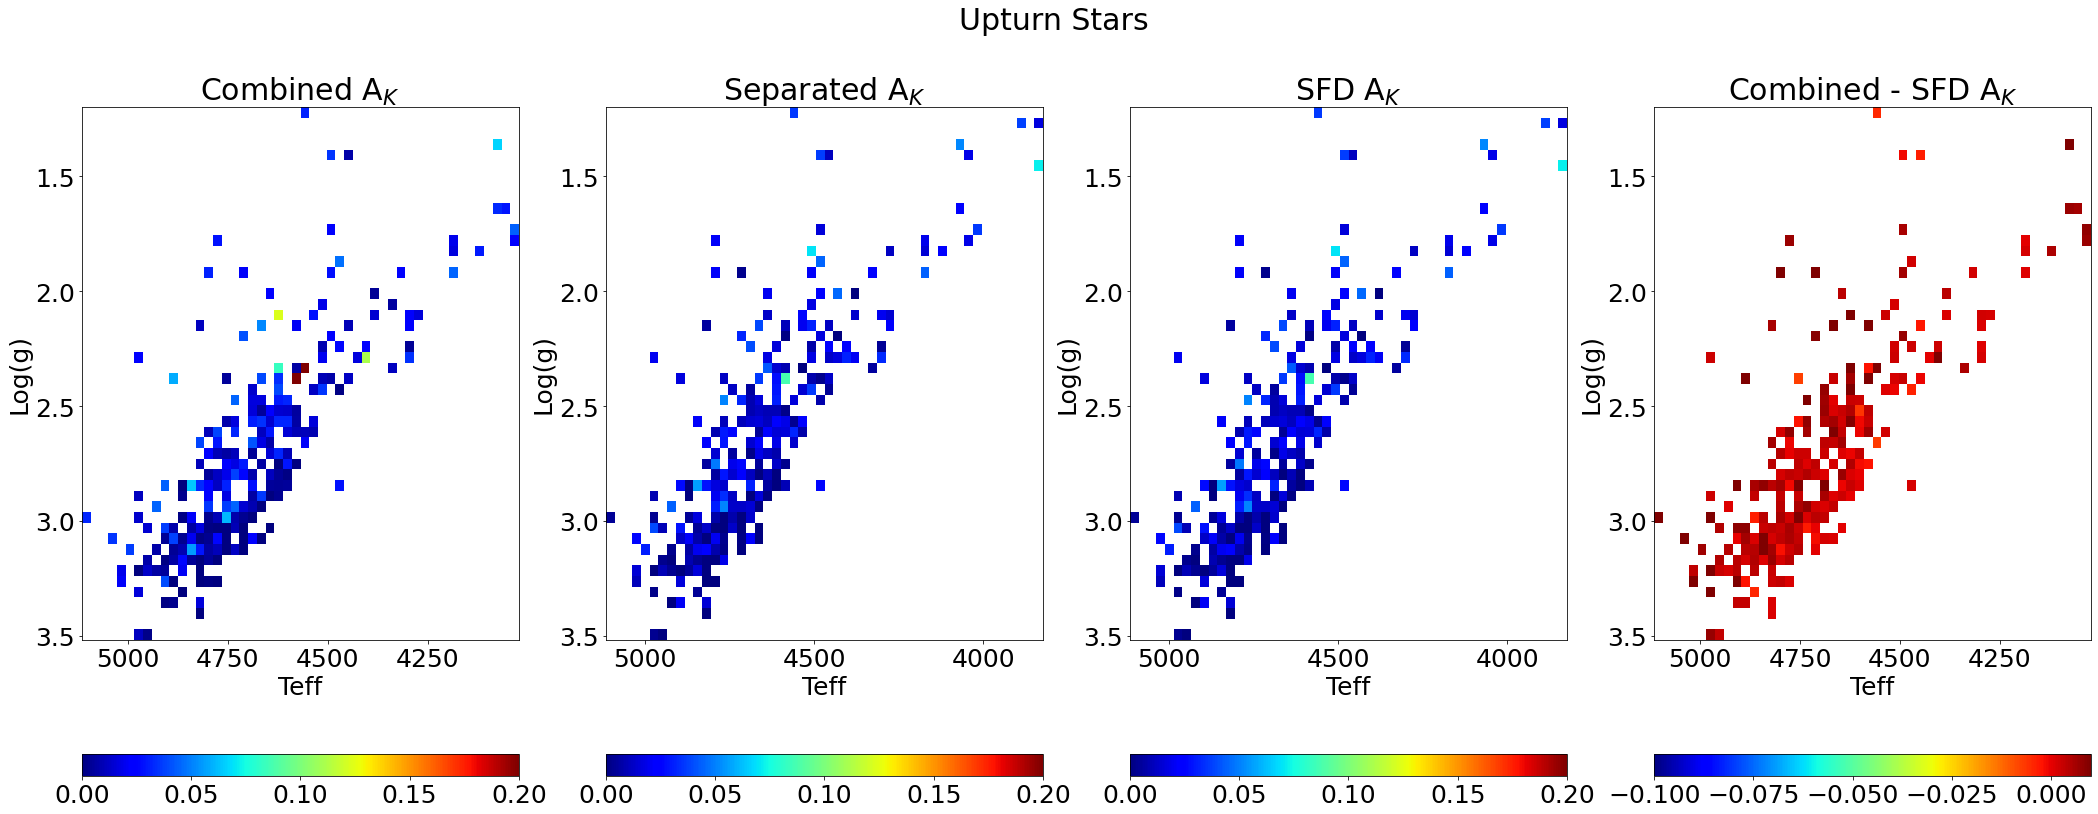

In [91]:
### Upturn

# Cuts
fincut = np.where((np.isfinite(agetab['AK'][upturn])==True)&(np.isfinite(agetab['AK_SEP'][upturn])==True)&
                  (agetab['AK'][upturn]<10.)&(agetab['AK_SEP'][upturn]<10.))

fincut_sep = np.where((np.isfinite(agetab['AK'][upturn_sep])==True)&
                      (np.isfinite(agetab['AK_SEP'][upturn_sep])==True)&
                      (agetab['AK'][upturn_sep]<10.)&(agetab['AK_SEP'][upturn_sep]<10.))

fincut_sfd = np.where((np.isfinite(agetab['AK'][upturn_sfd])==True)&
                      (np.isfinite(agetab['AK_SEP'][upturn_sfd])==True)&
                      (agetab['AK'][upturn_sfd]<10.)&(agetab['AK_SEP'][upturn_sfd]<10.))

fincut_comsfd = np.where((np.isfinite(agetab['AK'][upturn_comsfd])==True)&
                         (np.isfinite(agetab['AK_SEP'][upturn_comsfd])==True)&
                         (agetab['AK'][upturn_comsfd]<10.)&(agetab['AK_SEP'][upturn_comsfd]<10.))

# Binned Data
ret = binned_statistic_2d(kdr17['TEFF'][upturn][fincut],kdr17['LOGG'][upturn][fincut],
                          agetab['AK'][upturn][fincut],'median',bins=50)
ret_sep = binned_statistic_2d(kdr17['TEFF'][upturn_sep][fincut_sep],kdr17['LOGG'][upturn_sep][fincut_sep],
                              agetab['AK_SEP'][upturn_sep][fincut_sep],'median',bins=50)
ret_sfd = binned_statistic_2d(kdr17['TEFF'][upturn_sfd][fincut_sfd],kdr17['LOGG'][upturn_sfd][fincut_sfd],
                          agetab['AK_SFD'][upturn_sfd][fincut_sfd],'median',bins=50)
ret_comsfd = binned_statistic_2d(kdr17['TEFF'][upturn_comsfd][fincut_comsfd],
                                 kdr17['LOGG'][upturn_comsfd][fincut_comsfd],
                                 agetab['AK'][upturn_comsfd][fincut_comsfd]-
                                 agetab['AK_SFD'][upturn_comsfd][fincut_comsfd],'median',bins=50)


plt.figure(figsize=[36,14])

plt.subplot(141)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=0.0,vmax=0.2)

plt.colorbar(orientation='horizontal')

plt.title(r'Combined A$_K$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.subplot(142)
im = plt.imshow(ret_sep.statistic.T, origin='lower',
                    extent=[ret_sep.x_edge[0],ret_sep.x_edge[-1],ret_sep.y_edge[0],ret_sep.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=0.0,vmax=0.2)

plt.colorbar(orientation='horizontal')

plt.title(r'Separated A$_K$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.subplot(143)
im = plt.imshow(ret_sfd.statistic.T, origin='lower',
                    extent=[ret_sfd.x_edge[0],ret_sfd.x_edge[-1],ret_sfd.y_edge[0],ret_sfd.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=0.0,vmax=0.2)

plt.colorbar(orientation='horizontal')

plt.title(r'SFD A$_K$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.subplot(144)
im = plt.imshow(ret_comsfd.statistic.T, origin='lower',
                    extent=[ret_comsfd.x_edge[0],ret_comsfd.x_edge[-1],ret_comsfd.y_edge[0],ret_comsfd.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=-0.1,vmax=0.01)

plt.colorbar(orientation='horizontal')

plt.title(r'Combined - SFD A$_K$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.suptitle(r'Upturn Stars')

plt.savefig('hr_upturn_compare.pdf',dpi=300,bbox_inches='tight')
plt.show()

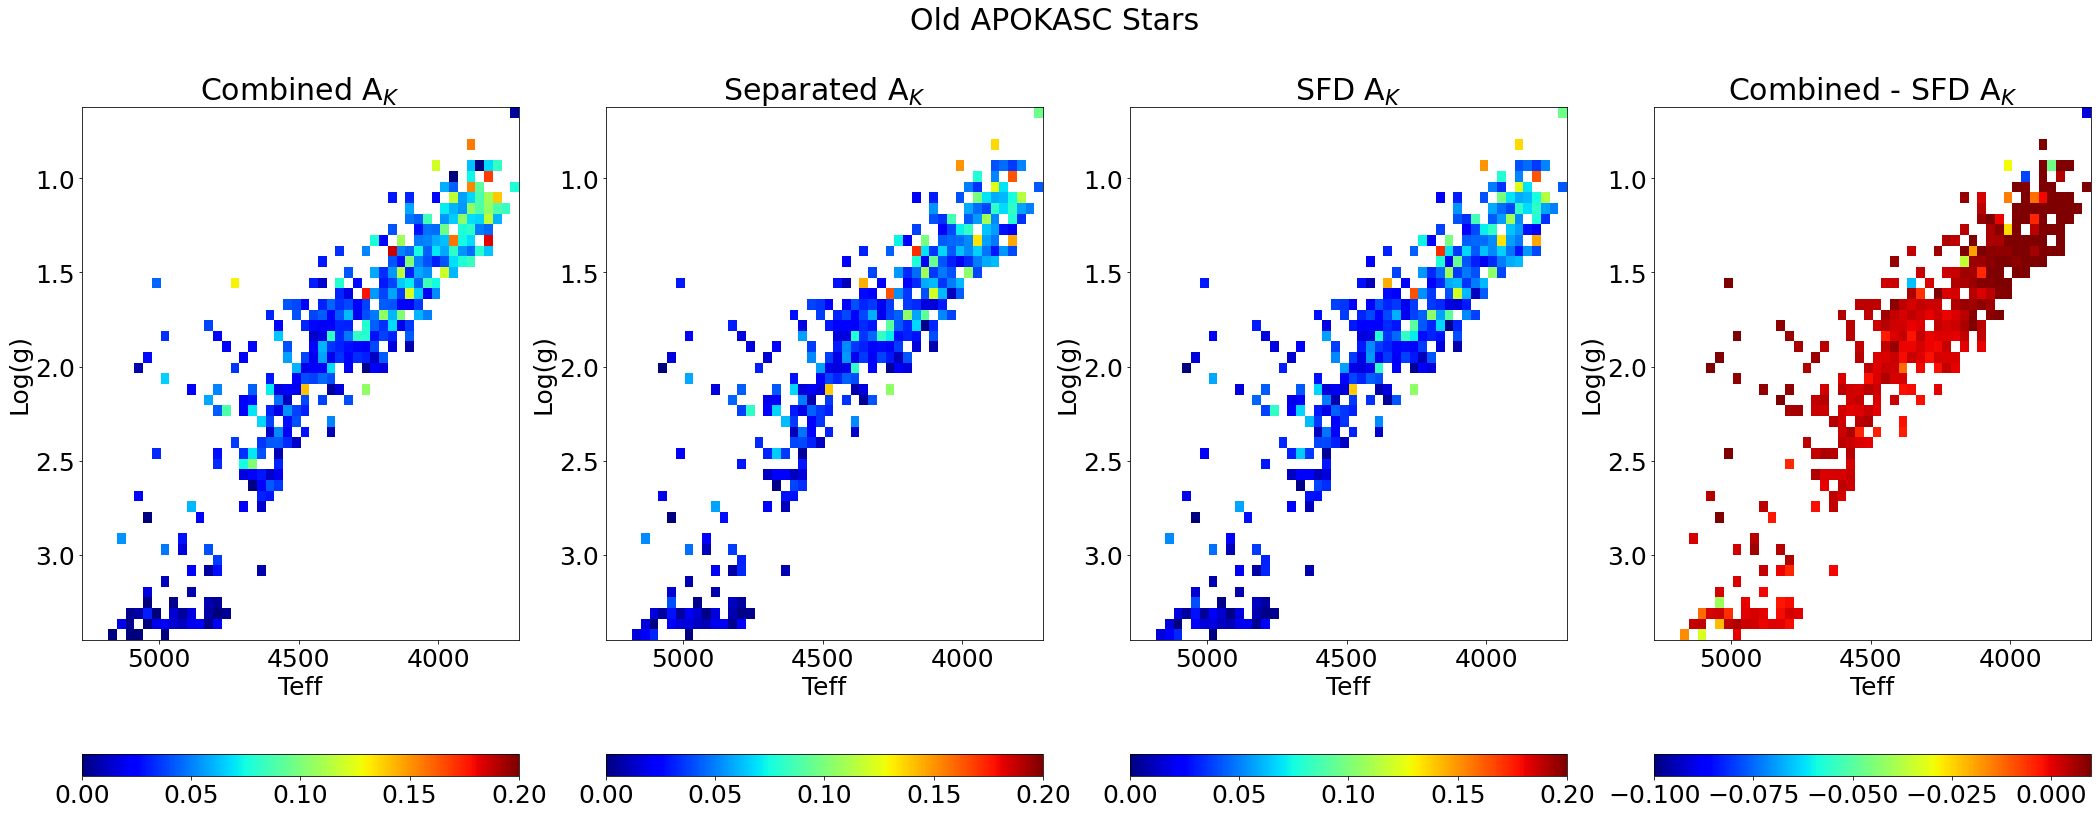

In [92]:
### oldkasc

# Cuts
fincut = np.where((np.isfinite(agetab['AK'][oldkasc])==True)&(np.isfinite(agetab['AK_SEP'][oldkasc])==True)&
                  (agetab['AK'][oldkasc]<10.)&(agetab['AK_SEP'][oldkasc]<10.))

fincut_sep = np.where((np.isfinite(agetab['AK'][oldkasc_sep])==True)&
                      (np.isfinite(agetab['AK_SEP'][oldkasc_sep])==True)&
                      (agetab['AK'][oldkasc_sep]<10.)&(agetab['AK_SEP'][oldkasc_sep]<10.))

fincut_sfd = np.where((np.isfinite(agetab['AK'][oldkasc_sfd])==True)&
                      (np.isfinite(agetab['AK_SEP'][oldkasc_sfd])==True)&
                      (agetab['AK'][oldkasc_sfd]<10.)&(agetab['AK_SEP'][oldkasc_sfd]<10.))

fincut_comsfd = np.where((np.isfinite(agetab['AK'][oldkasc_comsfd])==True)&
                         (np.isfinite(agetab['AK_SEP'][oldkasc_comsfd])==True)&
                         (agetab['AK'][oldkasc_comsfd]<10.)&(agetab['AK_SEP'][oldkasc_comsfd]<10.))

# Binned Data
ret = binned_statistic_2d(kdr17['TEFF'][oldkasc][fincut],kdr17['LOGG'][oldkasc][fincut],
                          agetab['AK'][oldkasc][fincut],'median',bins=50)

ret_sep = binned_statistic_2d(kdr17['TEFF'][oldkasc_sep][fincut_sep],kdr17['LOGG'][oldkasc_sep][fincut_sep],
                              agetab['AK_SEP'][oldkasc_sep][fincut_sep],'median',bins=50)

ret_sfd = binned_statistic_2d(kdr17['TEFF'][oldkasc_sfd][fincut_sfd],kdr17['LOGG'][oldkasc_sfd][fincut_sfd],
                          agetab['AK_SFD'][oldkasc_sfd][fincut_sfd],'median',bins=50)

ret_comsfd = binned_statistic_2d(kdr17['TEFF'][oldkasc_comsfd][fincut_comsfd],
                                 kdr17['LOGG'][oldkasc_comsfd][fincut_comsfd],
                                 agetab['AK'][oldkasc_comsfd][fincut_comsfd]-
                                 agetab['AK_SFD'][oldkasc_comsfd][fincut_comsfd],'median',bins=50)


plt.figure(figsize=[36,14])

plt.subplot(141)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=0.0,vmax=0.2)

plt.colorbar(orientation='horizontal')

plt.title(r'Combined A$_K$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.subplot(142)
im = plt.imshow(ret_sep.statistic.T, origin='lower',
                    extent=[ret_sep.x_edge[0],ret_sep.x_edge[-1],ret_sep.y_edge[0],ret_sep.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=0.0,vmax=0.2)

plt.colorbar(orientation='horizontal')

plt.title(r'Separated A$_K$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.subplot(143)
im = plt.imshow(ret_sfd.statistic.T, origin='lower',
                    extent=[ret_sfd.x_edge[0],ret_sfd.x_edge[-1],ret_sfd.y_edge[0],ret_sfd.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=0.0,vmax=0.2)

plt.colorbar(orientation='horizontal')

plt.title(r'SFD A$_K$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.subplot(144)
im = plt.imshow(ret_comsfd.statistic.T, origin='lower',
                    extent=[ret_comsfd.x_edge[0],ret_comsfd.x_edge[-1],ret_comsfd.y_edge[0],ret_comsfd.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=-0.1,vmax=0.01)

plt.colorbar(orientation='horizontal')

plt.title(r'Combined - SFD A$_K$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.suptitle(r'Old APOKASC Stars')

plt.savefig('hr_oldkasc_compare.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [25]:
# plt.figure(figsize=[36,14])

# fincut = np.where((np.isfinite(agetab['AK'])==True)&(np.isfinite(agetab['AK_SEP'])==True)&
#                   (agetab['AK']<10.)&(agetab['AK_SEP']<10.))

# plt.subplot(141)
# ret = binned_statistic_2d(kdr17['TEFF'][fincut],kdr17['LOGG'][fincut],agetab['AK_SEP'][fincut],'median',bins=50)
# im = plt.imshow(ret.statistic.T, origin='lower',
#                     extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
#                     aspect='auto',interpolation='nearest',cmap='jet',vmin=0.0,vmax=0.2)

# plt.colorbar(orientation='horizontal')

# plt.title(r'Separate A$_K$')
# plt.xlabel(r'Teff')
# plt.ylabel(r'Log(g)')

# plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()

# plt.subplot(142)
# ret = binned_statistic_2d(kdr17['TEFF'][fincut],kdr17['LOGG'][fincut],agetab['AK'][fincut],'median',bins=50)
# im = plt.imshow(ret.statistic.T, origin='lower',
#                     extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
#                     aspect='auto',interpolation='nearest',cmap='jet',vmin=0.0,vmax=0.2)

# plt.colorbar(orientation='horizontal')

# plt.title(r'Combined A$_K$')
# plt.xlabel(r'Teff')
# plt.ylabel(r'Log(g)')

# plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()

# plt.subplot(143)
# ret = binned_statistic_2d(kdr17['TEFF'][fincut],kdr17['LOGG'][fincut],
#                           kdr17['SFD_EBV'][fincut]*ak_ebv,'median',bins=50)
# im = plt.imshow(ret.statistic.T, origin='lower',
#                     extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
#                     aspect='auto',interpolation='nearest',cmap='jet',vmin=0.0,vmax=0.2)

# plt.colorbar(orientation='horizontal')

# plt.title(r'SFD A$_K$')
# plt.xlabel(r'Teff')
# plt.ylabel(r'Log(g)')

# plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()

# plt.subplot(144)
# ret = binned_statistic_2d(kdr17['TEFF'][fincut],kdr17['LOGG'][fincut],
#                           (agetab['AK']-kdr17['SFD_EBV']*ak_ebv)[fincut],'median',bins=50)
# im = plt.imshow(ret.statistic.T, origin='lower',
#                     extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
#                     aspect='auto',interpolation='nearest',cmap='jet',vmin=-0.1,vmax=0.01)

# plt.colorbar(orientation='horizontal')

# plt.title(r'Combined - SFD A$_K$')
# plt.xlabel(r'Teff')
# plt.ylabel(r'Log(g)')

# plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()

# plt.savefig('hr_sfd.pdf',dpi=300,bbox_inches='tight')
# plt.show()

ColDefs(
    name = 'NAME'; format = '30A'
    name = 'AK'; format = 'D'
    name = 'AGE'; format = 'D'
    name = 'CHI'; format = 'D'
    name = 'RMSE'; format = 'D'
    name = 'AK_SEP'; format = 'D'
    name = 'AGE_SEP'; format = 'D'
    name = 'MASS_SEP'; format = 'D'
    name = 'CHI_SEP'; format = 'D'
    name = 'RMSE_SEP'; format = 'D'
    name = 'AK_SFD'; format = 'D'
    name = 'AGE_SFD'; format = 'D'
    name = 'MASS_SFD'; format = 'D'
    name = 'CHI_SFD'; format = 'D'
    name = 'RMSE_SFD'; format = 'D'
    name = 'PARSEC_AGE'; format = 'D'
)

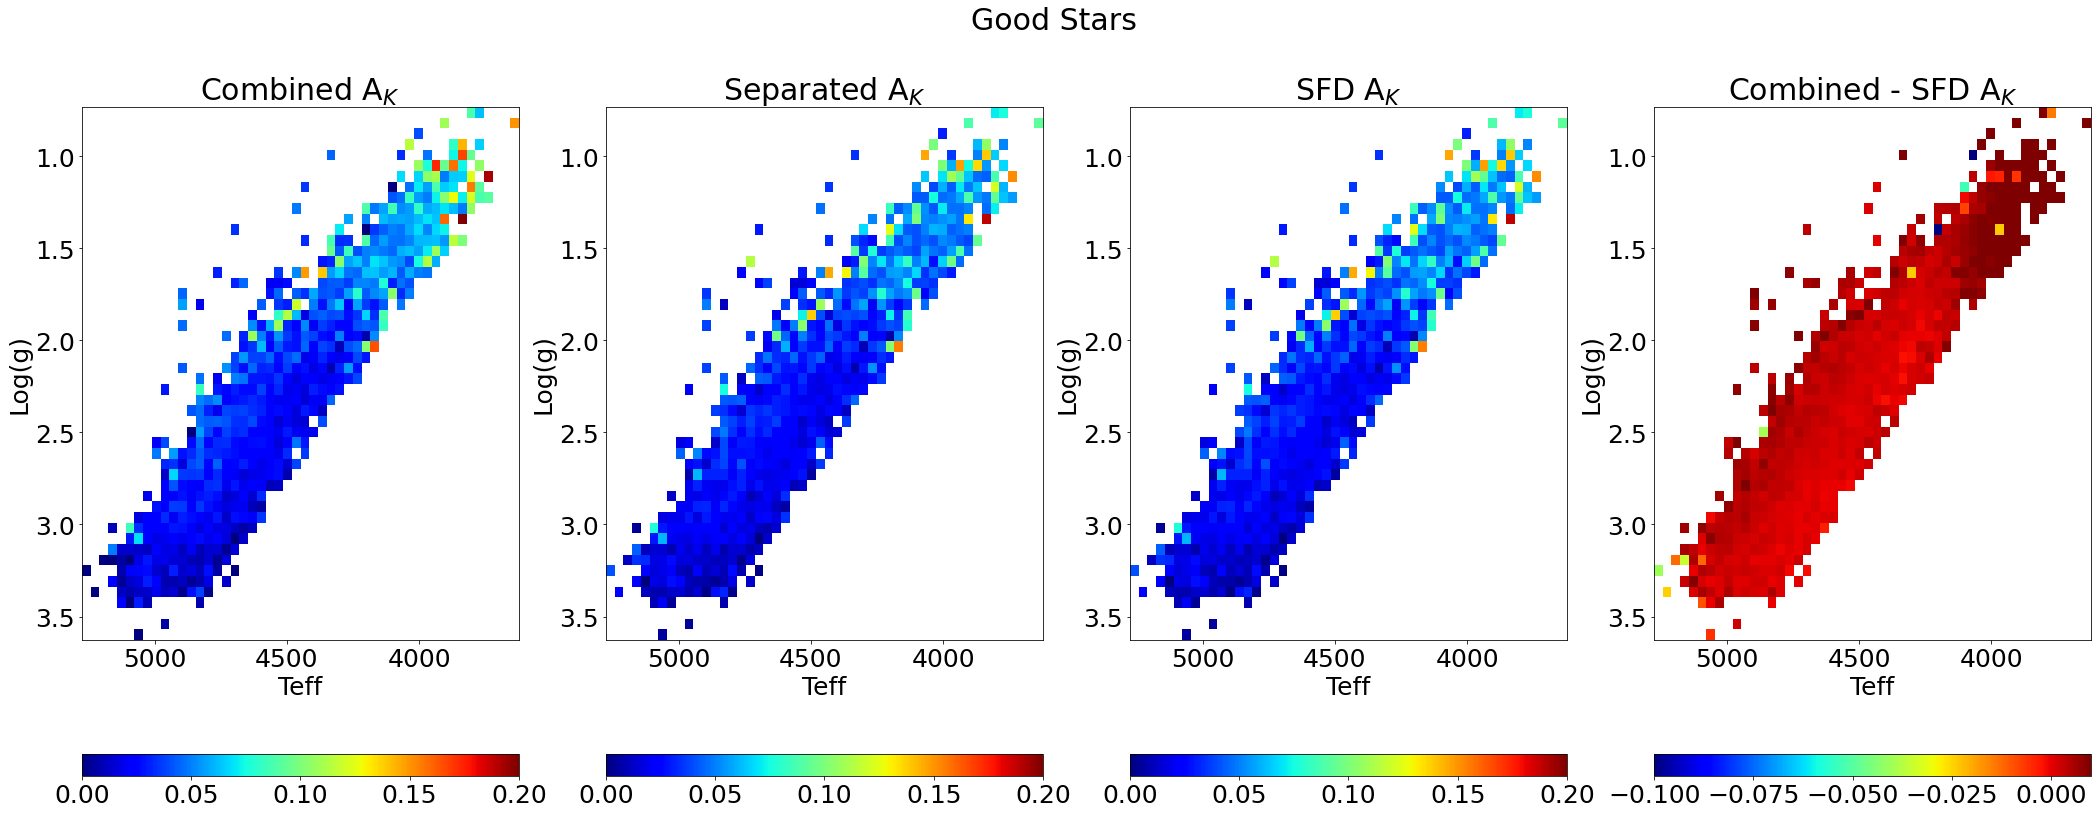

In [93]:
### good

# Cuts
fincut = np.where((np.isfinite(agetab['AK'][good])==True)&(np.isfinite(agetab['AK_SEP'][good])==True)&
                  (agetab['AK'][good]<10.)&(agetab['AK_SEP'][good]<10.))

fincut_sep = np.where((np.isfinite(agetab['AK'][good_sep])==True)&
                      (np.isfinite(agetab['AK_SEP'][good_sep])==True)&
                      (agetab['AK'][good_sep]<10.)&(agetab['AK_SEP'][good_sep]<10.))

fincut_sfd = np.where((np.isfinite(agetab['AK'][good_sfd])==True)&
                      (np.isfinite(agetab['AK_SEP'][good_sfd])==True)&
                      (agetab['AK'][good_sfd]<10.)&(agetab['AK_SEP'][good_sfd]<10.))

fincut_comsfd = np.where((np.isfinite(agetab['AK'][good_comsfd])==True)&
                         (np.isfinite(agetab['AK_SEP'][good_comsfd])==True)&
                         (agetab['AK'][good_comsfd]<10.)&(agetab['AK_SEP'][good_comsfd]<10.))

# Binned Data
ret = binned_statistic_2d(kdr17['TEFF'][good][fincut],kdr17['LOGG'][good][fincut],
                          agetab['AK'][good][fincut],'median',bins=50)

ret_sep = binned_statistic_2d(kdr17['TEFF'][good_sep][fincut_sep],kdr17['LOGG'][good_sep][fincut_sep],
                              agetab['AK_SEP'][good_sep][fincut_sep],'median',bins=50)

ret_sfd = binned_statistic_2d(kdr17['TEFF'][good_sfd][fincut_sfd],kdr17['LOGG'][good_sfd][fincut_sfd],
                          agetab['AK_SFD'][good_sfd][fincut_sfd],'median',bins=50)

ret_comsfd = binned_statistic_2d(kdr17['TEFF'][good_comsfd][fincut_comsfd],
                                 kdr17['LOGG'][good_comsfd][fincut_comsfd],
                                 agetab['AK'][good_comsfd][fincut_comsfd]-
                                 agetab['AK_SFD'][good_comsfd][fincut_comsfd],'median',bins=50)


plt.figure(figsize=[36,14])

plt.subplot(141)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=0.0,vmax=0.2)

plt.colorbar(orientation='horizontal')

plt.title(r'Combined A$_K$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.subplot(142)
im = plt.imshow(ret_sep.statistic.T, origin='lower',
                    extent=[ret_sep.x_edge[0],ret_sep.x_edge[-1],ret_sep.y_edge[0],ret_sep.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=0.0,vmax=0.2)

plt.colorbar(orientation='horizontal')

plt.title(r'Separated A$_K$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.subplot(143)
im = plt.imshow(ret_sfd.statistic.T, origin='lower',
                    extent=[ret_sfd.x_edge[0],ret_sfd.x_edge[-1],ret_sfd.y_edge[0],ret_sfd.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=0.0,vmax=0.2)

plt.colorbar(orientation='horizontal')

plt.title(r'SFD A$_K$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.subplot(144)
im = plt.imshow(ret_comsfd.statistic.T, origin='lower',
                    extent=[ret_comsfd.x_edge[0],ret_comsfd.x_edge[-1],ret_comsfd.y_edge[0],ret_comsfd.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=-0.1,vmax=0.01)

plt.colorbar(orientation='horizontal')

plt.title(r'Combined - SFD A$_K$')
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.suptitle(r'Good Stars')

plt.savefig('hr_good_compare.pdf',dpi=300,bbox_inches='tight')
plt.show()

0.09122983801747506
0.4218174016627299
0.09524277482949933


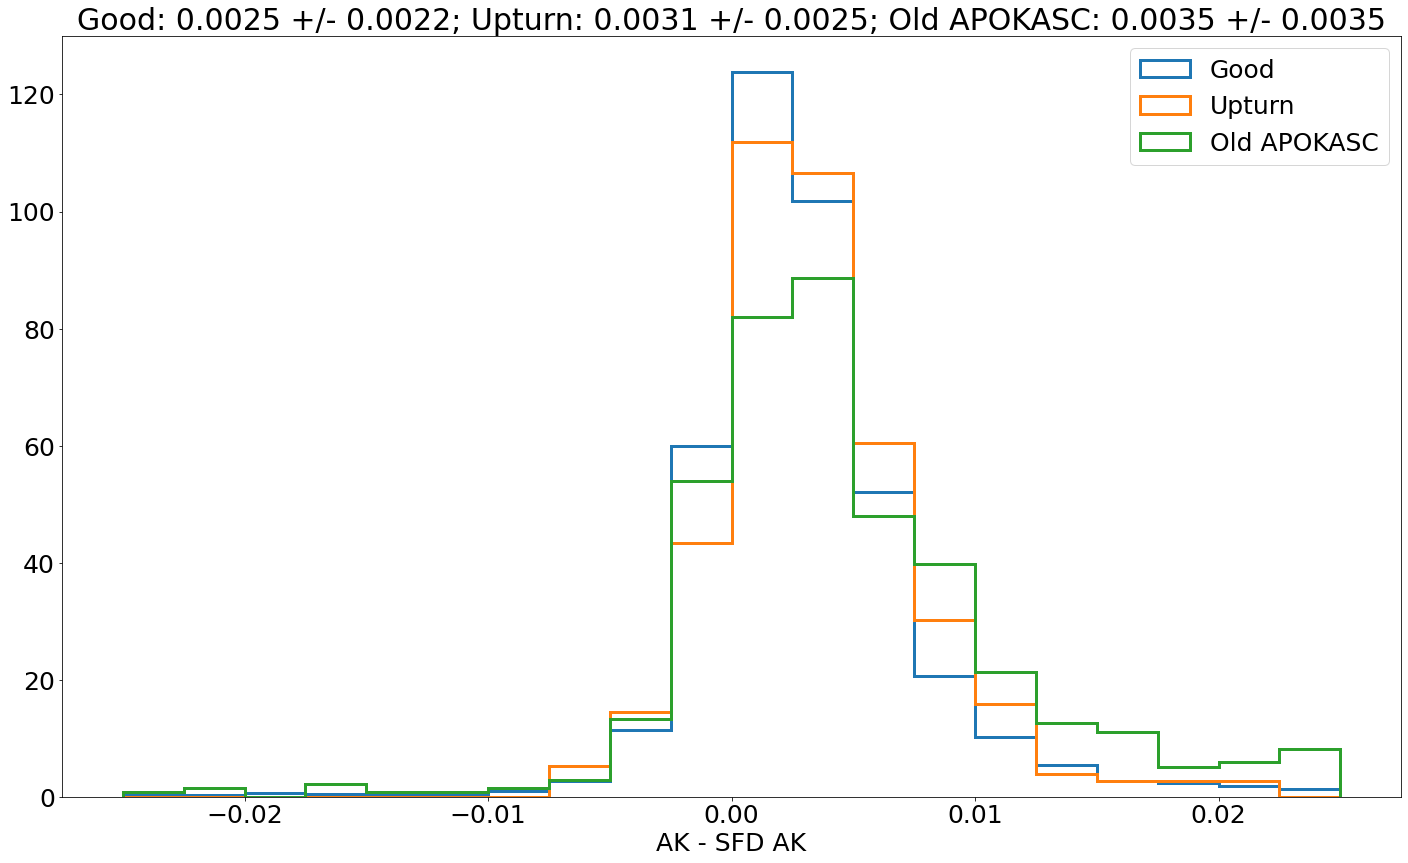

In [116]:
plt.figure(figsize=[24,14])

fincut_comsfd = np.where((np.isfinite(agetab['AK'][good_comsfd])==True)&
                         (np.isfinite(agetab['AK_SEP'][good_comsfd])==True)&
                         (agetab['AK'][good_comsfd]<10.)&(agetab['AK_SEP'][good_comsfd]<10.))
plt.hist(agetab['AK'][good_comsfd][fincut_comsfd]-agetab['AK_SFD'][good_comsfd][fincut_comsfd],
         histtype='step',lw=3.0,density=True,label='Good',range=(-0.025,0.025),bins=20)

medgood = np.median(agetab['AK'][good_comsfd][fincut_comsfd]-agetab['AK_SFD'][good_comsfd][fincut_comsfd])
madgood = mad(agetab['AK'][good_comsfd][fincut_comsfd]-agetab['AK_SFD'][good_comsfd][fincut_comsfd])
print(max(agetab['AK'][good_comsfd][fincut_comsfd]-agetab['AK_SFD'][good_comsfd][fincut_comsfd]))

fincut_comsfd = np.where((np.isfinite(agetab['AK'][upturn_comsfd])==True)&
                         (np.isfinite(agetab['AK_SEP'][upturn_comsfd])==True)&
                         (agetab['AK'][upturn_comsfd]<10.)&(agetab['AK_SEP'][upturn_comsfd]<10.))
plt.hist(agetab['AK'][upturn_comsfd][fincut_comsfd]-agetab['AK_SFD'][upturn_comsfd][fincut_comsfd],
         histtype='step',lw=3.0,density=True,label='Upturn',range=(-0.025,0.025),bins=20)

medupturn = np.median(agetab['AK'][upturn_comsfd][fincut_comsfd]-agetab['AK_SFD'][upturn_comsfd][fincut_comsfd])
madupturn = mad(agetab['AK'][upturn_comsfd][fincut_comsfd]-agetab['AK_SFD'][upturn_comsfd][fincut_comsfd])
print(max(agetab['AK'][upturn_comsfd][fincut_comsfd]-agetab['AK_SFD'][upturn_comsfd][fincut_comsfd]))

fincut_comsfd = np.where((np.isfinite(agetab['AK'][oldkasc_comsfd])==True)&
                         (np.isfinite(agetab['AK_SEP'][oldkasc_comsfd])==True)&
                         (agetab['AK'][oldkasc_comsfd]<10.)&(agetab['AK_SEP'][oldkasc_comsfd]<10.))
plt.hist(agetab['AK'][oldkasc_comsfd][fincut_comsfd]-agetab['AK_SFD'][oldkasc_comsfd][fincut_comsfd],
         histtype='step',lw=3.0,density=True,label='Old APOKASC',range=(-0.025,0.025),bins=20)

medoldkasc = np.median(agetab['AK'][oldkasc_comsfd][fincut_comsfd]-agetab['AK_SFD'][oldkasc_comsfd][fincut_comsfd])
madoldkasc = mad(agetab['AK'][oldkasc_comsfd][fincut_comsfd]-agetab['AK_SFD'][oldkasc_comsfd][fincut_comsfd])
print(max(agetab['AK'][oldkasc_comsfd][fincut_comsfd]-agetab['AK_SFD'][oldkasc_comsfd][fincut_comsfd]))

plt.legend()

plt.title(r'Good: {:.4f} +/- {:.4f}; Upturn: {:.4f} +/- {:.4f}; Old APOKASC: {:.4f} +/- {:.4f}'.format(medgood,
                                                                                                        madgood,
                                                                                                        medupturn,
                                                                                                        madupturn,
                                                                                                        medoldkasc,
                                                                                                        madoldkasc))
plt.xlabel('AK - SFD AK')

plt.savefig('akresid_good_up_old.pdf',dpi=300,bbox_inches='tight')
plt.show()

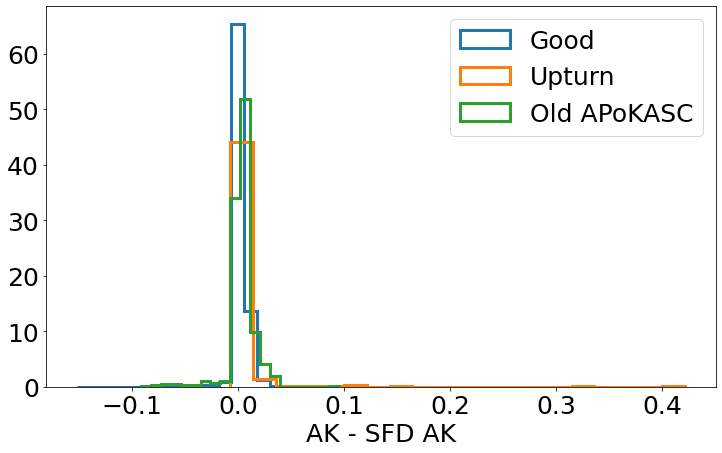

In [108]:
plt.figure(figsize=[12,7])

fincut_comsfd = np.where((np.isfinite(agetab['AK'][good_comsfd])==True)&
                         (np.isfinite(agetab['AK_SEP'][good_comsfd])==True)&
                         (agetab['AK'][good_comsfd]<10.)&(agetab['AK_SEP'][good_comsfd]<10.))
plt.hist(agetab['AK'][good_comsfd][fincut_comsfd]-agetab['AK_SFD'][good_comsfd][fincut_comsfd],
         histtype='step',lw=3.0,density=True,label='Good',bins=20)

fincut_comsfd = np.where((np.isfinite(agetab['AK'][upturn_comsfd])==True)&
                         (np.isfinite(agetab['AK_SEP'][upturn_comsfd])==True)&
                         (agetab['AK'][upturn_comsfd]<10.)&(agetab['AK_SEP'][upturn_comsfd]<10.))
plt.hist(agetab['AK'][upturn_comsfd][fincut_comsfd]-agetab['AK_SFD'][upturn_comsfd][fincut_comsfd],
         histtype='step',lw=3.0,density=True,label='Upturn',bins=20)

fincut_comsfd = np.where((np.isfinite(agetab['AK'][oldkasc_comsfd])==True)&
                         (np.isfinite(agetab['AK_SEP'][oldkasc_comsfd])==True)&
                         (agetab['AK'][oldkasc_comsfd]<10.)&(agetab['AK_SEP'][oldkasc_comsfd]<10.))
plt.hist(agetab['AK'][oldkasc_comsfd][fincut_comsfd]-agetab['AK_SFD'][oldkasc_comsfd][fincut_comsfd],
         histtype='step',lw=3.0,density=True,label='Old APoKASC',bins=20)

plt.legend()


plt.xlabel('AK - SFD AK')

plt.show()

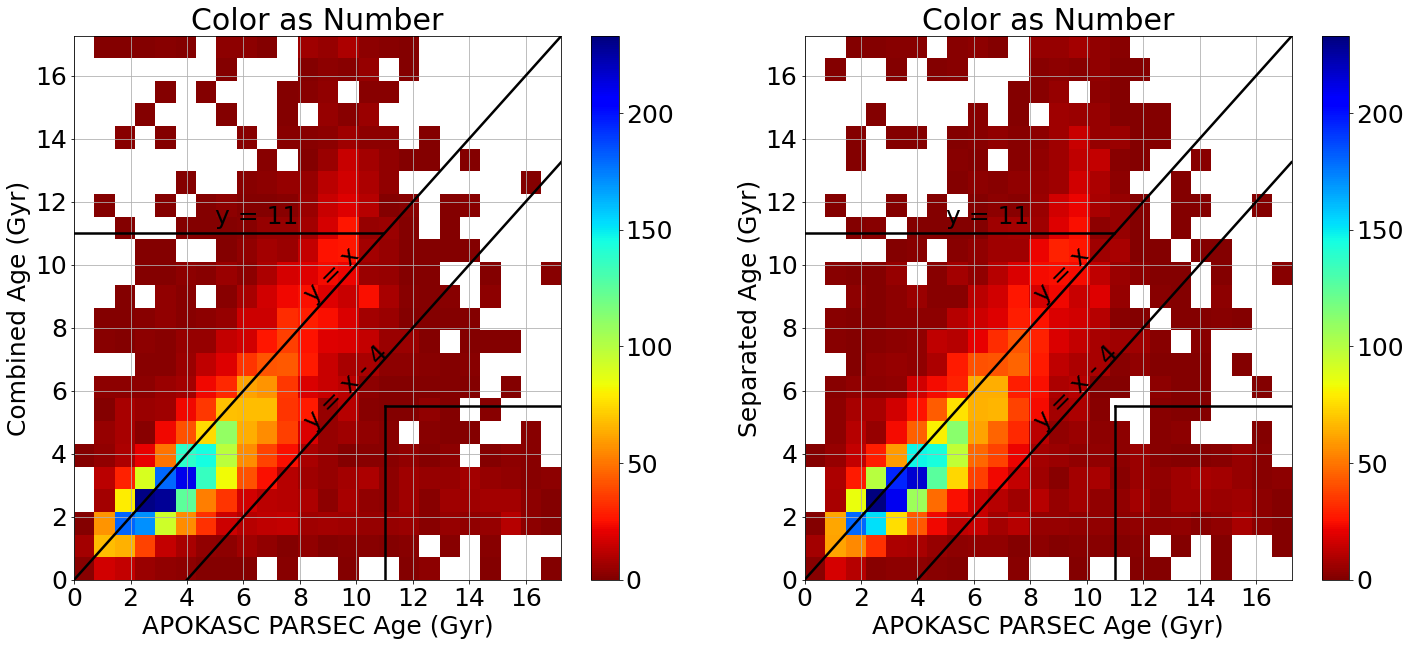

In [53]:
fincut = np.where((np.isfinite(agetab['AGE'])==True)&(np.isfinite(agetab['AGE_SEP'])==True)&
                  (np.isfinite(agetab['PARSEC_AGE']))&(agetab['AGE']<20.)&(agetab['AGE_SEP']<20.)&
                  (agetab['PARSEC_AGE']<20.))

xmax = 18
ymax = 18
nbins = 25

plt.figure(figsize=[24,10])

plt.subplot(121)
ret = binned_statistic_2d(agetab['PARSEC_AGE'][fincut],agetab['AGE'][fincut],agetab['PARSEC_AGE'][fincut],
                          'count',bins=[np.arange(0,xmax,xmax/nbins),np.arange(0,ymax,ymax/25)])
ret.statistic[ret.statistic == 0.0] = np.nan
plt.imshow(ret.statistic.T, origin='lower',extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet_r',vmin=0,vmax=233.)
plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(5,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))
plt.grid()

plt.xlabel('APOKASC PARSEC Age (Gyr)')
plt.ylabel('Combined Age (Gyr)')
cbar = plt.colorbar()
plt.title(r'Color as Number')

plt.subplot(122)
ret = binned_statistic_2d(agetab['PARSEC_AGE'][fincut],agetab['AGE_SEP'][fincut],agetab['PARSEC_AGE'][fincut],
                          'count',bins=[np.arange(0,xmax,xmax/nbins),np.arange(0,ymax,ymax/25)])
ret.statistic[ret.statistic == 0.0] = np.nan
plt.imshow(ret.statistic.T, origin='lower',extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet_r',vmin=0,vmax=233.)
plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(5,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))
plt.grid()

plt.xlabel('APOKASC PARSEC Age (Gyr)')
plt.ylabel('Separated Age (Gyr)')
cbar = plt.colorbar()
plt.title(r'Color as Number')

plt.savefig('compare_2_apokasc_sep_combined.pdf',dpi=300,bbox_inches='tight')
plt.show()

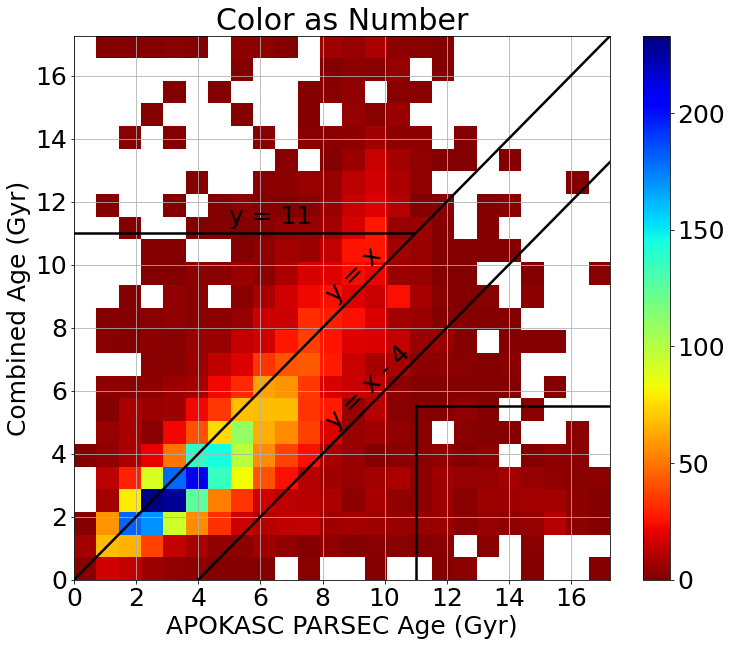

In [275]:
fincut = np.where((np.isfinite(agetab['AGE'])==True)&(np.isfinite(agetab['AGE_SEP'])==True)&
                  (np.isfinite(agetab['PARSEC_AGE']))&(agetab['AGE']<20.)&(agetab['AGE_SEP']<20.)&
                  (agetab['PARSEC_AGE']<20.))

nohigh = np.where((kdr17[fincut]['STARFLAG']!=512)|(kdr17[fincut]['STARFLAG']!=516))

plt.figure(figsize=[12,10])

ret = binned_statistic_2d(agetab['PARSEC_AGE'][fincut][nohigh],agetab['AGE'][fincut][nohigh],
                          agetab['PARSEC_AGE'][fincut][nohigh],'count',
                          bins=[np.arange(0,xmax,xmax/nbins),np.arange(0,ymax,ymax/25)])
ret.statistic[ret.statistic == 0.0] = np.nan
plt.imshow(ret.statistic.T, origin='lower',extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet_r',vmin=0,vmax=233.)
plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(5,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))
plt.grid()

plt.xlabel('APOKASC PARSEC Age (Gyr)')
plt.ylabel('Combined Age (Gyr)')
cbar = plt.colorbar()
plt.title(r'Color as Number')

plt.show()

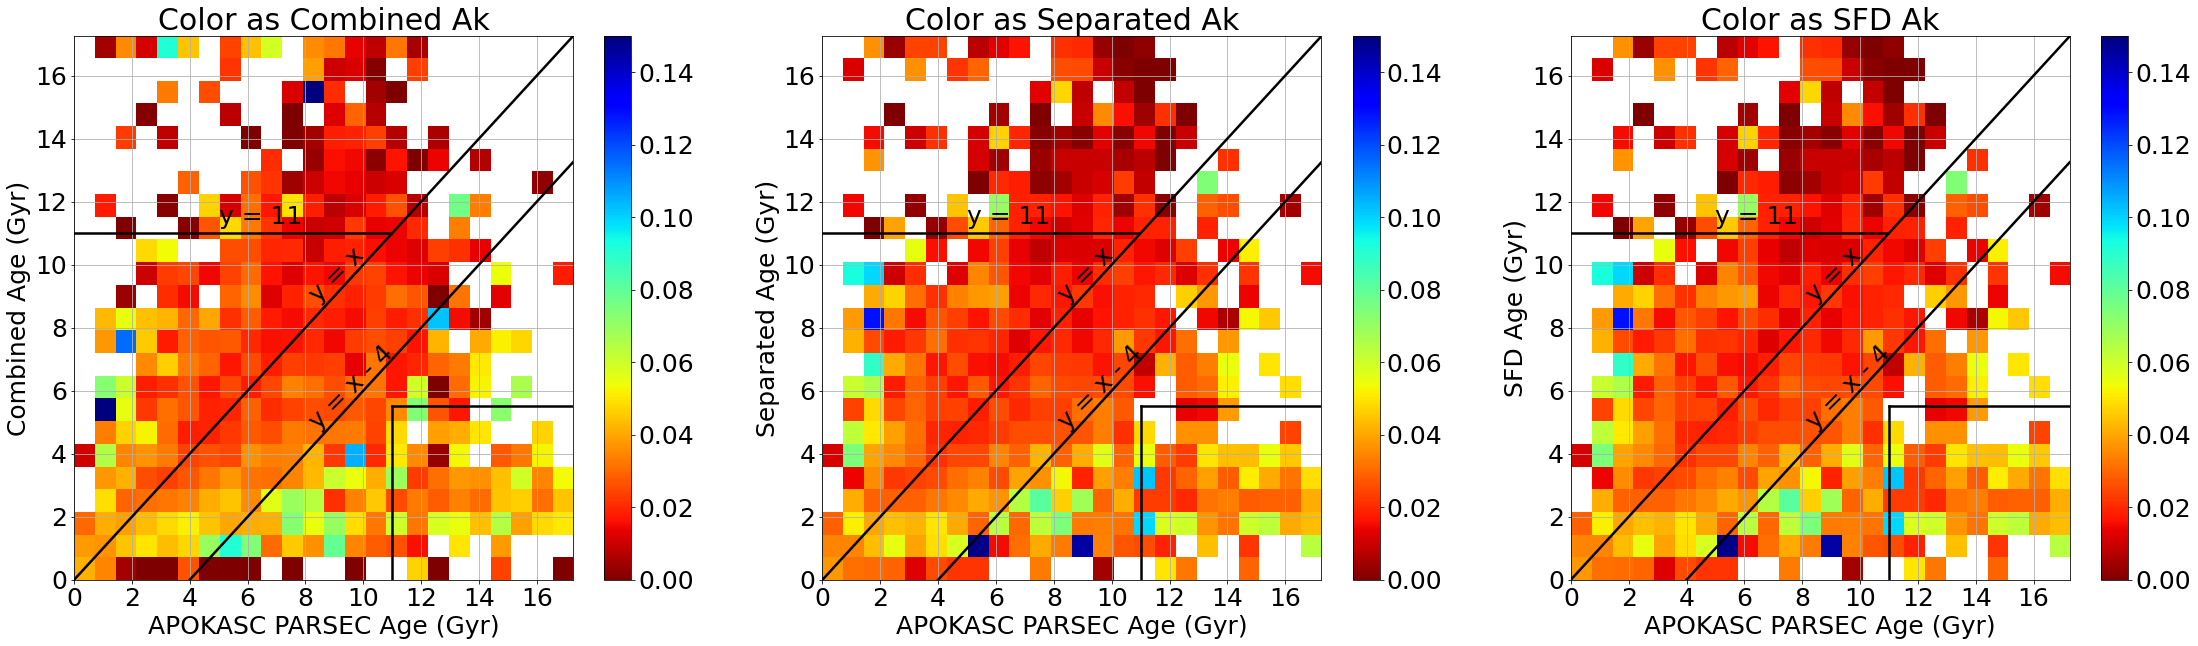

In [160]:
fincut = np.where((np.isfinite(agetab['AGE'])==True)&(np.isfinite(agetab['AGE_SEP'])==True)&
                  (np.isfinite(agetab['PARSEC_AGE']))&(agetab['AGE']<20.)&(agetab['AGE_SEP']<20.)&
                  (agetab['PARSEC_AGE']<20.))

xmax = 18
ymax = 18
nbins = 25

plt.figure(figsize=[38,10])

plt.subplot(131)
ret = binned_statistic_2d(agetab['PARSEC_AGE'][fincut],agetab['AGE'][fincut],agetab['AK'][fincut],
                          'median',bins=[np.arange(0,xmax,xmax/nbins),np.arange(0,ymax,ymax/25)])
ret.statistic[ret.statistic == 0.0] = np.nan
plt.imshow(ret.statistic.T, origin='lower',extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet_r',vmin=0,vmax=0.15)
plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(5,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))
plt.grid()

plt.xlabel('APOKASC PARSEC Age (Gyr)')
plt.ylabel('Combined Age (Gyr)')
cbar = plt.colorbar()
plt.title(r'Color as Combined Ak')

plt.subplot(132)
ret = binned_statistic_2d(agetab['PARSEC_AGE'][fincut],agetab['AGE_SEP'][fincut],agetab['AK_SEP'][fincut],
                          'median',bins=[np.arange(0,xmax,xmax/nbins),np.arange(0,ymax,ymax/25)])
ret.statistic[ret.statistic == 0.0] = np.nan
plt.imshow(ret.statistic.T, origin='lower',extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet_r',vmin=0,vmax=0.15)
plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(5,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))
plt.grid()

plt.xlabel('APOKASC PARSEC Age (Gyr)')
plt.ylabel('Separated Age (Gyr)')
cbar = plt.colorbar()
plt.title(r'Color as Separated Ak')

plt.subplot(133)
ret = binned_statistic_2d(agetab['PARSEC_AGE'][fincut],agetab['AGE_SFD'][fincut],agetab['AK_SFD'][fincut],
                          'median',bins=[np.arange(0,xmax,xmax/nbins),np.arange(0,ymax,ymax/25)])
ret.statistic[ret.statistic == 0.0] = np.nan
plt.imshow(ret.statistic.T, origin='lower',extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet_r',vmin=0,vmax=0.15)
plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(5,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))
plt.grid()

plt.xlabel('APOKASC PARSEC Age (Gyr)')
plt.ylabel('SFD Age (Gyr)')
cbar = plt.colorbar()
plt.title(r'Color as SFD Ak')

plt.savefig('../plots/age2age_com_sep_sfd.pdf',dpi=300,bbox_inches='tight')
plt.show()

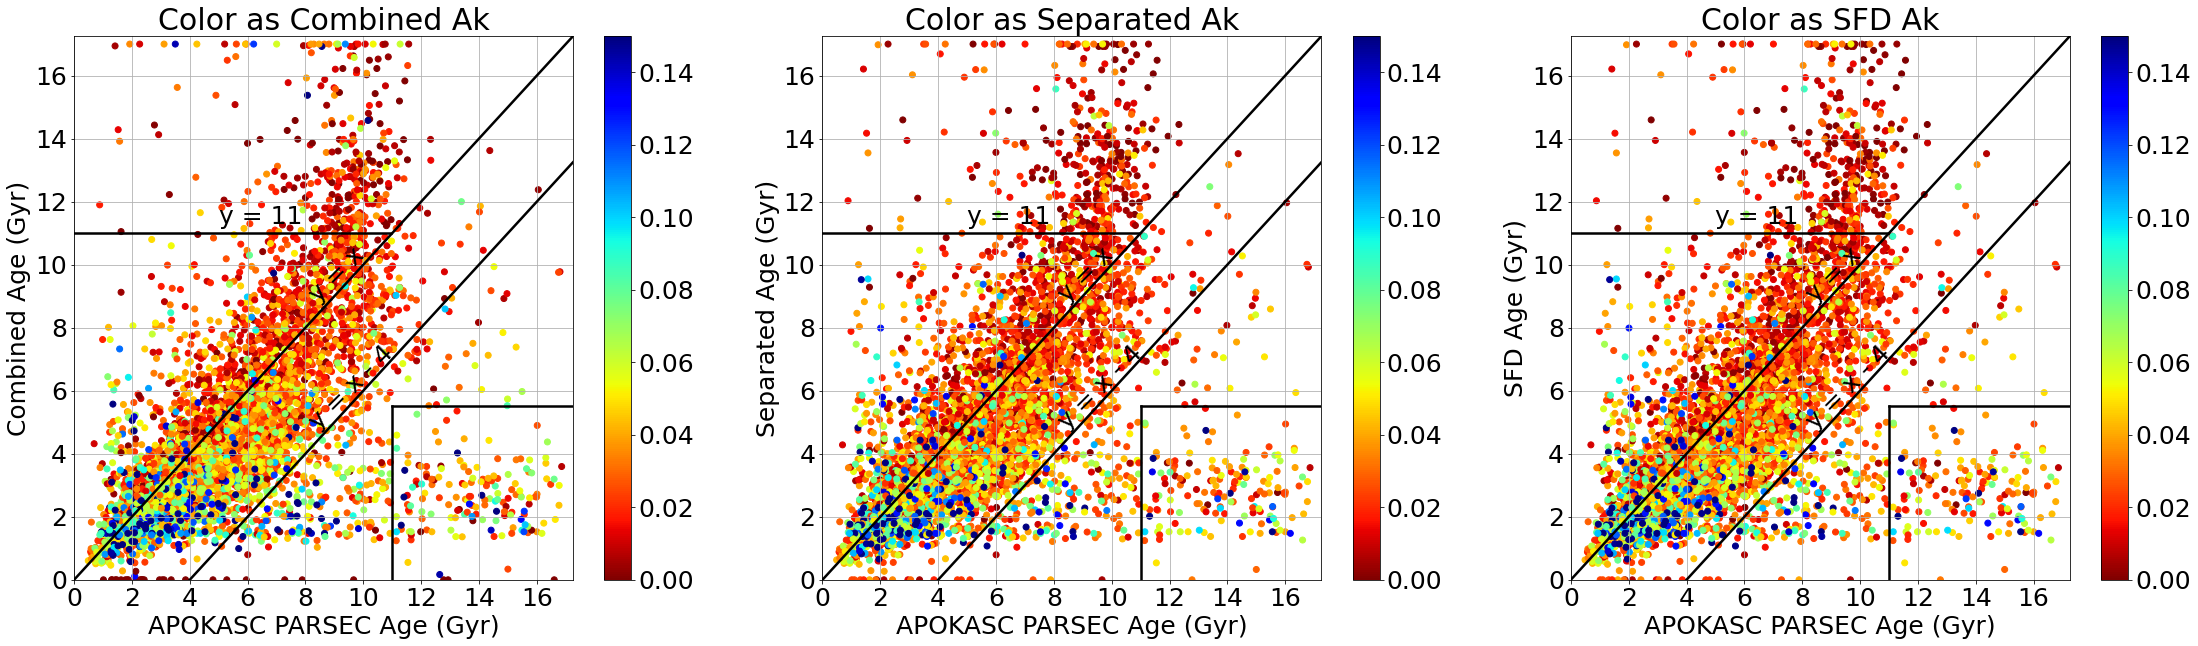

In [165]:
plt.figure(figsize=[38,10])

plt.subplot(131)
plt.scatter(agetab['PARSEC_AGE'][fincut],agetab['AGE'][fincut],c=agetab['AK'][fincut],
            cmap='jet_r',vmin=0,vmax=0.15)
plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(5,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))
plt.grid()

plt.xlabel('APOKASC PARSEC Age (Gyr)')
plt.ylabel('Combined Age (Gyr)')
cbar = plt.colorbar()
plt.title(r'Color as Combined Ak')

plt.subplot(132)
plt.scatter(agetab['PARSEC_AGE'][fincut],agetab['AGE_SEP'][fincut],c=agetab['AK_SEP'][fincut],
            cmap='jet_r',vmin=0,vmax=0.15)

plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(5,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))
plt.grid()

plt.xlabel('APOKASC PARSEC Age (Gyr)')
plt.ylabel('Separated Age (Gyr)')
cbar = plt.colorbar()
plt.title(r'Color as Separated Ak')

plt.subplot(133)
plt.scatter(agetab['PARSEC_AGE'][fincut],agetab['AGE_SFD'][fincut],c=agetab['AK_SFD'][fincut],
            cmap='jet_r',vmin=0,vmax=0.15)

plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(5,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))
plt.grid()

plt.xlabel('APOKASC PARSEC Age (Gyr)')
plt.ylabel('SFD Age (Gyr)')
cbar = plt.colorbar()
plt.title(r'Color as SFD Ak')

plt.savefig('../plots/age2age_scatter_com_sep_sfd.pdf',dpi=300,bbox_inches='tight')
plt.show()

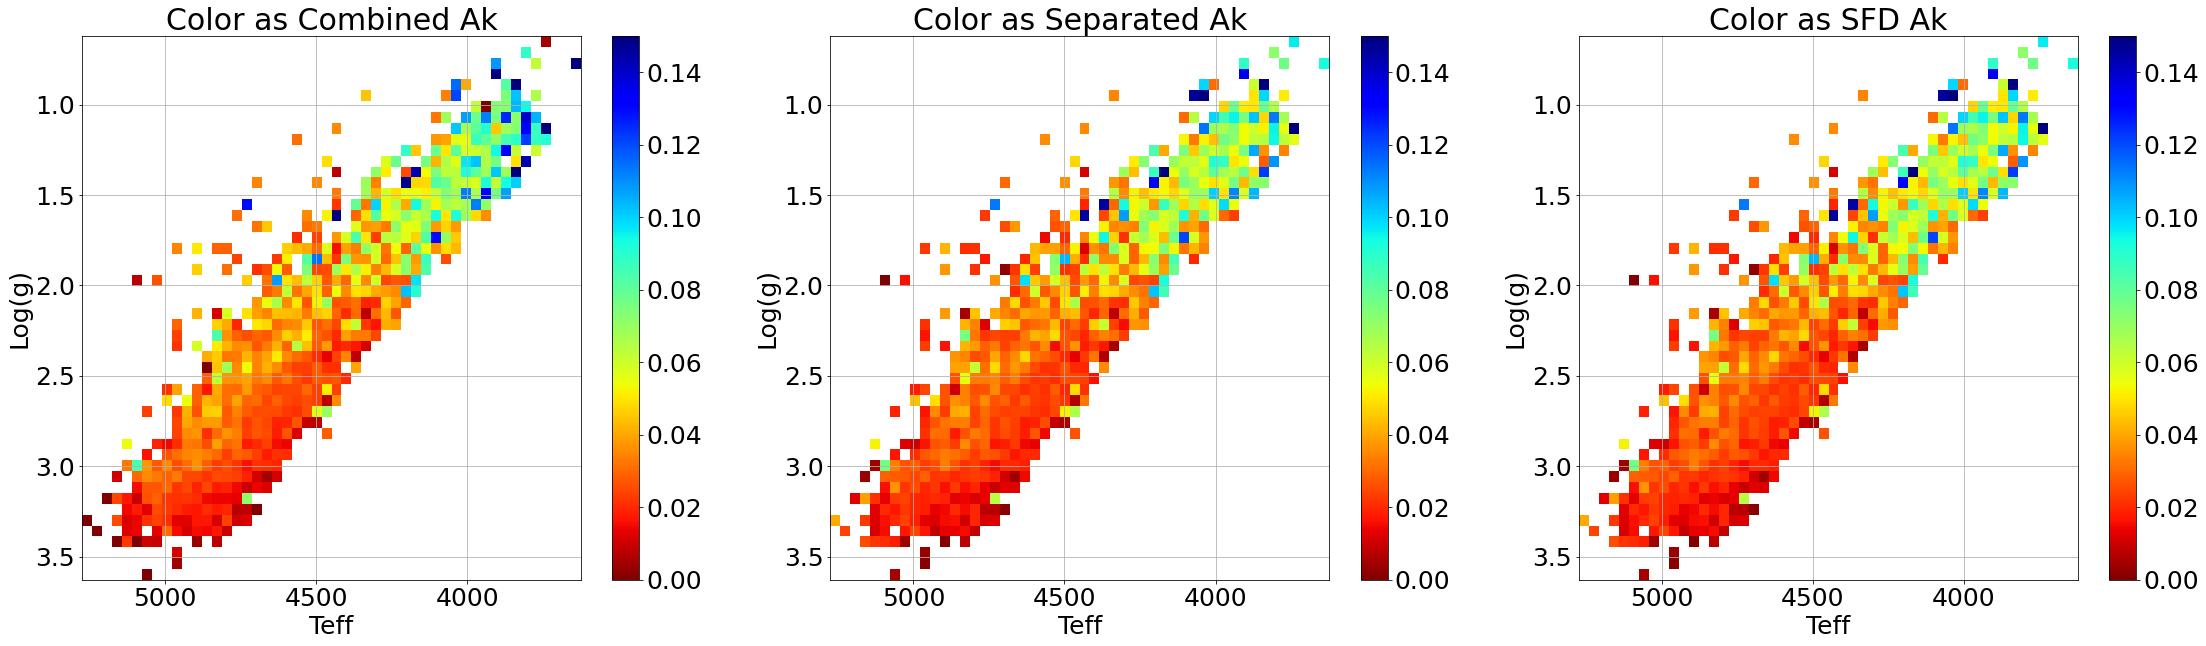

In [161]:
plt.figure(figsize=[38,10])

plt.subplot(131)
ret = binned_statistic_2d(kdr17['TEFF'][fincut],kdr17['LOGG'][fincut],agetab['AK'][fincut],bins=50)
ret.statistic[ret.statistic == 0.0] = np.nan
plt.imshow(ret.statistic.T, origin='lower',extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet_r',vmin=0,vmax=0.15)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.grid()

plt.xlabel('Teff')
plt.ylabel('Log(g)')
cbar = plt.colorbar()
plt.title(r'Color as Combined Ak')

plt.subplot(132)
ret = binned_statistic_2d(kdr17['TEFF'][fincut],kdr17['LOGG'][fincut],agetab['AK_SEP'][fincut],bins=50)
ret.statistic[ret.statistic == 0.0] = np.nan
plt.imshow(ret.statistic.T, origin='lower',extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet_r',vmin=0,vmax=0.15)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.grid()

plt.xlabel('Teff')
plt.ylabel('Log(g)')
cbar = plt.colorbar()
plt.title(r'Color as Separated Ak')

plt.subplot(133)
ret = binned_statistic_2d(kdr17['TEFF'][fincut],kdr17['LOGG'][fincut],agetab['AK_SFD'][fincut],bins=50)
ret.statistic[ret.statistic == 0.0] = np.nan
plt.imshow(ret.statistic.T, origin='lower',extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet_r',vmin=0,vmax=0.15)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.grid()

plt.xlabel('Teff')
plt.ylabel('Log(g)')
cbar = plt.colorbar()
plt.title(r'Color as SFD Ak')

plt.savefig('../plots/hr_com_sep_sfd.pdf',dpi=300,bbox_inches='tight')
plt.show()

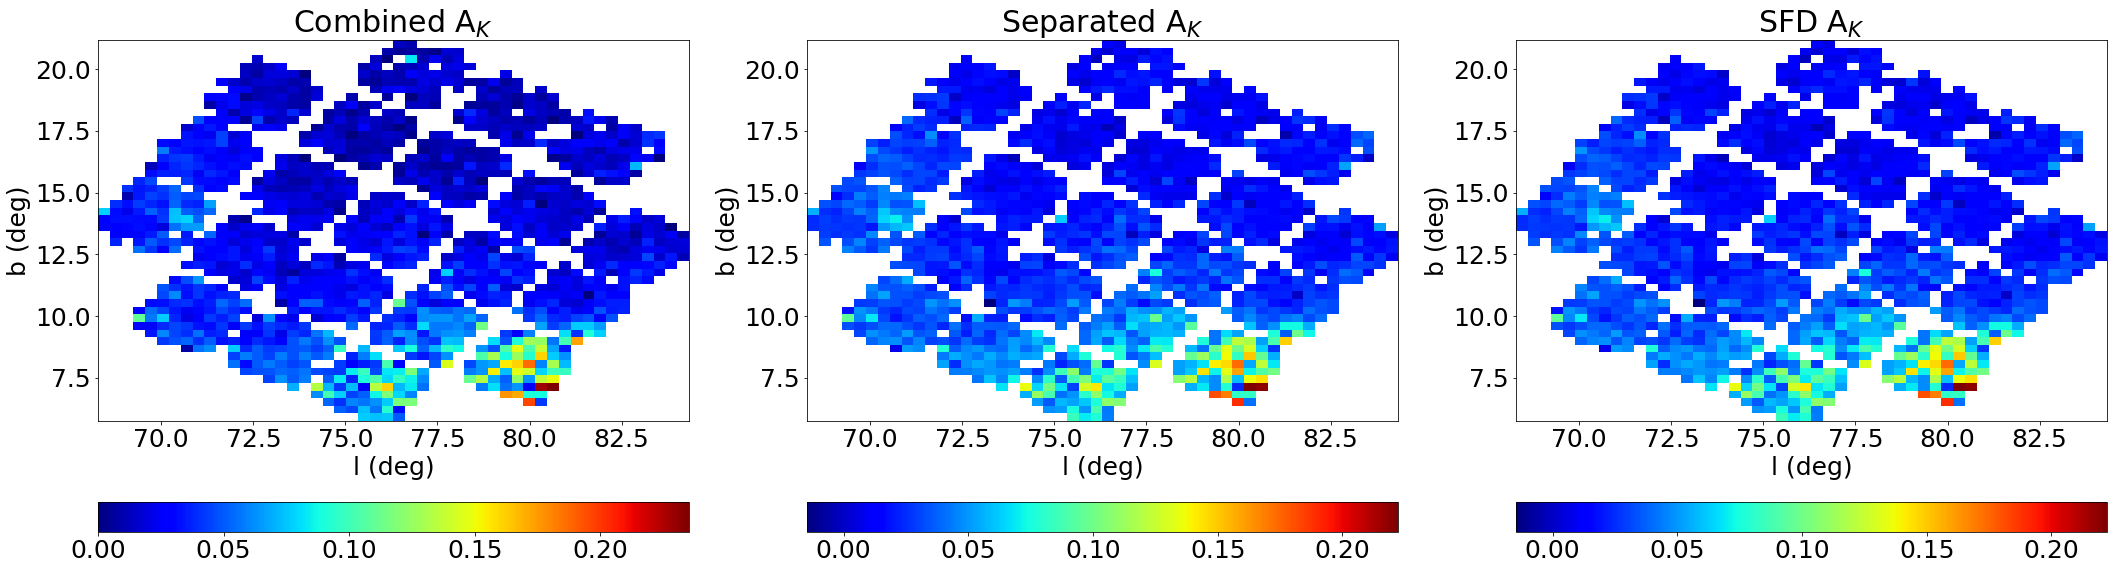

In [162]:
plt.figure(figsize=[36,10])

fincut = np.where((np.isfinite(agetab['AK'])==True)&(np.isfinite(agetab['AK_SEP'])==True)&
                  (agetab['AK']<10.)&(agetab['AK_SEP']<10.))

plt.subplot(131)
ret = binned_statistic_2d(kdr17['GLON'][fincut],kdr17['GLAT'][fincut],agetab['AK'][fincut],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet')

plt.colorbar(orientation='horizontal')

plt.title(r'Combined A$_K$')
plt.xlabel(r'l (deg)')
plt.ylabel(r'b (deg)')

plt.subplot(132)
ret = binned_statistic_2d(kdr17['GLON'][fincut],kdr17['GLAT'][fincut],agetab['AK_SEP'][fincut],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet')

plt.colorbar(orientation='horizontal')

plt.title(r'Separated A$_K$')
plt.xlabel(r'l (deg)')
plt.ylabel(r'b (deg)')

plt.subplot(133)
ret = binned_statistic_2d(kdr17['GLON'][fincut],kdr17['GLAT'][fincut],(agetab['AK_SFD'])[fincut],
                          'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet')

plt.colorbar(orientation='horizontal')

plt.title(r'SFD A$_K$')
plt.xlabel(r'l (deg)')
plt.ylabel(r'b (deg)')

plt.savefig('../plots/extmap_com_sep_sfd.pdf',dpi=300,bbox_inches='tight')
plt.show()

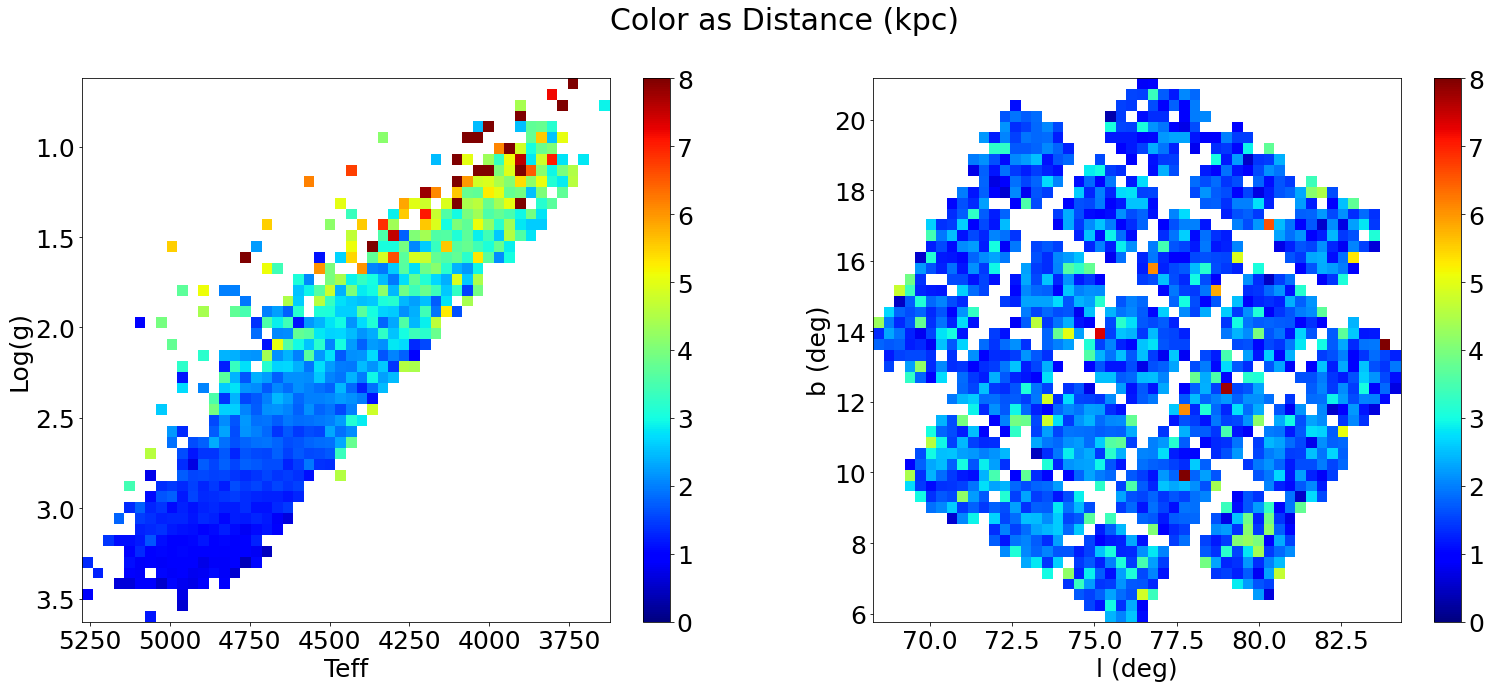

In [95]:
fincut = np.where((np.isfinite(kdr17['TEFF'])==True)&(np.isfinite(kdr17['LOGG'])==True)&
                  (np.isfinite(kdr17['GAIAEDR3_PARALLAX'])==True)&(kdr17['TEFF']>-10.)&(kdr17['LOGG']>-10.)&
                  (kdr17['GAIAEDR3_PARALLAX']>0.)) 


plt.figure(figsize=[26,10])

plt.suptitle(r'Color as Distance (kpc)')

plt.subplot(121)
ret = binned_statistic_2d(kdr17['TEFF'][fincut],kdr17['LOGG'][fincut],
                          np.reciprocal(kdr17['GAIAEDR3_PARALLAX'][fincut]),'median',bins=50)
ret.statistic[ret.statistic == 0.0] = np.nan
plt.imshow(ret.statistic.T, origin='lower',extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
           aspect='auto',interpolation='nearest',cmap='jet',vmin=0.,vmax=8.)
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

plt.subplot(122)
ret = binned_statistic_2d(kdr17['GLON'][fincut],kdr17['GLAT'][fincut],
                          np.reciprocal(kdr17['GAIAEDR3_PARALLAX'][fincut]),'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet',vmin=0.,vmax=8.)

plt.colorbar()

plt.xlabel(r'l (deg)')
plt.ylabel(r'b (deg)')

plt.savefig('distances.pdf',dpi=300,bbox_inches='tight')

plt.show()

In [117]:
kdr17.columns

ColDefs(
    name = 'APOGEE_ID'; format = '30A'
    name = 'TELESCOPE'; format = '6A'
    name = 'FIELD'; format = '20A'
    name = 'ALT_ID'; format = '30A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'AK_TARG'; format = 'E'
    name = 'AK_TARG_METHOD'; format = '32A'
    name = 'AK_WISE'; format = 'E'
    name = 'SFD_EBV'; format = 'E'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET4'; format = 'J'
    name = 'TARGFLAGS'; format = '132A'
    name = 'SURVEY'; format = '32A'
    name = 'PROGRAMNAME'; format = '32A'
    name =

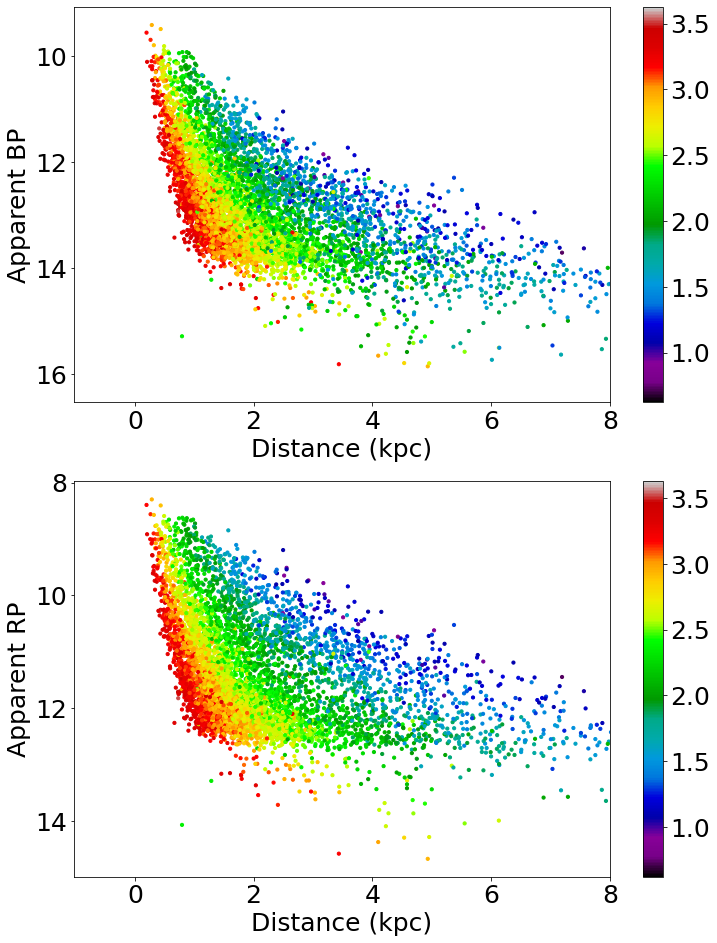

In [143]:
plt.figure(figsize=[12,16])
plt.subplot(211)
plt.scatter(np.reciprocal(kdr17['GAIAEDR3_PARALLAX']),kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'],
            c=kdr17['LOGG'],cmap='nipy_spectral',s=10)
plt.gca().invert_yaxis()

plt.xlim(right=8)

plt.colorbar()

plt.xlabel(r'Distance (kpc)')
plt.ylabel(r'Apparent BP')

plt.subplot(212)
plt.scatter(np.reciprocal(kdr17['GAIAEDR3_PARALLAX']),kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'],
            c=kdr17['LOGG'],cmap='nipy_spectral',s=10)
plt.gca().invert_yaxis()

plt.xlim(right=8)

plt.colorbar()

plt.xlabel(r'Distance (kpc)')
plt.ylabel(r'Apparent RP')

plt.savefig('../plots/dist_mag_logg.pdf',dpi=300,bbox_inches='tight')
plt.show()

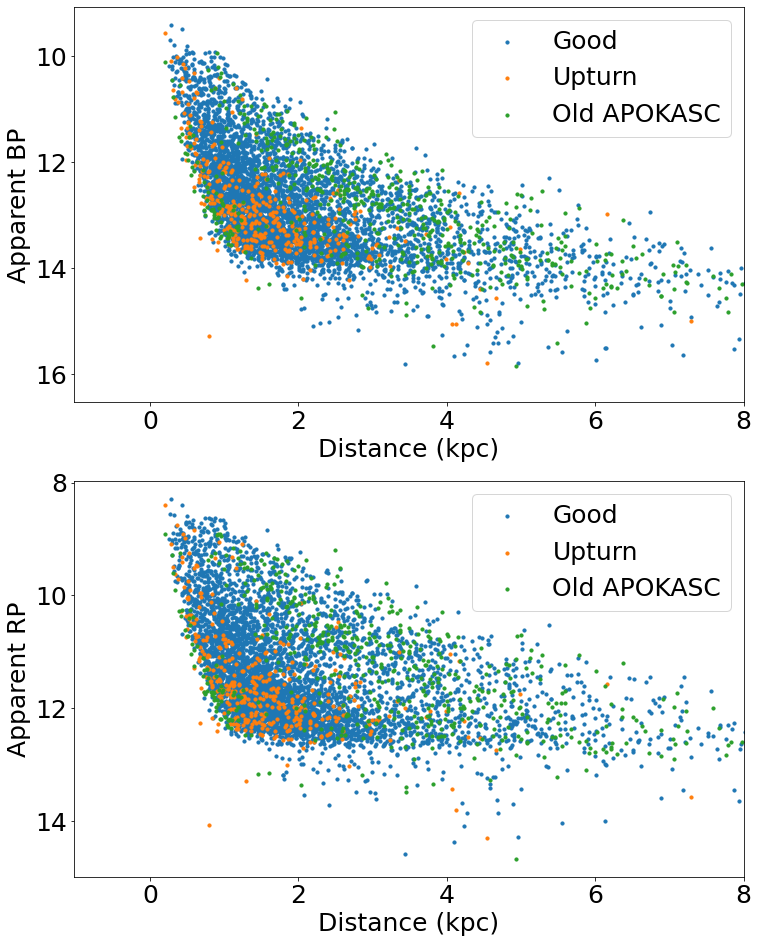

In [141]:
plt.figure(figsize=[12,16])
plt.subplot(211)
plt.scatter(np.reciprocal(kdr17['GAIAEDR3_PARALLAX'])[good_sfd],
            kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][good_sfd],s=10,label='Good')
plt.scatter(np.reciprocal(kdr17['GAIAEDR3_PARALLAX'][upturn_sfd]),
            kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][upturn_sfd],s=10,label='Upturn')
plt.scatter(np.reciprocal(kdr17['GAIAEDR3_PARALLAX'][oldkasc_sfd]),
            kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][oldkasc_sfd],s=10,label='Old APOKASC')
plt.gca().invert_yaxis()

plt.xlim(right=8)

plt.legend()

plt.xlabel(r'Distance (kpc)')
plt.ylabel(r'Apparent BP')

plt.subplot(212)
plt.scatter(np.reciprocal(kdr17['GAIAEDR3_PARALLAX'])[good_sfd],
            kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][good_sfd],s=10,label='Good')
plt.scatter(np.reciprocal(kdr17['GAIAEDR3_PARALLAX'][upturn_sfd]),
            kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][upturn_sfd],s=10,label='Upturn')
plt.scatter(np.reciprocal(kdr17['GAIAEDR3_PARALLAX'][oldkasc_sfd]),
            kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][oldkasc_sfd],s=10,label='Old APOKASC')
plt.gca().invert_yaxis()

plt.xlim(right=8)

plt.legend()

plt.xlabel(r'Distance (kpc)')
plt.ylabel(r'Apparent RP')

plt.savefig('../plots/dist_mag.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [106]:
i=0
print('Ak: ',kasc_ak[i])
print('Age: ',kasc_age[i])
print('Chi: ',kasc_chi[i])
print('RMSE: ',kasc_rms[i])
print('----------')

Ak:  0.006646514505329326
Age:  16.924856754882935
Chi:  33.3883824493182
RMSE:  0.05189229977710105
----------


In [107]:
CalcAge.extinction()

(0.0007650217050511387, 0.0015869046086298781)

In [108]:
CalcAge.get_age()

16.924856713193428

In [109]:
16.924856754882935-16.924856713193428

4.1689506957709455e-08

In [73]:
for i in range(10):
    print('Ak: ',kasc_ak[i])
    print('Age: ',kasc_age[i])
    print('Chi: ',kasc_chi[i])
    print('RMSE: ',kasc_rms[i])
    print('----------')

Ak:  0.7484765225058039
Age:  4.174697425464164
Chi:  4417723.0189058585
RMSE:  0.7484765225058039
----------
Ak:  0.42676898734582835
Age:  14.575048051332384
Chi:  3984761.2902889987
RMSE:  0.42676898734582835
----------
Ak:  0.7499315336571295
Age:  16.67496775608157
Chi:  8740985.763677713
RMSE:  0.7499315336571295
----------
Ak:  0.7499999999999942
Age:  16.999999999999996
Chi:  7486096.185341542
RMSE:  0.7499999999999942
----------
Ak:  0.4594961088931355
Age:  0.05590168661800915
Chi:  117843.08854097356
RMSE:  0.4594961088931355
----------
Ak:  0.7421132724536861
Age:  2.3744608318065263
Chi:  4117633.3568290696
RMSE:  0.7421132724536861
----------
Ak:  0.7499212296681119
Age:  14.274798970990489
Chi:  11220924.884216713
RMSE:  0.7499212296681119
----------
Ak:  0.749999999999996
Age:  16.999999999999996
Chi:  7075069.2805571975
RMSE:  0.749999999999996
----------
Ak:  0.7308037807382929
Age:  3.774678822020942
Chi:  5284079.166801072
RMSE:  0.7308037807382929
----------
Ak:  9

(0.0, 17.5)

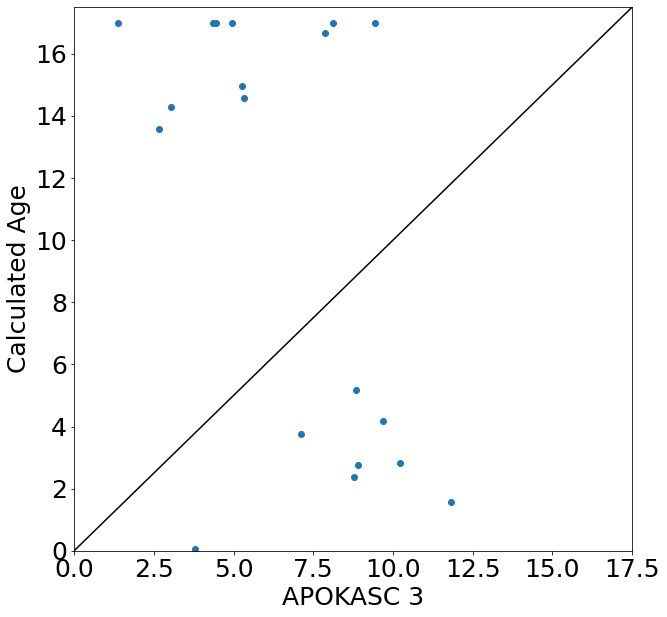

In [74]:
plt.figure(figsize=[10,10])
plt.scatter(kasc_parsec_age,kasc_age)
plt.plot([0,17.5],[0,17.5],c='k')
plt.xlabel(r'APOKASC 3')
plt.ylabel(r'Calculated Age')

plt.xlim(0,17.5)
plt.ylim(0,17.5)

In [75]:
kasc_parsec_age[0]

9.69074878423179

Text(0, 0.5, 'Magnitude')

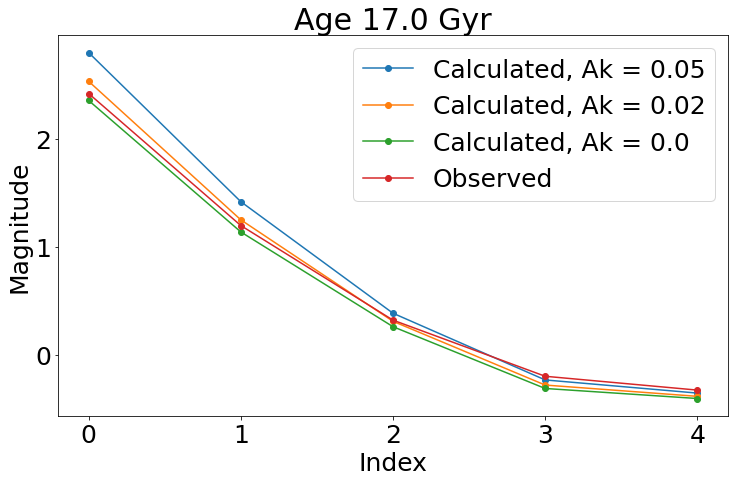

In [99]:
i=0
# Initialize Aetas 
te = np.array([kdr17['TEFF'][i],kdr17['TEFF_ERR'][i]])
ab = np.array([[kdr17['FE_H'][i],apoafe[i]],
               [kdr17['FE_H_ERR'][i],apoafe_err[i]]]).T
op = np.array([[kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                kdr17['J'][i],kdr17['H'][i],
                kdr17['K'][i]],
               [bperr[i],rperr[i],kdr17['J_ERR'][i],
                kdr17['H_ERR'][i],kdr17['K_ERR'][i]]]).T
di = (1/kdr17['GAIAEDR3_PARALLAX'][i])*1000

CalcAge = Aetas(te,ab,op,di,massive,rv=3.1)

test_age = 17.

calc_abs5 = CalcAge.teff_2_absmags_curvefit(te[0],ak=0.05,age=test_age)
calc_abs2 = CalcAge.teff_2_absmags_curvefit(te[0],ak=0.02,age=test_age)
calc_abs0 = CalcAge.teff_2_absmags_curvefit(te[0],ak=0.0,age=test_age)
obs_abs = CalcAge.absphot

plt.figure(figsize=[12,7])
plt.plot(range(5),calc_abs5,label='Calculated, Ak = 0.05',ls='-',marker='o')
plt.plot(range(5),calc_abs2,label='Calculated, Ak = 0.02',ls='-',marker='o')
plt.plot(range(5),calc_abs0,label='Calculated, Ak = 0.0',ls='-',marker='o')
plt.plot(range(5),obs_abs,label='Observed',ls='-',marker='o')
plt.legend()
plt.title(r'Age {} Gyr'.format(test_age))
plt.xlabel('Index')
plt.ylabel('Magnitude')

In [101]:
popt,_ = curve_fit(CalcAge.teff_2_absmags_curvefit,CalcAge.teff,CalcAge.absphot,
                   p0=[0.1,5.0],bounds=((0.,0.),(0.75,17.)),method='trf',sigma=CalcAge.phot_err,
                   absolute_sigma=True,maxfev=5000)

print(popt)

[ 0.02822028 13.97478077]


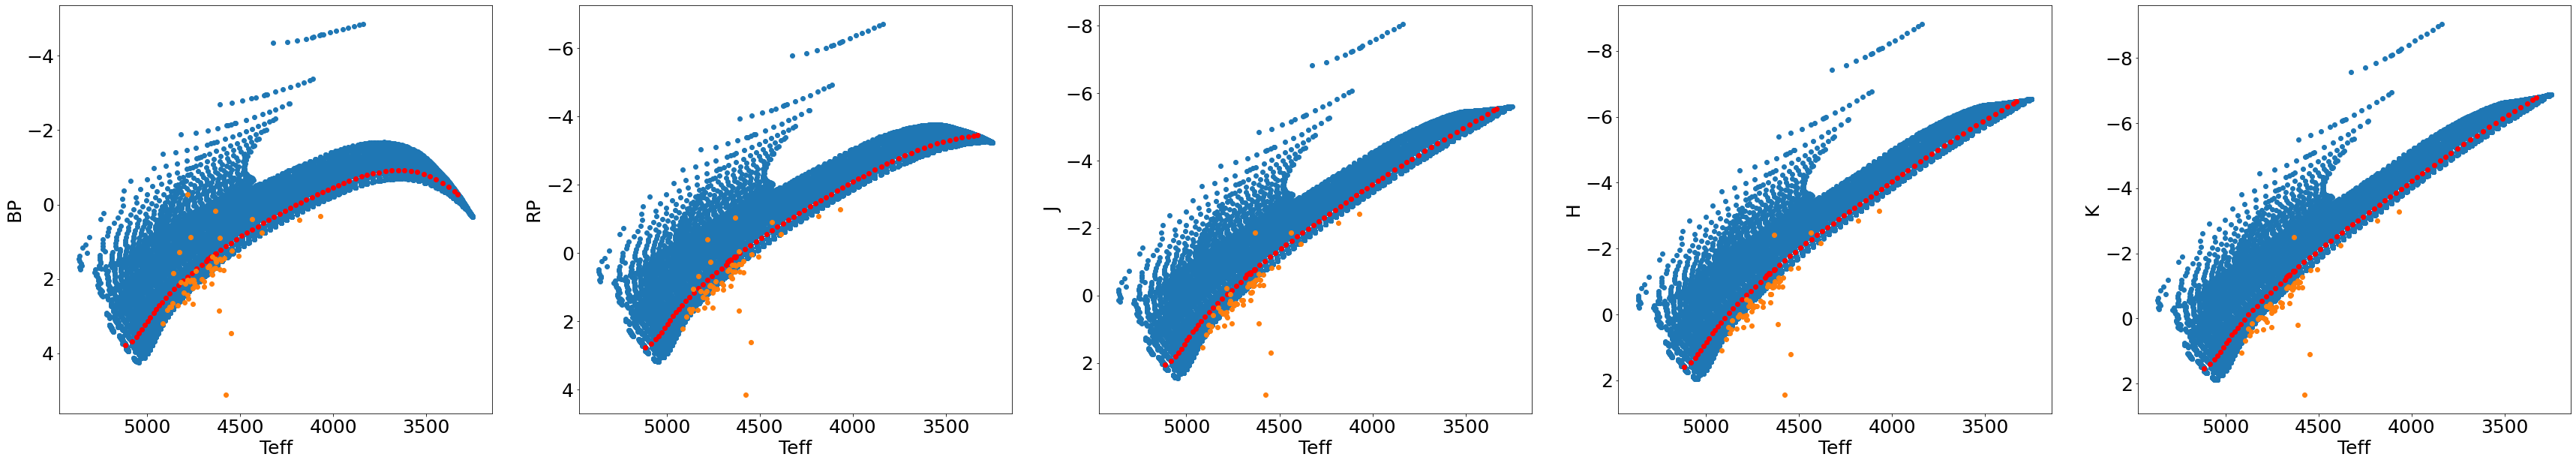

In [263]:
narrofeh = np.where((kdr17['FE_H'][upturn]<-0.3+0.05)&(kdr17['FE_H'][upturn]>-0.3-0.05))
iso_03 = massive[np.where(massive['MH']==closest(massive['MH'],-0.3))]

iso10_03 = massive[np.where((massive['MH']==closest(massive['MH'],-0.3))&
                            (massive['logAge']==closest(massive['logAge'],10.)))]

bands = np.array(['GAIAEDR3_PHOT_BP_MEAN_MAG','GAIAEDR3_PHOT_RP_MEAN_MAG','J','H','K'])
pbands = np.array(['G_BPmag','G_RPmag','Jmag','Hmag','Ksmag'])
ylabs = np.array(['BP','RP','J','H','K'])

extinctions = np.array([abp_ebv,arp_ebv,aj_ebv,ah_ebv,ak_ebv])

offset = 0

fig, ax = plt.subplots(1,5,figsize=[60,10])
for i in range(5):
    
    ax[i].scatter(10**iso_03['logTe'],iso_03[pbands[i]])
    ax[i].scatter(10**iso10_03['logTe'],iso10_03[pbands[i]],c='r')
    
    absmags = kdr17[bands[i]][upturn][narrofeh]-5*np.log10((1/kdr17['GAIAEDR3_PARALLAX'][upturn][narrofeh])*1000)+5
    ax[i].scatter(kdr17['TEFF'][upturn][narrofeh]+offset,absmags-kdr17['SFD_EBV'][upturn][narrofeh]*extinctions[i])
    ax[i].invert_yaxis()
    ax[i].invert_xaxis()
    
    ax[i].set_xlabel(r'Teff')
    ax[i].set_ylabel(r'{}'.format(ylabs[i]))
plt.show()

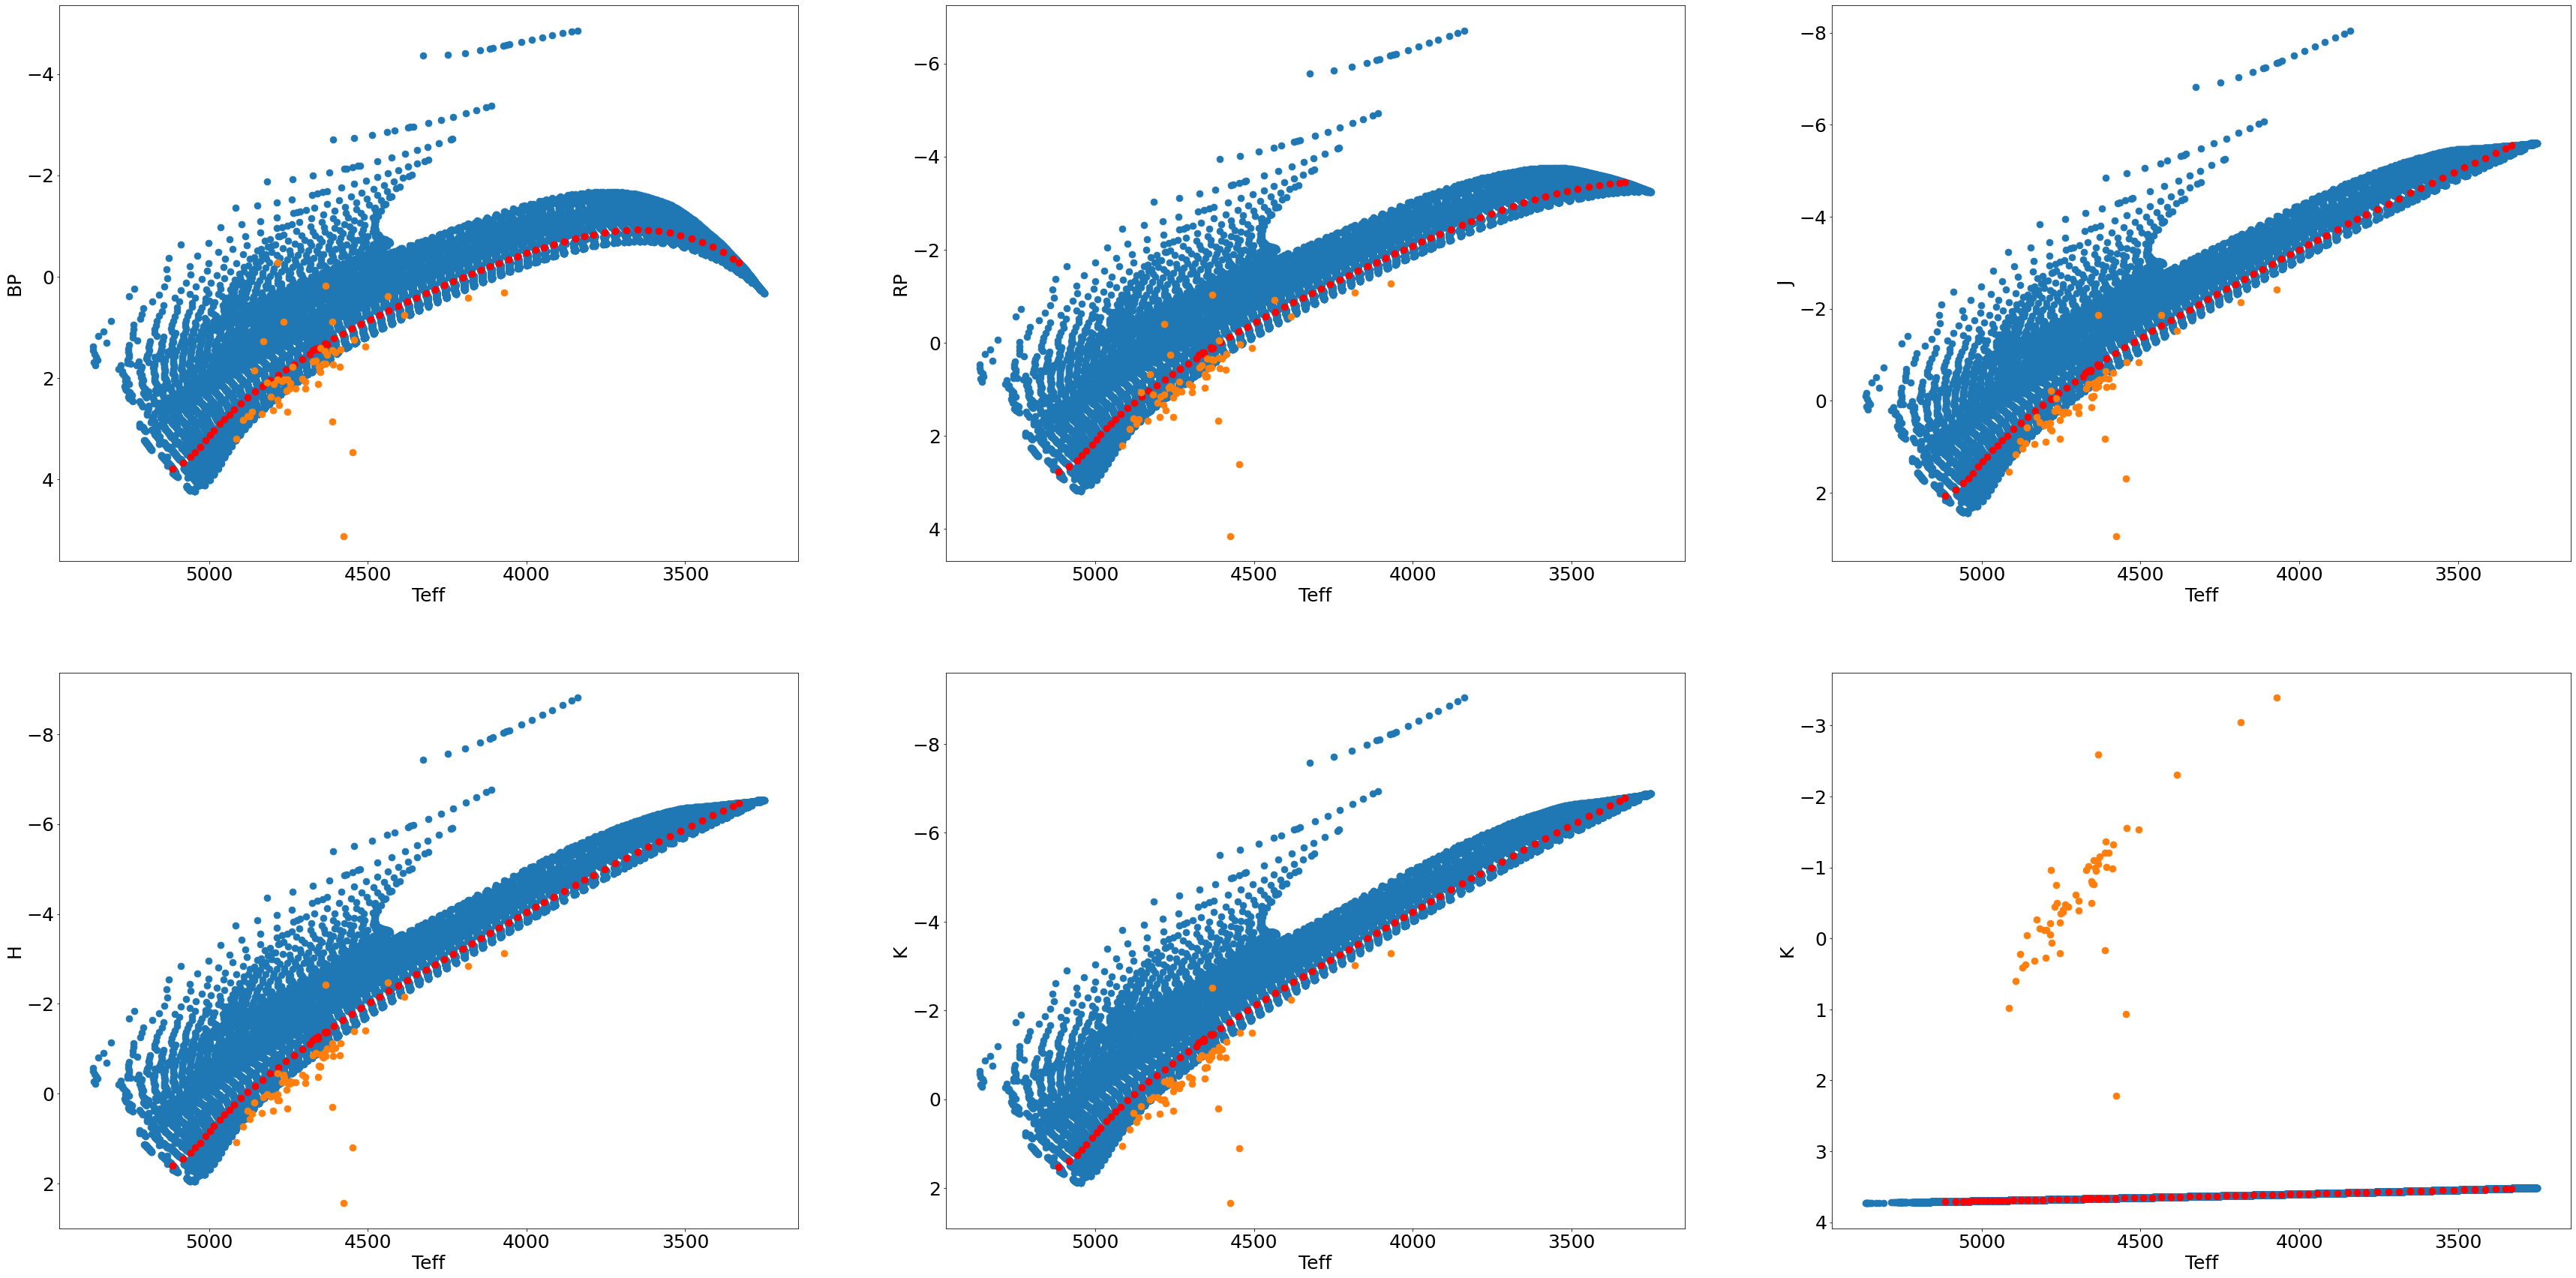

In [274]:
bands = np.array([['GAIAEDR3_PHOT_BP_MEAN_MAG','GAIAEDR3_PHOT_RP_MEAN_MAG','J'],['H','K','K']])
pbands = np.array([['G_BPmag','G_RPmag','Jmag'],['Hmag','Ksmag','logTe']])
ylabs = np.array([['BP','RP','J'],['H','K','K']])

extinctions = np.array([[abp_ebv,arp_ebv,aj_ebv],[ah_ebv,ak_ebv,1.]])

offset = 0

fig, ax = plt.subplots(2,3,figsize=[60,30])
for i in range(2):
    for j in range(3):
    
        ax[i,j].scatter(10**iso_03['logTe'],iso_03[pbands[i,j]],s=75)
        ax[i,j].scatter(10**iso10_03['logTe'],iso10_03[pbands[i,j]],c='r',s=75)

        absmags = kdr17[bands[i,j]][upturn][narrofeh]-5*np.log10((1/kdr17['GAIAEDR3_PARALLAX'][upturn][narrofeh])*1000)+5
        ax[i,j].scatter(kdr17['TEFF'][upturn][narrofeh]+offset,absmags-kdr17['SFD_EBV'][upturn][narrofeh]*extinctions[i,j],s=75)
        ax[i,j].invert_yaxis()
        ax[i,j].invert_xaxis()

        ax[i,j].set_xlabel(r'Teff')
        ax[i,j].set_ylabel(r'{}'.format(ylabs[i,j]))
plt.show()

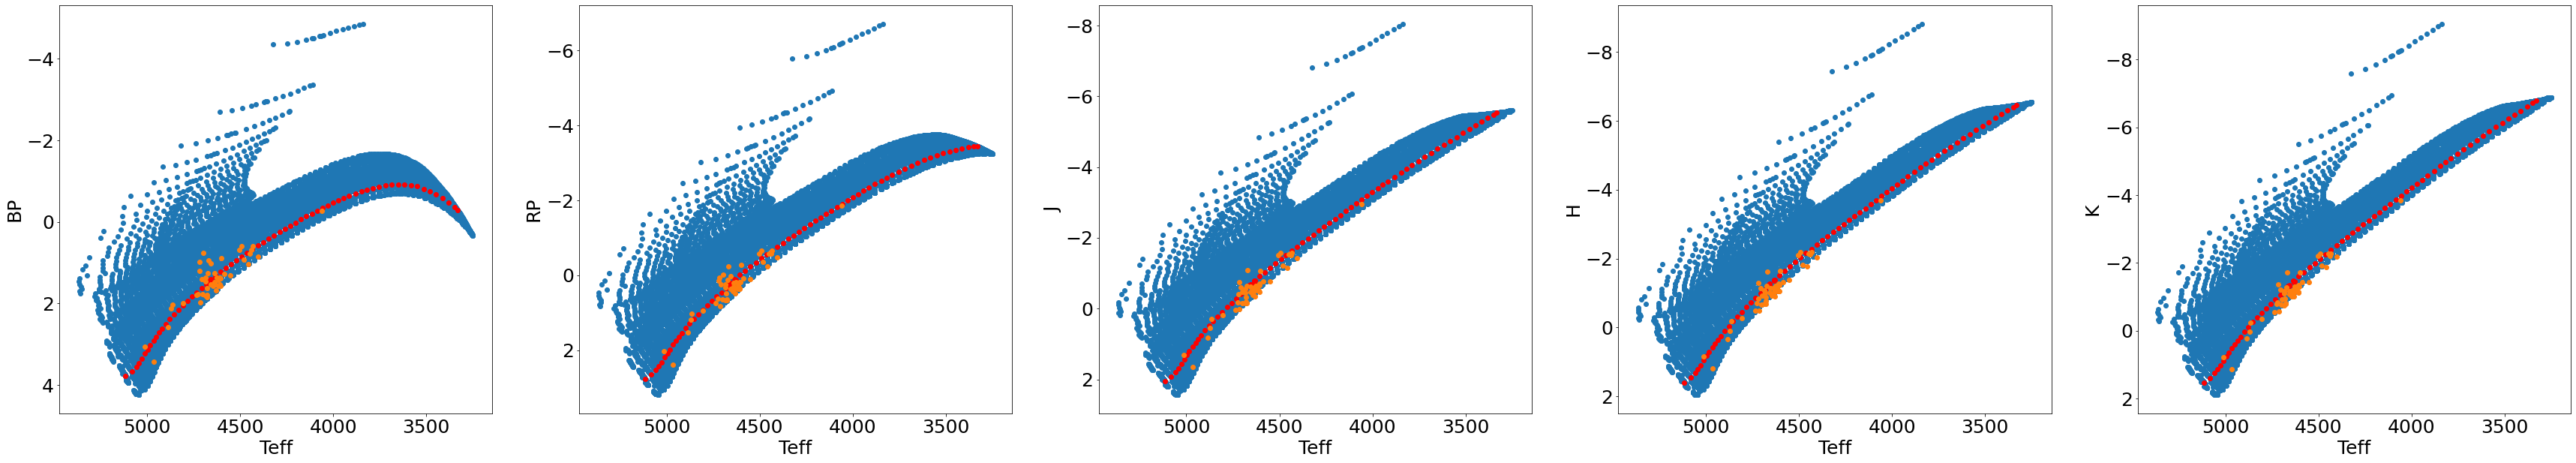

In [262]:
narrofehage = np.where((kdr17['FE_H'][good]<-0.3+0.05)&(kdr17['FE_H'][good]>-0.3-0.05)&
                       (k3dr17['IntAge'][good]<10.+1.0)&(k3dr17['IntAge'][good]>10.-1.0))
iso_03 = massive[np.where(massive['MH']==closest(massive['MH'],-0.3))]

iso10_03 = massive[np.where((massive['MH']==closest(massive['MH'],-0.3))&
                            (massive['logAge']==closest(massive['logAge'],10.)))]

bands = np.array(['GAIAEDR3_PHOT_BP_MEAN_MAG','GAIAEDR3_PHOT_RP_MEAN_MAG','J','H','K'])
pbands = np.array(['G_BPmag','G_RPmag','Jmag','Hmag','Ksmag'])
ylabs = np.array(['BP','RP','J','H','K'])

extinctions = np.array([abp_ebv,arp_ebv,aj_ebv,ah_ebv,ak_ebv])

offset = 0.

fig, ax = plt.subplots(1,5,figsize=[60,10])
for i in range(5):
    
    ax[i].scatter(10**iso_03['logTe'],iso_03[pbands[i]])
    ax[i].scatter(10**iso10_03['logTe'],iso10_03[pbands[i]],c='r')
    
    absmags = kdr17[bands[i]][good][narrofehage]-5*np.log10((1/kdr17['GAIAEDR3_PARALLAX'][good][narrofehage])*1000)+5
    ax[i].scatter(kdr17['TEFF'][good][narrofehage]+offset,absmags-kdr17['SFD_EBV'][good][narrofehage]*extinctions[i])
    ax[i].invert_yaxis()
    ax[i].invert_xaxis()
    
    ax[i].set_xlabel(r'Teff')
    ax[i].set_ylabel(r'{}'.format(ylabs[i]))
plt.show()

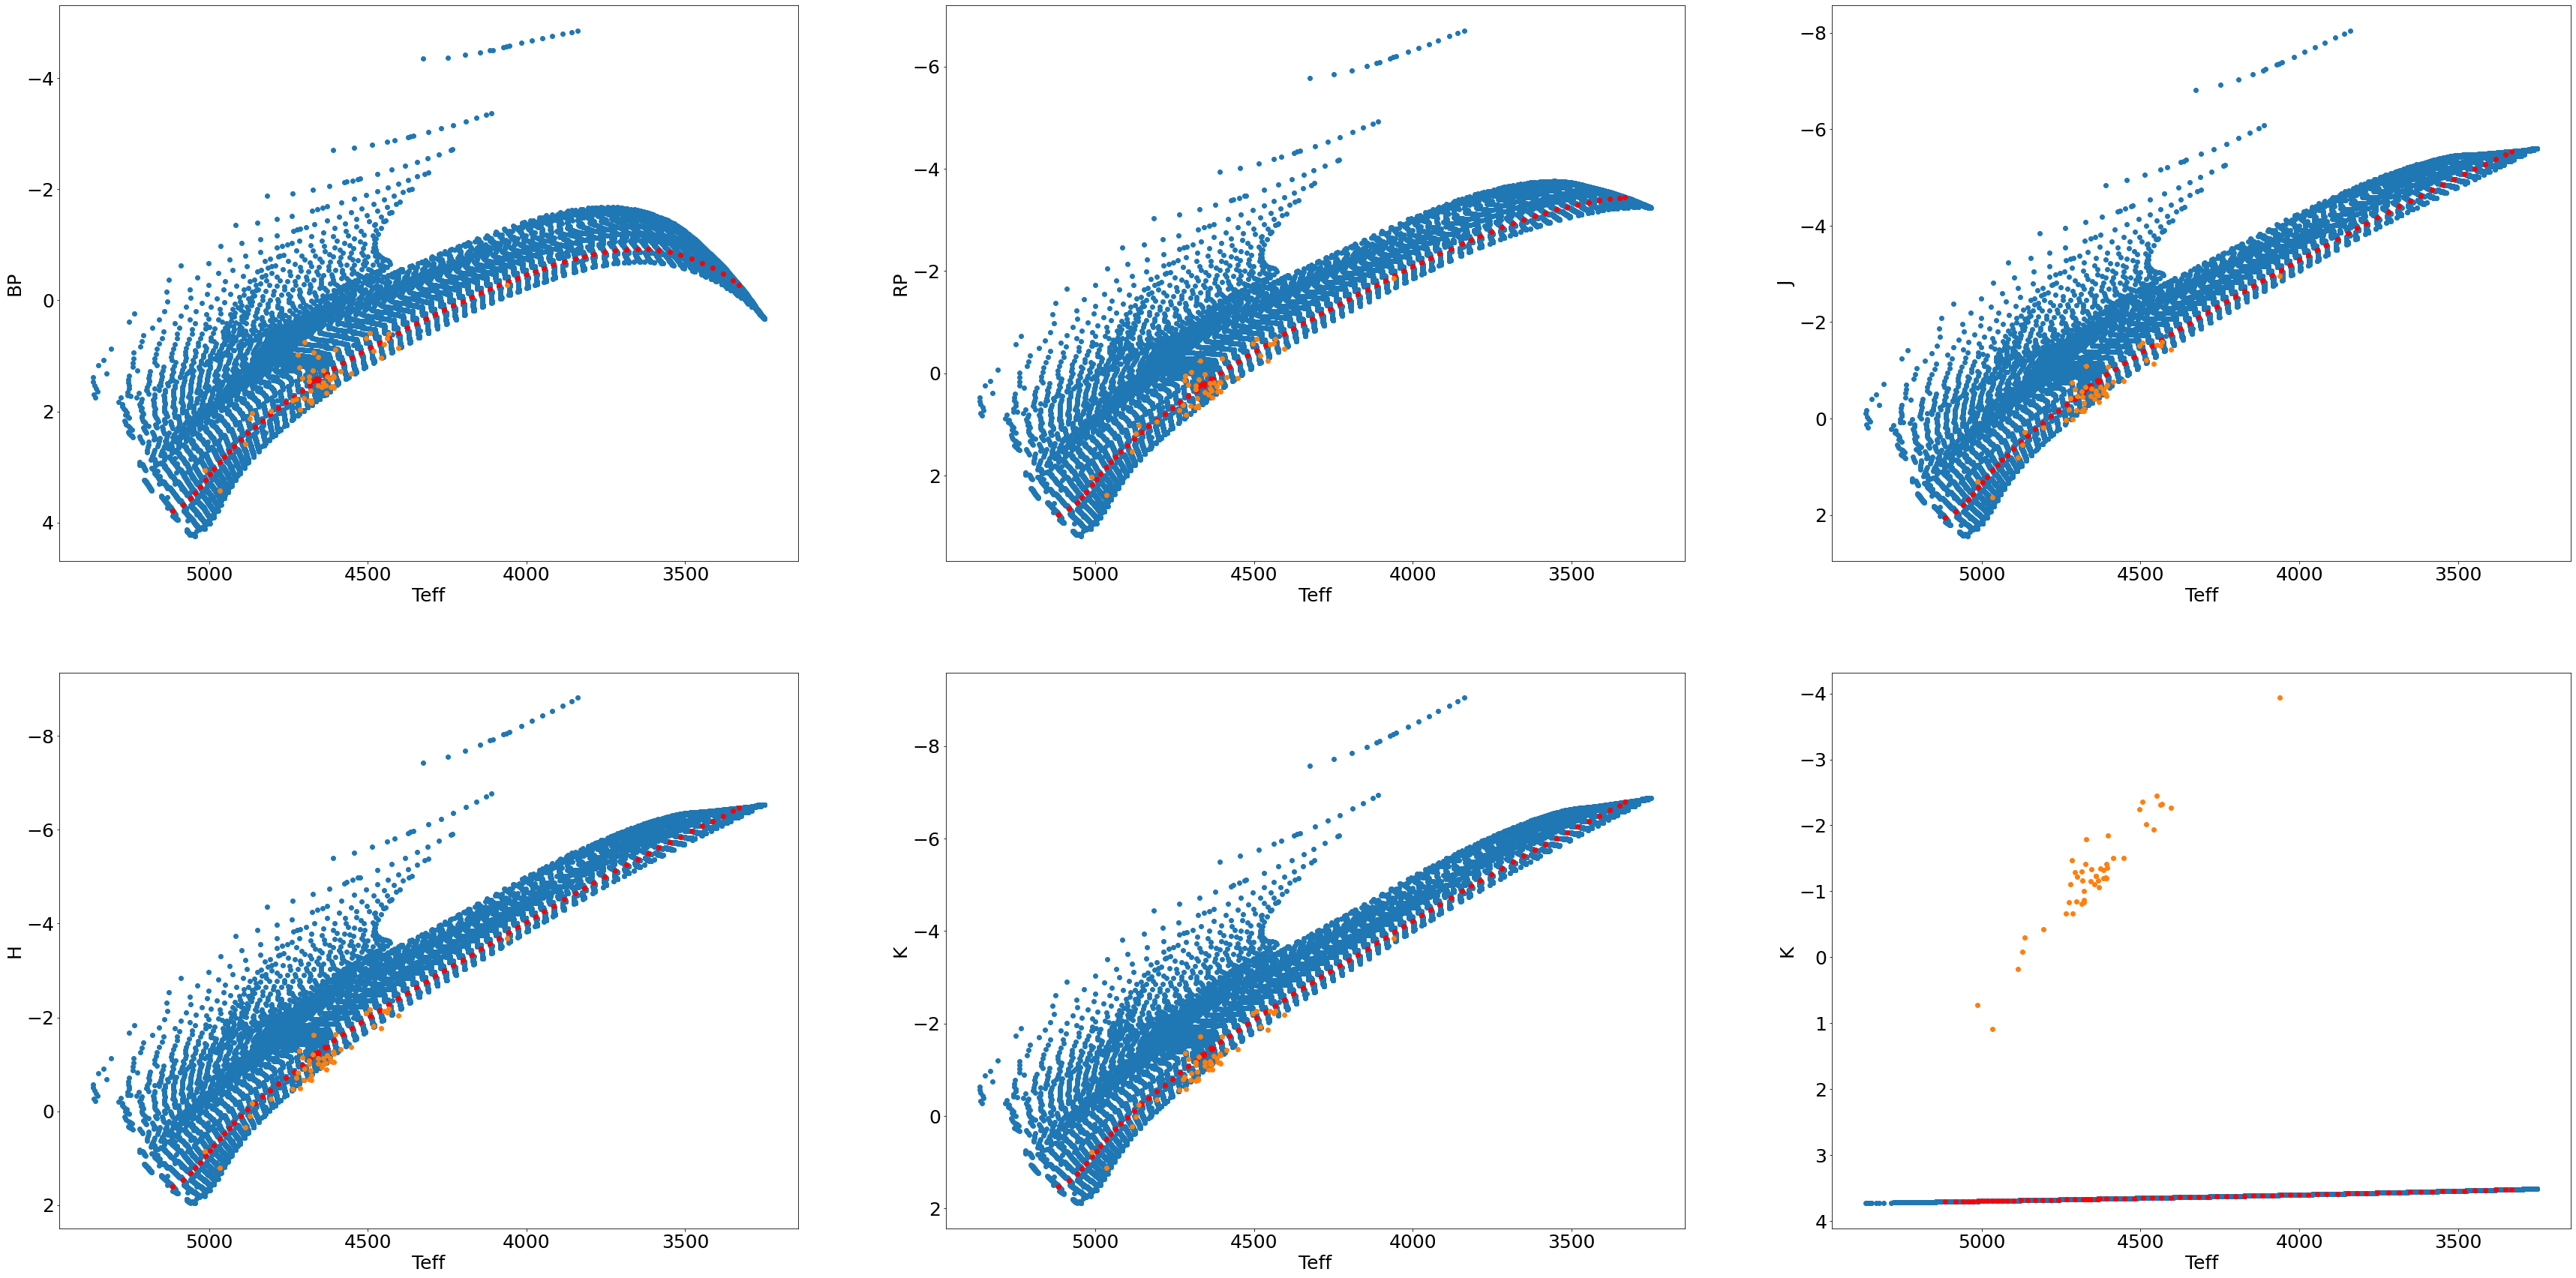

In [269]:
bands = np.array([['GAIAEDR3_PHOT_BP_MEAN_MAG','GAIAEDR3_PHOT_RP_MEAN_MAG','J'],['H','K','K']])
pbands = np.array([['G_BPmag','G_RPmag','Jmag'],['Hmag','Ksmag','logTe']])
ylabs = np.array([['BP','RP','J'],['H','K','K']])

extinctions = np.array([[abp_ebv,arp_ebv,aj_ebv],[ah_ebv,ak_ebv,1.]])

offset = 0

fig, ax = plt.subplots(2,3,figsize=[60,30])
for i in range(2):
    for j in range(3):
    
        ax[i,j].scatter(10**iso_03['logTe'],iso_03[pbands[i,j]])
        ax[i,j].scatter(10**iso10_03['logTe'],iso10_03[pbands[i,j]],c='r')

        absmags = kdr17[bands[i,j]][good][narrofehage]-5*np.log10((1/kdr17['GAIAEDR3_PARALLAX'][good][narrofehage])*1000)+5
        ax[i,j].scatter(kdr17['TEFF'][good][narrofehage]+offset,absmags-kdr17['SFD_EBV'][good][narrofehage]*extinctions[i,j])
        ax[i,j].invert_yaxis()
        ax[i,j].invert_xaxis()

        ax[i,j].set_xlabel(r'Teff')
        ax[i,j].set_ylabel(r'{}'.format(ylabs[i,j]))
plt.show()

Text(0, 0.5, 'K')

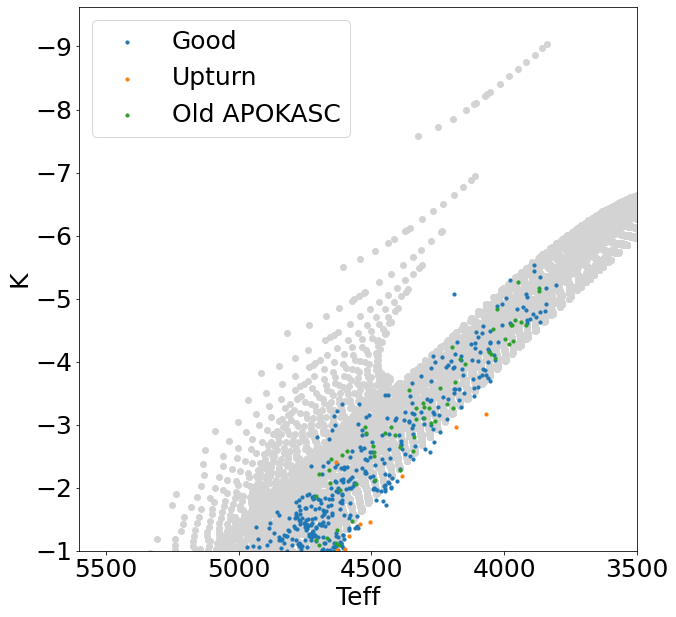

In [253]:
good_03 = np.where((kdr17['FE_H'][good]<-0.3+0.05)&(kdr17['FE_H'][good]>-0.3-0.05))
upturn_03 = np.where((kdr17['FE_H'][upturn]<-0.3+0.05)&(kdr17['FE_H'][upturn]>-0.3-0.05))
oldkasc_03 = np.where((kdr17['FE_H'][oldkasc]<-0.3+0.05)&(kdr17['FE_H'][oldkasc]>-0.3-0.05))

plt.figure(figsize=[10,10])
plt.scatter(10**iso_03['logTe'],iso_03['Ksmag'],c='lightgrey')

plt.scatter(kdr17['TEFF'][good][good_03],kdr17['K'][good][good_03]-
            5*np.log10((1/kdr17['GAIAEDR3_PARALLAX'][good][good_03])*1000)+5+
            kdr17['SFD_EBV'][good][good_03]*ak_ebv,s=10,label='Good')

plt.scatter(kdr17['TEFF'][upturn][upturn_03],kdr17['K'][upturn][upturn_03]-
            5*np.log10((1/kdr17['GAIAEDR3_PARALLAX'][upturn][upturn_03])*1000)+5+
            kdr17['SFD_EBV'][upturn][upturn_03]*ak_ebv,s=10,label='Upturn')

plt.scatter(kdr17['TEFF'][oldkasc][oldkasc_03],kdr17['K'][oldkasc][oldkasc_03]-
            5*np.log10((1/kdr17['GAIAEDR3_PARALLAX'][oldkasc][oldkasc_03])*1000)+5+
            kdr17['SFD_EBV'][oldkasc][oldkasc_03]*ak_ebv,s=10,label='Old APOKASC')

plt.legend()

plt.xlim(3500,5600)
plt.ylim(top=-1)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xlabel(r'Teff')
plt.ylabel(r'K')

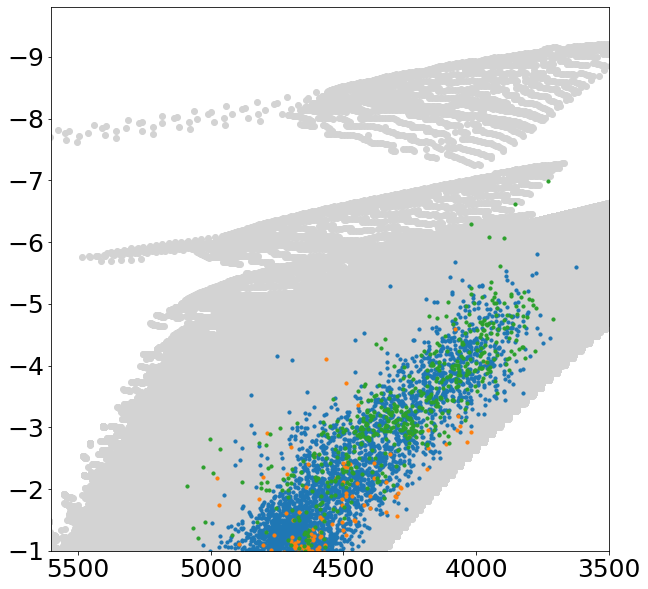

In [256]:
plt.figure(figsize=[10,10])
plt.scatter(10**massive['logTe'],massive['Ksmag'],c='lightgrey')

plt.scatter(kdr17['TEFF'][good],kdr17['K'][good]-
            5*np.log10((1/kdr17['GAIAEDR3_PARALLAX'][good])*1000)+5+
            kdr17['SFD_EBV'][good]*ak_ebv,s=10,label='Good')

plt.scatter(kdr17['TEFF'][upturn],kdr17['K'][upturn]-
            5*np.log10((1/kdr17['GAIAEDR3_PARALLAX'][upturn])*1000)+5+
            kdr17['SFD_EBV'][upturn]*ak_ebv,s=10,label='Upturn')

plt.scatter(kdr17['TEFF'][oldkasc],kdr17['K'][oldkasc]-
            5*np.log10((1/kdr17['GAIAEDR3_PARALLAX'][oldkasc])*1000)+5+
            kdr17['SFD_EBV'][oldkasc]*ak_ebv,s=10,label='Old APOKASC')

# plt.legend()

plt.xlim(3500,5600)
plt.ylim(top=-1)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [218]:
kdr17.columns

ColDefs(
    name = 'FILE'; format = '64A'
    name = 'APOGEE_ID'; format = '30A'
    name = 'TARGET_ID'; format = '58A'
    name = 'APSTAR_ID'; format = '71A'
    name = 'ASPCAP_ID'; format = '69A'
    name = 'TELESCOPE'; format = '6A'
    name = 'LOCATION_ID'; format = 'J'
    name = 'FIELD'; format = '20A'
    name = 'ALT_ID'; format = '30A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'SRC_H'; format = '16A'
    name = 'WASH_M'; format = 'E'
    name = 'WASH_M_ERR'; format = 'E'
    name = 'WASH_T2'; format = 'E'
    name = 'WASH_T2_ERR'; format = 'E'
    name = 'DDO51'; format = 'E'
    name = 'DDO51_ERR'; format = 'E'
    name = 'IRAC_3_6'; format = 'E'
    name = 'IRAC_3_6_ERR'; format = 'E'
    name = 'IRA

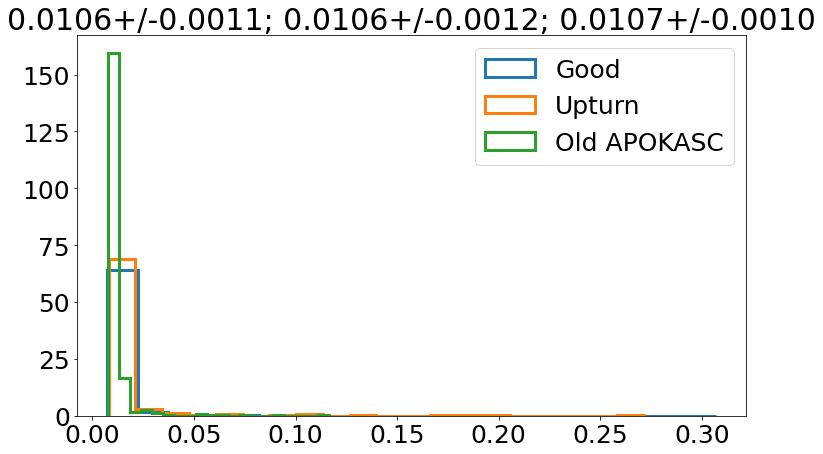

In [247]:
plt.figure(figsize=[12,7])
plt.hist(kdr17['GAIAEDR3_PARALLAX_ERROR'][good],density=True,histtype='step',lw=3.0,bins=20,label='Good')
plt.hist(kdr17['GAIAEDR3_PARALLAX_ERROR'][upturn],density=True,histtype='step',lw=3.0,bins=20,label='Upturn')
plt.hist(kdr17['GAIAEDR3_PARALLAX_ERROR'][oldkasc],density=True,histtype='step',lw=3.0,bins=20,label='Old APOKASC')
plt.title(r'{:.4f}+/-{:.4f}; {:.4f}+/-{:.4f}; {:.4f}+/-{:.4f}'.format(np.median(kdr17['GAIAEDR3_PARALLAX_ERROR'][good]),
                                              mad(kdr17['GAIAEDR3_PARALLAX_ERROR'][good]),
                                              np.median(kdr17['GAIAEDR3_PARALLAX_ERROR'][upturn]),
                                              mad(kdr17['GAIAEDR3_PARALLAX_ERROR'][upturn]),
                                              np.median(kdr17['GAIAEDR3_PARALLAX_ERROR'][oldkasc]),
                                              mad(kdr17['GAIAEDR3_PARALLAX_ERROR'][oldkasc])))
plt.legend()
plt.show()

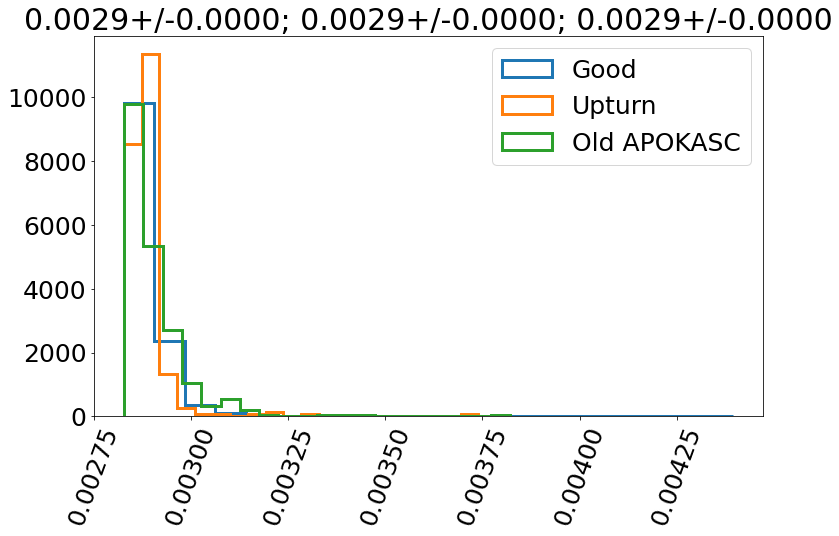

In [248]:
plt.figure(figsize=[12,7])
plt.hist(bperr[good],density=True,histtype='step',lw=3.0,bins=20,label='Good')
plt.hist(bperr[upturn],density=True,histtype='step',lw=3.0,bins=20,label='Upturn')
plt.hist(bperr[oldkasc],density=True,histtype='step',lw=3.0,bins=20,label='Old APOKASC')
plt.title(r'{:.4f}+/-{:.4f}; {:.4f}+/-{:.4f}; {:.4f}+/-{:.4f}'.format(np.median(bperr[good]),
                                              mad(bperr[good]),
                                              np.median(bperr[upturn]),
                                              mad(bperr[upturn]),
                                              np.median(bperr[oldkasc]),
                                              mad(bperr[oldkasc])))

plt.legend()
plt.xticks(rotation=70)
plt.show()

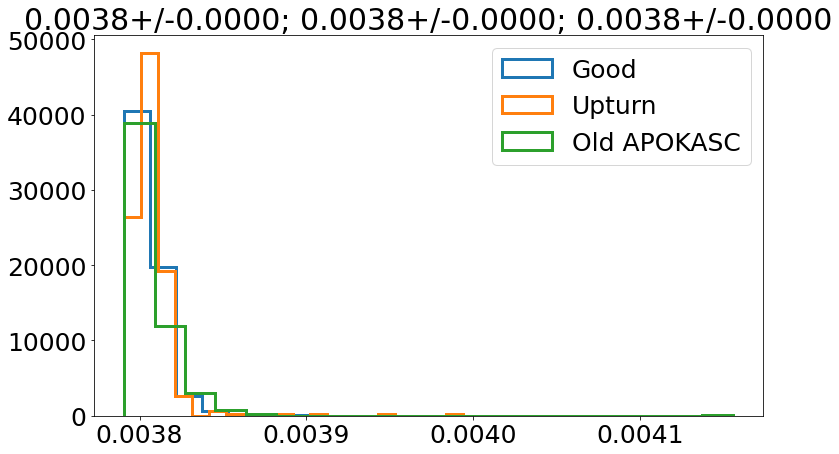

In [249]:
plt.figure(figsize=[12,7])
plt.hist(rperr[good],density=True,histtype='step',lw=3.0,bins=20,label='Good')
plt.hist(rperr[upturn],density=True,histtype='step',lw=3.0,bins=20,label='Upturn')
plt.hist(rperr[oldkasc],density=True,histtype='step',lw=3.0,bins=20,label='Old APOKASC')
plt.title(r'{:.4f}+/-{:.4f}; {:.4f}+/-{:.4f}; {:.4f}+/-{:.4f}'.format(np.median(rperr[good]),
                                              mad(rperr[good]),
                                              np.median(rperr[upturn]),
                                              mad(rperr[upturn]),
                                              np.median(rperr[oldkasc]),
                                              mad(rperr[oldkasc])))
plt.legend()
plt.show()

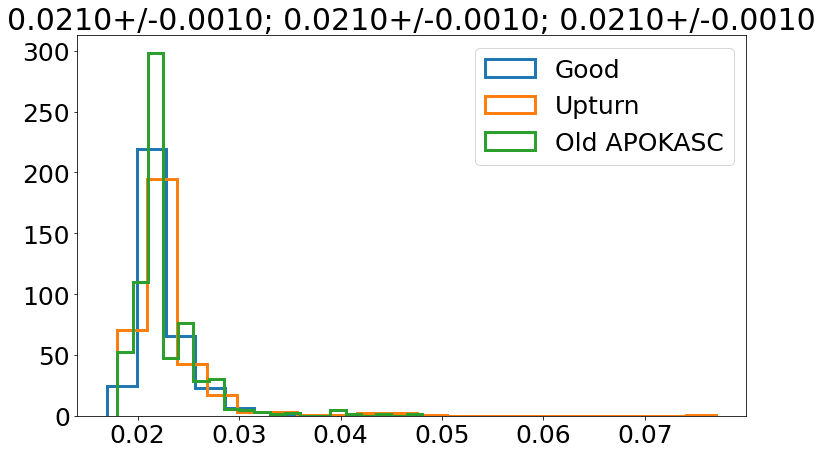

In [250]:
plt.figure(figsize=[12,7])
plt.hist(kdr17['J_ERR'][good],density=True,histtype='step',lw=3.0,bins=20,label='Good')
plt.hist(kdr17['J_ERR'][upturn],density=True,histtype='step',lw=3.0,bins=20,label='Upturn')
plt.hist(kdr17['J_ERR'][oldkasc],density=True,histtype='step',lw=3.0,bins=20,label='Old APOKASC')
plt.title(r'{:.4f}+/-{:.4f}; {:.4f}+/-{:.4f}; {:.4f}+/-{:.4f}'.format(np.nanmedian(kdr17['J_ERR'][good]),
                                              mad(kdr17['J_ERR'][good]),
                                              np.nanmedian(kdr17['J_ERR'][upturn]),
                                              mad(kdr17['J_ERR'][upturn]),
                                              np.nanmedian(kdr17['J_ERR'][oldkasc]),
                                              mad(kdr17['J_ERR'][oldkasc])))
plt.legend()
plt.show()

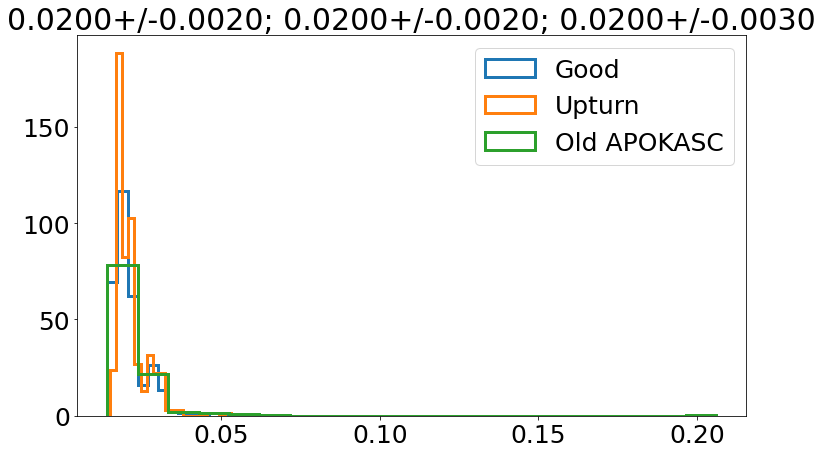

In [251]:
plt.figure(figsize=[12,7])
plt.hist(kdr17['H_ERR'][good],density=True,histtype='step',lw=3.0,bins=20,label='Good')
plt.hist(kdr17['H_ERR'][upturn],density=True,histtype='step',lw=3.0,bins=20,label='Upturn')
plt.hist(kdr17['H_ERR'][oldkasc],density=True,histtype='step',lw=3.0,bins=20,label='Old APOKASC')
plt.title(r'{:.4f}+/-{:.4f}; {:.4f}+/-{:.4f}; {:.4f}+/-{:.4f}'.format(np.nanmedian(kdr17['H_ERR'][good]),
                                              mad(kdr17['H_ERR'][good]),
                                              np.nanmedian(kdr17['H_ERR'][upturn]),
                                              mad(kdr17['H_ERR'][upturn]),
                                              np.nanmedian(kdr17['H_ERR'][oldkasc]),
                                              mad(kdr17['H_ERR'][oldkasc])))
plt.legend()
plt.show()

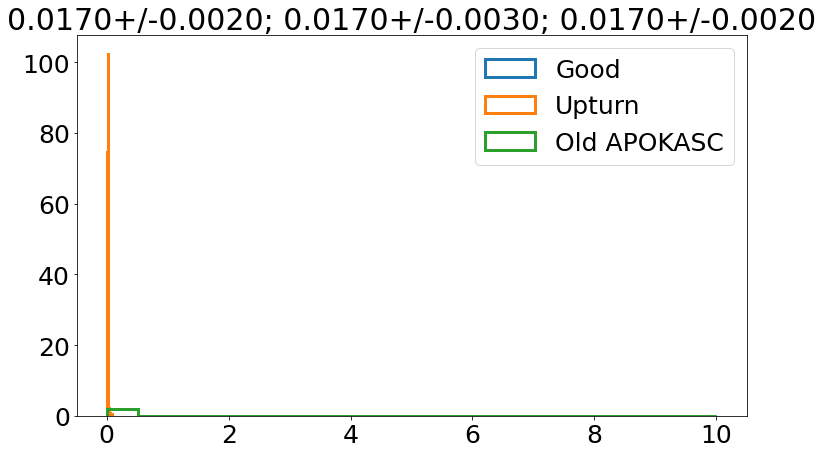

In [252]:
plt.figure(figsize=[12,7])
plt.hist(kdr17['K_ERR'][good],density=True,histtype='step',lw=3.0,bins=20,label='Good')
plt.hist(kdr17['K_ERR'][upturn],density=True,histtype='step',lw=3.0,bins=20,label='Upturn')
plt.hist(kdr17['K_ERR'][oldkasc],density=True,histtype='step',lw=3.0,bins=20,label='Old APOKASC')
plt.title(r'{:.4f}+/-{:.4f}; {:.4f}+/-{:.4f}; {:.4f}+/-{:.4f}'.format(np.nanmedian(kdr17['K_ERR'][good]),
                                              mad(kdr17['K_ERR'][good]),
                                              np.nanmedian(kdr17['K_ERR'][upturn]),
                                              mad(kdr17['K_ERR'][upturn]),
                                              np.nanmedian(kdr17['K_ERR'][oldkasc]),
                                              mad(kdr17['K_ERR'][oldkasc])))
plt.legend()
plt.show()

In [234]:
_, gaiaidx, gkdr17idx = np.intersect1d(gaiaedr3['col2'],kdr17['APOGEE_ID'],return_indices=True)


In [236]:
gaiaidx

array([], dtype=int64)

In [237]:
kdr17['APOGEE_ID']

chararray(['2M18401164+4324434', '2M18401542+4344444',
           '2M18401969+4348380', ..., '2M20055400+4415544',
           '2M20060757+4418390', '2M20063113+4435192'], dtype='<U30')

In [238]:
gaiaedr3['col2']

chararray(['2M00000002+7417074', '2M00000019-1924498',
           '2M00000032+5737103', ..., '2M23595921+5609479',
           '2M23595949-7342592', '2M23595980+1528407'], dtype='<U19')